<a href="https://colab.research.google.com/github/aayushmanda/da6401_assignment1/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import wandb
import argparse
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# Load the Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1)



# wandb.login(key='e6b43dd118f9a14e83fe12c597ad8d06bdfed432')

# # wandb.init(project="da6401-asg1")

# # Get the number of classes and their name mappings
# num_classes = 10
# class_mapping = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
# print("Done!")

# ##############################################################################
# # Plotting a figure from each class
# plt.figure(figsize=[12, 5])
# img_list = []
# class_list = []

# for i in range(num_classes):
#     position = np.argmax(train_labels==i)
#     image = train_images[position,:,:]
#     plt.subplot(2, 5, i+1)
#     plt.imshow(image)
#     plt.title(class_mapping[i])
#     img_list.append(image)
#     class_list.append(class_mapping[i])

# wandb.log({"Question 1": [wandb.Image(img, caption=caption) for img, caption in zip(img_list, class_list)]})


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, weight_init = "Xavier", bias=True):

    self.cache = dict(x=None)
    self.gradd = dict(weight=None, bias=None)
    if weight_init == "Xavier":
      #XavierInit
      self.weight = np.random.randn(fan_in, fan_out) / (fan_in + fan_out)**0.5
      self.bias = np.zeros(fan_out, dtype="f") if bias else None
    else:
      #RandomInit
      self.weight = np.random.randn(fan_in, fan_out)
      self.bias = np.random.randn(fan_out) if bias else None

  def __str__(self):
      return "Linear({:d}, {:d}, bias={})".format(self.weight.shape[0], self.weight.shape[1], self.bias is not None)


  def __call__(self, x):
      self.out = x @ self.weight
      if self.bias is not None:
          self.out += self.bias
      # Store input for backward pass
      self.cache["x"] = x
      return self.out

  def grad(self, d_out):
    x = self.cache["x"]
    # Weight gradient: x^T @ d_out
    self.gradd["weight"] = x.T @ d_out

    dzdx = d_out@self.weight.T

    # Bias gradient: sum over batch
    if self.bias is not None:
        self.gradd["bias"] = np.sum(d_out, axis=0)

    # returning dzdx
    return dzdx

  def parameters(self):
    return [self.weight] + ([self.bias] if self.bias is not None else [])



# -----------------------------------------------------------------------------------------------

class Tanh:
  def __call__(self, x):
    self.x = x
    self.out = np.tanh(self.x)
    # self.cache = {"x": np.tanh(self.x)}
    return self.out
  def parameters(self):
    # Activation Function
    return []

  def grad(self, dout):
    return dout * (1 - self.out**2)


# -----------------------------------------------------------------------------------------------

class Sigmoid:
  def __call__(self, x):
      self.out = 1. / (1. + np.exp(-x))
      return self.out

  def grad(self, d_out):
      # sigmoid derivative: σ(x)(1 - σ(x))
      return (self.out * (1. - self.out)) * d_out

  def parameters(self):
      return []



# -----------------------------------------------------------------------------------------------


class Relu:
  def __call__(self, x):
      self.cache = {"x": x}
      self.out = np.maximum(0, x)
      return self.out

  def grad(self, d_out):
      x = self.cache["x"]
      dx = np.ones_like(x)
      dx[x < 0] = 0
      return np.array(d_out) * dx

  def parameters(self):
      return []


# -----------------------------------------------------------------------------------------------

class CrossEntropyLoss:

    def __init__(self, reduction='mean', eps=1e-12):  # More stable epsilon
        super().__init__()
        self.eps = eps
        self.reduction = reduction

    def __str__(self):
        return f'CrossEntropyLoss(reduction={self.reduction}, eps={self.eps})'

    def __call__(self, y, y_true):
        return self.forward(y, y_true)

    def forward(self, y, y_true):
        # Final layer activation is softmax and y here is logits
        exp_y = np.exp(y - np.max(y, axis=1, keepdims=True))
        probs = exp_y / np.sum(exp_y + 1e-12, axis=1, keepdims=True)

        # print(probs)


        # Clip probabilities to [eps, 1-eps] to avoid log(0) Done this aftis after many random trials
        clipped_probs = np.clip(probs[y_true.astype(bool)], self.eps, 1.0 - self.eps)

        per_sample_loss = -np.log(clipped_probs)

        if self.reduction == 'mean':
            return np.mean(per_sample_loss)
        elif self.reduction == 'sum':
            return np.sum(per_sample_loss)
        else:
            return per_sample_loss

    def grad(self, y, y_true):
        # Simple (1/B)*(One - hot vector - yhat)
        return (1.0 / y.shape[0]) * (y - y_true)  # Maintain gradient scaling
# -----------------------------------------------------------------------------------------------


class Sequential:

  def __init__(self, layers=None):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def append(self, layer):
    self.layers.append(layer)

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

  def backward(self, d_out):
    # Backpropagate through layers in reverse order
    d = d_out
    gradients = []
    #storing layer.weight, layer.bias grad in a list also

    for layer in reversed(self.layers):
        d = layer.grad(d)
        if hasattr(layer, 'weight'):
            gradients.append(layer.gradd["bias"] if layer.bias is not None else None)
            gradients.append(layer.gradd["weight"])
    return d, list(reversed(gradients))

In [4]:
from keras.datasets import fashion_mnist

# Load the Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1)


ix = np.random.randint(0, train_images.shape[0], (32,))
x = train_images[ix]
x = x.reshape(32, -1)
y = train_labels[ix]
y = np.eye(10)[y]

In [5]:
x.shape, y.shape

((32, 784), (32, 10))

In [6]:
class MSE:
  def __init__(self, eps=1e-8):
      self.eps = eps
  def __call__(self, y, y_true):
      return self.forward(y, y_true)

  def forward(self, y, y_true):
      exp_y = np.exp(y - np.max(y, axis=1, keepdims=True))
      probs = exp_y / np.sum(exp_y + 1e-12, axis=1, keepdims=True)
      # Clip probabilities to [eps, 1-eps] to avoid log(0) Done this aftis after many random trials
      # clipped_probs = np.clip(probs[y_true.astype(bool)], self.eps, 1.0 - self.eps)
      return np.mean((probs - y_true)**2)

  def grad(self, y, y_true):
      # y: logits with shape (batch_size, num_classes)
      # Compute softmax probabilities
      exp_y = np.exp(y - np.max(y, axis=1, keepdims=True))
      probs = exp_y / (np.sum(exp_y, axis=1, keepdims=True) + 1e-12)
      batch_size, num_classes = y.shape
      grad_input = np.zeros_like(y)
      # For each sample in the batch, compute:
      #   dL/dp = 2*(probs - y_true)/batch_size   (MSE derivative w.r.t. softmax outputs)
      #   dp/dz = Jacobian of softmax = diag(p) - p pᵀ
      # and then dL/dz = (dp/dz) · (dL/dp)
      for i in range(batch_size):
          p = probs[i].reshape(-1, 1)  # Column vector (num_classes, 1)
          # Jacobian for softmax (num_classes x num_classes)
          J = np.diagflat(p) - np.dot(p, p.T)
          dL_dp = 2 * (probs[i] - y_true[i]) / batch_size
          grad_input[i, :] = np.dot(J, dL_dp)
      return grad_input

In [7]:
# logits[0], y[0], logits[0]

In [8]:
# y/logits[range(32),np.argmax(y, axis=1)].reshape(32,1)

In [9]:
class Optimizer():
    def __init__(self, lr=0.001, optimizer="sgd", momentum=0.9,
                 epsilon=1e-8, beta=0.9, beta1=0.9, beta2=0.999, t=0, decay=0, param=None):
      self.lr = lr
      self.optimizer = optimizer
      self.momentum = momentum
      self.epsilon = epsilon
      self.beta = beta
      self.beta1 = beta1
      self.beta2 = beta2
      self.t = t
      self.decay = decay
      self.velocity = [np.zeros_like(p) for p in param]
      self.moments = [np.zeros_like(p) for p in param]

    def __call__(self, param, dparam):
      self.run(param, dparam)

    def run(self, param, dparam, epoch=None):
        if(self.optimizer == "sgd"):
            self.SGD(param, dparam)
        elif(self.optimizer == "momentum"):
            self.MomentumGD(param, dparam)
        elif(self.optimizer == "nag"):
            self.NAG(param, dparam)
        elif(self.optimizer == "rmsprop"):
            self.RMSProp(param, dparam)
        elif(self.optimizer == "adam"):
            self.Adam(param, dparam)
        elif (self.optimizer == "nadam"):
            self.NAdam(param, dparam)
        else:
            raise Exception("Invalid optimizer")

    def SGD(self, param, dparam):
        for p, grad in zip(param, dparam):
            p -= self.lr * (grad + self.decay * p) #grad

    def MomentumGD(self, param, dparam):
        #tried using zeros but got Value error maximum dim support for ndarray is 32.
        for i, (u, param, grad) in enumerate(zip(self.velocity, param, dparam)):
            u = self.momentum * u + grad
            self.velocity[i] = u
            param -= self.lr * (u  + self.decay * param)   #clipped_dparam #grad

    def NAG(self, param, dparam):
        for i, (u, param, grad) in enumerate(zip(self.velocity, param, dparam)):

            u = self.momentum * u +  grad
            self.velocity[i] = u
            m_bar = grad + self.momentum * u
            param -= self.lr * (m_bar + self.decay * param)    #clipped_dparam #grad

    def RMSProp(self, param, dparam ):
        for i, (u, param, grad) in enumerate(zip(self.velocity, param, dparam)):
            u = self.beta * u + (1 - self.beta) * (grad**2)
            self.velocity[i] = u
            param -= self.lr * (grad / (np.sqrt(u + self.epsilon)) + self.decay * param)

    def Adam(self, param, dparam):
        i = self.t
        for i, (m, v, param, grad) in enumerate(zip(self.moments, self.velocity, param, dparam)):
            m = self.beta1 * m + (1 - self.beta1) * grad
            self.moments[i] = m
            m_hat = m/(1-self.beta1**(i+1))

            v = self.beta2 * v + (1 - self.beta2) * (grad**2)
            self.velocity[i] = v
            v_hat = v/(1-self.beta2**(i+1) )

            param -= self.lr * ( m_hat / (np.sqrt(v_hat + self.epsilon))+ self.decay * param)


    def NAdam(self, param, dparam):
        i = self.t
        for i, (m, v, param, grad) in enumerate(zip(self.moments, self.velocity, param, dparam)):
            g_hat = grad/(1-self.beta1**(i+1))
            m = self.beta1 * m + (1 - self.beta1) * grad
            self.moments[i] = m
            m_hat = m/(1-self.beta1**(i+1))

            v = self.beta1 * v + (1 - self.beta2) * (grad**2)
            self.velocity[i] = v
            v_hat = v/(1-self.beta2**(i+1))

            m_bar = (1-self.beta1)*g_hat + self.beta1*m_hat

            param -= self.lr * (m_bar / (np.sqrt(v_hat + self.epsilon))+ self.decay * param)

In [10]:
n_out = 10
n_hidden = 16
hid_layers = 5
ix = "relu"
init = "Xavier"


activation = {"tanh": Tanh(), "relu": Relu(), "sigmoid": Sigmoid()}

model = Sequential([Linear(784, n_hidden, weight_init = init)])
model.append(activation[ix])
# for i in range(hid_layers-1):
#   model.append(Linear(n_hidden, n_hidden, weight_init = init))
#   model.append(activation[ix])
model.append(Linear(n_hidden, 10, weight_init = init))
# model.append(Softmax())

In [11]:
[i.shape for i in model.parameters()]

[(784, 16), (16,), (16, 10), (10,)]

In [12]:
ix = np.random.randint(0, train_images.shape[0], (32,))
x = train_images[ix]
x = x.reshape(32, -1)
y = train_labels[ix]
y = np.eye(10)[y]
opt = Optimizer(lr=1e-3, optimizer="rmsprop", param=model.parameters())

#Forward Pass. ## Our cross entropy takes care of softmax activation in final layer

logits = model(x)
logits = logits/np.sum(logits, axis=-1, keepdims=True) # To stabilize the backward pass
loss = CrossEntropyLoss()(logits, y)
# print(loss)
#Backward Pass

dout = MSE().grad(logits, y)
dout = model.backward(dout)

#parameter update
opt(model.parameters(), dout[1])


In [14]:
loss

2.3341028691864

In [15]:
y = logits
exp_y = np.exp(y - np.max(y, axis=1, keepdims=True))
probs = exp_y / np.sum(exp_y + 1e-12, axis=1, keepdims=True)

In [ ]:
probs.shape, y.shape

((32, 10), (32, 10))

In [ ]:
np.diag(probs)

array([9.56100340e-02, 2.70886914e-01, 3.35212111e-01, 5.57796747e-02,
       7.86249261e-02, 3.52629851e-07, 1.59375871e-01, 6.45732291e-02,
       1.76690540e-01, 2.71973322e-02])

In [14]:
def initialize_model(activation, layer_sizes, init="Xavier"):
    if activation == "tanh":
      print("Activation used is Tanh")

      model = Sequential([Linear(784, layer_sizes[1], weight_init=init)])

      # Hidden layers
      for i in range(1, len(layer_sizes)-1):
          model.append(Tanh())
          model.append(Linear(layer_sizes[i], layer_sizes[i+1], weight_init=init))

      # Final output layer
      model.append(Tanh())
      model.append(Linear(layer_sizes[-1], 10, weight_init=init))  # 128->10


    elif activation == "relu":
      print("Activation used is ReLu")

      model = Sequential([Linear(784, layer_sizes[1], weight_init=init)])

      # Hidden layers
      for i in range(1, len(layer_sizes)-1):
          model.append(Relu())
          model.append(Linear(layer_sizes[i], layer_sizes[i+1], weight_init=init))

      # Final output layer
      model.append(Relu())
      model.append(Linear(layer_sizes[-1], 10, weight_init=init))  # 128->10


    elif activation == "sigmoid":
      print("Activation used is Sigmoid")

      model = Sequential([Linear(784, layer_sizes[1], weight_init=init)])

      # Hidden layers
      for i in range(1, len(layer_sizes)-1):
          model.append(Sigmoid())
          model.append(Linear(layer_sizes[i], layer_sizes[i+1], weight_init=init))

      # Final output layer
      model.append(Sigmoid())
      model.append(Linear(layer_sizes[-1], 10, weight_init=init))  # 128->10
    return model



In [17]:
import wandb

def train():
    #init run
    run = wandb.init()

    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1)
    X = train_images.reshape(train_images.shape[0], -1)/ 255.0
    Y = train_labels
    Y = np.eye(10)[Y]


    config = wandb.config
    hid_layers = config.hid_layers
    init = config.init
    # max_steps = wandb.config.n_steps
    batch_size = config.batch_size
    activation = config.activation
    nepoch = config.nepoch
    loss_fn = config.loss
    Loss = CrossEntropyLoss() if loss_fn=="cross_entropy" else MSE()
    #naming the run
    run.name = f"opt_{config.optimizer}|loss_{loss_fn}|lr={config.lr}|batch_{batch_size}|act_{activation}|hid_{hid_layers}|neurons_{config.hid_size}|nrns_{nepoch}|init_{init}" + str(np.random.randint(1000))

    layer_sizes = [config.hid_size] * (hid_layers + 1)



    model = initialize_model(activation, layer_sizes, init)

    opt = Optimizer(lr=config.lr, optimizer=config.optimizer, decay = config.decay, param=model.parameters())

    logits = model(X)
    train_loss = Loss(logits, Y)
    train_accuracy = np.mean(np.argmax(logits, axis=1) == np.argmax(Y, axis=1))

    val_logits = model(val_images.reshape(val_images.shape[0], -1)/ 255.0)
    Yv = np.eye(10)[val_labels]
    val_loss = Loss(val_logits, Yv)
    val_accuracy = np.mean(np.argmax(val_logits, axis=1) == np.argmax(Yv, axis=1))

    print(f"Start of Training: {1} Train Accuracy: {train_accuracy:.4f} Val Loss: {val_loss:.4f} Val Accuracy: {val_accuracy:.4f}")
    wandb.log({"Epoch": 0, "Val Loss": val_loss, "Train Accuracy": train_accuracy, "Val Accuracy": val_accuracy})

    for epoch in range(nepoch):
      print("-------x-------")
      #Shuffling
      indices = np.random.permutation(X.shape[0])
      X = X[indices]
      Y = Y[indices]

      for i in range(0, train_images.shape[0], batch_size):
        Xb = X[i:i + batch_size]
        Yb = Y[i:i + batch_size]

        logits = model(Xb)

        loss = Loss(logits, Yb)

        #Backward Pass
        dout = Loss.grad(logits, Yb)
        dout = model.backward(dout)


        batch_num = i//batch_size
        total_batch = train_images.shape[0]//batch_size



        #Parameter Update
        opt(model.parameters(), dout[1])

        if batch_num%200 == 0: # print every once in a while uhh to be precise after 200 batch
          print(f'Epoch({epoch+1}/{nepoch})\t Batch({batch_num:2d}/{total_batch:2d}): \tTrain Loss  {loss:.4f}')

      opt.t += 1


      #Accuracy Calculation
      wandb.log({"Epoch": epoch+1, "Train Loss": loss})
      logits = model(X)
      train_loss = Loss(logits, Y)
      train_accuracy = np.mean(np.argmax(logits, axis=1) == np.argmax(Y, axis=1))

      val_logits = model(val_images.reshape(val_images.shape[0], -1)/ 255.0)
      Yv = np.eye(10)[val_labels]
      val_loss = Loss(val_logits, Yv)
      val_accuracy = np.mean(np.argmax(val_logits, axis=1) == np.argmax(Yv, axis=1))



      print(f"End of Epoch: {epoch+1} Train Accuracy: {train_accuracy:.4f} Val Loss: {val_loss:.4f} Val Accuracy: {val_accuracy:.4f}")
      wandb.log({"Epoch": epoch+1, "Val Loss": val_loss, "Train Accuracy": train_accuracy, "Val Accuracy": val_accuracy})

    # -----------------------------------------------------------------------------------------------








In [18]:
wandb.login(key='e6b43dd118f9a14e83fe12c597ad8d06bdfed432')


# Sweep configuration
sweep_config = {
    "method": "random",
    "metric": {"goal": "maximize", "name": "Val Accuracy"},
    "parameters": {
        "batch_size": {"values": [16, 32, 64]},
        "decay": {"values": [0, 0.5, 0.0005]},
        "hid_layers": {"values": [3, 4, 5]},
        "hid_size": {"values": [32, 64, 128]},
        "nepoch": {"values": [5, 10]},
        "activation": {"values": ["relu", "tanh", "sigmoid"]},
        "init": {"values": ["Xavier", "Random"]},
        "optimizer": {"values": ["sgd", "momentum", "rmsprop", "nag", "adam", "nadam"]},
        "loss": {"values": ["mse", "cross_entropy"]},
        "lr": {"values": [0.0001, 0.001]},
    },
}
sweep_id = wandb.sweep(sweep_config, project="da6401-assignment1")
wandb.agent(sweep_id, function=train, count = 100)
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24s016 (da24s016-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: cd4pcsed
Sweep URL: https://wandb.ai/da24s016-indian-institute-of-technology-madras/da6401-assignment1/sweeps/cd4pcsed


wandb: Agent Starting Run: 7keblrui with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	decay: 0.5
wandb: 	hid_layers: 3
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: rmsprop


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0990 Val Loss: 2.3018 Val Accuracy: 0.0985
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  2.3044
Epoch(1/5)	 Batch(200/3375): 	Train Loss  1.8787
Epoch(1/5)	 Batch(400/3375): 	Train Loss  1.7951
Epoch(1/5)	 Batch(600/3375): 	Train Loss  1.7131
Epoch(1/5)	 Batch(800/3375): 	Train Loss  1.7742
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  1.7729
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  1.4992
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  1.6369
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  1.6648
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  1.7440
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  1.7349
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  1.7073
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  1.8350
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  1.6415
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  1.6531
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  1.7091
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  1.7434
End of Epoch: 1 Train Accuracy: 0.

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁█████
Train Loss,▅▁█▅▃
Val Accuracy,▁█████
Val Loss,█▂▁▂▁▁
Epoch,5
Train Accuracy,0.80081
Train Loss,1.57983
Val Accuracy,0.79083
Val Loss,1.69719


wandb: Agent Starting Run: 8rppgz9x with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 3
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: nadam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0668 Val Loss: 0.1872 Val Accuracy: 0.0637
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  0.1906
Epoch(1/10)	 Batch(200/843): 	Train Loss  0.1844
Epoch(1/10)	 Batch(400/843): 	Train Loss  0.1812
Epoch(1/10)	 Batch(600/843): 	Train Loss  0.1781
Epoch(1/10)	 Batch(800/843): 	Train Loss  0.1693
End of Epoch: 1 Train Accuracy: 0.1068 Val Loss: 0.1795 Val Accuracy: 0.1023
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  0.1812
Epoch(2/10)	 Batch(200/843): 	Train Loss  0.1906
Epoch(2/10)	 Batch(400/843): 	Train Loss  0.1750
Epoch(2/10)	 Batch(600/843): 	Train Loss  0.1750
Epoch(2/10)	 Batch(800/843): 	Train Loss  0.1781
End of Epoch: 2 Train Accuracy: 0.1387 Val Loss: 0.1731 Val Accuracy: 0.1340
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  0.1750
Epoch(3/10)	 Batch(200/843): 	Train Loss  0.1656
Epoch(3/10)	 Batch(400/843): 	Train Loss  0.1655
Epoch(3/10)	 Batch(600/843): 	Train Loss  0.1687
Epoch(3/1

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▃▅▆███▇███
Train Loss,█▇▄▄▅▅▃▄▁▄
Val Accuracy,▁▃▅▆███▇███
Val Loss,█▆▄▃▁▁▁▂▁▁▁
Epoch,10
Train Accuracy,0.191
Train Loss,0.157
Val Accuracy,0.18733
Val Loss,0.16227


wandb: Agent Starting Run: 5l3w383x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 4
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: sgd


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.1003 Val Loss: 0.0922 Val Accuracy: 0.0977
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  0.0934
Epoch(1/10)	 Batch(200/843): 	Train Loss  0.0908
Epoch(1/10)	 Batch(400/843): 	Train Loss  0.0908
Epoch(1/10)	 Batch(600/843): 	Train Loss  0.0902
Epoch(1/10)	 Batch(800/843): 	Train Loss  0.0910
End of Epoch: 1 Train Accuracy: 0.1003 Val Loss: 0.0904 Val Accuracy: 0.0977
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  0.0907
Epoch(2/10)	 Batch(200/843): 	Train Loss  0.0902
Epoch(2/10)	 Batch(400/843): 	Train Loss  0.0900
Epoch(2/10)	 Batch(600/843): 	Train Loss  0.0904
Epoch(2/10)	 Batch(800/843): 	Train Loss  0.0905
End of Epoch: 2 Train Accuracy: 0.1003 Val Loss: 0.0901 Val Accuracy: 0.0977
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  0.0903
Epoch(3/10)	 Batch(200/843): 	Train Loss  0.0904
Epoch(3/10)	 Batch(400/843): 	Train Loss  0.0902
Epoch(3/10)	 Batch(600/843): 	Train Loss  0.0899
Epoch(

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▁▁▁▁██████
Train Loss,█▄▁▁▁▁▁▁▁▁
Val Accuracy,█████▁▁▁▁▁▁
Val Loss,█▂▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.1005
Train Loss,0.09
Val Accuracy,0.0955
Val Loss,0.09


wandb: Agent Starting Run: ygtsick7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: nag


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0988 Val Loss: 0.0925 Val Accuracy: 0.1108
-------x-------
Epoch(1/10)	 Batch( 0/1687): 	Train Loss  0.0935
Epoch(1/10)	 Batch(200/1687): 	Train Loss  0.0911
Epoch(1/10)	 Batch(400/1687): 	Train Loss  0.0906
Epoch(1/10)	 Batch(600/1687): 	Train Loss  0.0904
Epoch(1/10)	 Batch(800/1687): 	Train Loss  0.0898
Epoch(1/10)	 Batch(1000/1687): 	Train Loss  0.0900
Epoch(1/10)	 Batch(1200/1687): 	Train Loss  0.0901
Epoch(1/10)	 Batch(1400/1687): 	Train Loss  0.0901
Epoch(1/10)	 Batch(1600/1687): 	Train Loss  0.0900
End of Epoch: 1 Train Accuracy: 0.1006 Val Loss: 0.0900 Val Accuracy: 0.0948
-------x-------
Epoch(2/10)	 Batch( 0/1687): 	Train Loss  0.0900
Epoch(2/10)	 Batch(200/1687): 	Train Loss  0.0901
Epoch(2/10)	 Batch(400/1687): 	Train Loss  0.0900
Epoch(2/10)	 Batch(600/1687): 	Train Loss  0.0900
Epoch(2/10)	 Batch(800/1687): 	Train Loss  0.0901
Epoch(2/10)	 Batch(1000/1687): 	Train Loss  0.0901
Epoch(2/10)	 Batch(1200/1687)

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁██▆█▆▇██▆█
Train Loss,▄█▆▁▄▆▅▃▃▆
Val Accuracy,█▁▁▃▁▃▂▁▁▃▁
Val Loss,█▁▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.10057
Train Loss,0.09009
Val Accuracy,0.09483
Val Loss,0.09001


wandb: Agent Starting Run: bdnm6v1p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	decay: 0.0005
wandb: 	hid_layers: 4
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: momentum


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1611 Val Loss: 0.0900 Val Accuracy: 0.1648
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  0.0903
Epoch(1/5)	 Batch(200/843): 	Train Loss  0.0894
Epoch(1/5)	 Batch(400/843): 	Train Loss  0.0900
Epoch(1/5)	 Batch(600/843): 	Train Loss  0.0897
Epoch(1/5)	 Batch(800/843): 	Train Loss  0.0886
End of Epoch: 1 Train Accuracy: 0.2596 Val Loss: 0.0891 Val Accuracy: 0.2647
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  0.0891
Epoch(2/5)	 Batch(200/843): 	Train Loss  0.0885
Epoch(2/5)	 Batch(400/843): 	Train Loss  0.0887
Epoch(2/5)	 Batch(600/843): 	Train Loss  0.0885
Epoch(2/5)	 Batch(800/843): 	Train Loss  0.0882
End of Epoch: 2 Train Accuracy: 0.2794 Val Loss: 0.0881 Val Accuracy: 0.2887
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  0.0884
Epoch(3/5)	 Batch(200/843): 	Train Loss  0.0880
Epoch(3/5)	 Batch(400/843): 	Train Loss  0.0875
Epoch(3/5)	 Batch(600/843): 	Train Loss  0.0872
Epoch(3/5)	 Batch(800/8

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▅▅▆▇█
Train Loss,█▆▆▄▁
Val Accuracy,▁▅▆▆▇█
Val Loss,█▇▆▅▃▁
Epoch,5
Train Accuracy,0.35087
Train Loss,0.0822
Val Accuracy,0.35383
Val Loss,0.08323


wandb: Agent Starting Run: zhsf5qh0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	decay: 0
wandb: 	hid_layers: 5
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: nag


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.0877 Val Loss: 0.1640 Val Accuracy: 0.0915
-------x-------
Epoch(1/10)	 Batch( 0/1687): 	Train Loss  0.1607
Epoch(1/10)	 Batch(200/1687): 	Train Loss  0.1453
Epoch(1/10)	 Batch(400/1687): 	Train Loss  0.1693
Epoch(1/10)	 Batch(600/1687): 	Train Loss  0.1604
Epoch(1/10)	 Batch(800/1687): 	Train Loss  0.1645
Epoch(1/10)	 Batch(1000/1687): 	Train Loss  0.1590
Epoch(1/10)	 Batch(1200/1687): 	Train Loss  0.1734
Epoch(1/10)	 Batch(1400/1687): 	Train Loss  0.1378
Epoch(1/10)	 Batch(1600/1687): 	Train Loss  0.1687
End of Epoch: 1 Train Accuracy: 0.1051 Val Loss: 0.1613 Val Accuracy: 0.1058
-------x-------
Epoch(2/10)	 Batch( 0/1687): 	Train Loss  0.1683
Epoch(2/10)	 Batch(200/1687): 	Train Loss  0.1268
Epoch(2/10)	 Batch(400/1687): 	Train Loss  0.1590
Epoch(2/10)	 Batch(600/1687): 	Train Loss  0.1642
Epoch(2/10)	 Batch(800/1687): 	Train Loss  0.1683
Epoch(2/10)	 Batch(1000/1687): 	Train Loss  0.1631
Epoch(2/10)	 Batch(1200/1687): 	

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▂▂▃▃▄▄▅▆▇█
Train Loss,▃▆█▂▅▂▆▁▂▇
Val Accuracy,▁▂▂▂▃▃▄▅▆▇█
Val Loss,█▇▆▆▆▅▅▄▃▂▁
Epoch,10
Train Accuracy,0.26309
Train Loss,0.15712
Val Accuracy,0.2515
Val Loss,0.13181


wandb: Agent Starting Run: teeddoaz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: momentum


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.1067 Val Loss: 0.1781 Val Accuracy: 0.1095
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  0.1687
Epoch(1/5)	 Batch(200/843): 	Train Loss  0.1875
Epoch(1/5)	 Batch(400/843): 	Train Loss  0.1531
Epoch(1/5)	 Batch(600/843): 	Train Loss  0.1719
Epoch(1/5)	 Batch(800/843): 	Train Loss  0.1812
End of Epoch: 1 Train Accuracy: 0.1066 Val Loss: 0.1781 Val Accuracy: 0.1095
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  0.1656
Epoch(2/5)	 Batch(200/843): 	Train Loss  0.1844
Epoch(2/5)	 Batch(400/843): 	Train Loss  0.1812
Epoch(2/5)	 Batch(600/843): 	Train Loss  0.1844
Epoch(2/5)	 Batch(800/843): 	Train Loss  0.1812
End of Epoch: 2 Train Accuracy: 0.0998 Val Loss: 0.1796 Val Accuracy: 0.1022
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  0.1812
Epoch(3/5)	 Batch(200/843): 	Train Loss  0.1875
Epoch(3/5)	 Batch(400/843): 	Train Loss  0.1844
Epoch(3/5)	 Batch(600/843): 	Train Loss  0.1844
Epoch(3/5)	 Batch(800/8

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,██▁▁▁▁
Train Loss,▁▇█▄▄
Val Accuracy,██▁▁▁▁
Val Loss,▁▁████
Epoch,5
Train Accuracy,0.09976
Train Loss,0.17917
Val Accuracy,0.10217
Val Loss,0.17957


wandb: Agent Starting Run: 0hb5lc3z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 4
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: momentum


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.0910 Val Loss: 0.1669 Val Accuracy: 0.0920
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  0.1570
Epoch(1/5)	 Batch(200/843): 	Train Loss  0.1551
Epoch(1/5)	 Batch(400/843): 	Train Loss  0.1761
Epoch(1/5)	 Batch(600/843): 	Train Loss  0.1667
Epoch(1/5)	 Batch(800/843): 	Train Loss  0.1701
End of Epoch: 1 Train Accuracy: 0.1016 Val Loss: 0.1656 Val Accuracy: 0.0947
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  0.1491
Epoch(2/5)	 Batch(200/843): 	Train Loss  0.1568
Epoch(2/5)	 Batch(400/843): 	Train Loss  0.1533
Epoch(2/5)	 Batch(600/843): 	Train Loss  0.1603
Epoch(2/5)	 Batch(800/843): 	Train Loss  0.1681
End of Epoch: 2 Train Accuracy: 0.1093 Val Loss: 0.1638 Val Accuracy: 0.1015
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  0.1523
Epoch(3/5)	 Batch(200/843): 	Train Loss  0.1679
Epoch(3/5)	 Batch(400/843): 	Train Loss  0.1626
Epoch(3/5)	 Batch(600/843): 	Train Loss  0.1647
Epoch(3/5)	 Batch(800/8

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▃▄▅▆█
Train Loss,▇▁▂█▂
Val Accuracy,▁▂▄▄▆█
Val Loss,█▇▆▄▃▁
Epoch,5
Train Accuracy,0.13146
Train Loss,0.15955
Val Accuracy,0.11733
Val Loss,0.15809


wandb: Agent Starting Run: 0uewsjdp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 4
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: adam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0711 Val Loss: 2.3086 Val Accuracy: 0.0708
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  2.3047
Epoch(1/5)	 Batch(200/843): 	Train Loss  1.9427
Epoch(1/5)	 Batch(400/843): 	Train Loss  1.8840
Epoch(1/5)	 Batch(600/843): 	Train Loss  1.8255
Epoch(1/5)	 Batch(800/843): 	Train Loss  1.8269
End of Epoch: 1 Train Accuracy: 0.8011 Val Loss: 1.8057 Val Accuracy: 0.8022
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  1.8183
Epoch(2/5)	 Batch(200/843): 	Train Loss  1.8538
Epoch(2/5)	 Batch(400/843): 	Train Loss  1.7787
Epoch(2/5)	 Batch(600/843): 	Train Loss  1.7522
Epoch(2/5)	 Batch(800/843): 	Train Loss  1.7255
End of Epoch: 2 Train Accuracy: 0.8207 Val Loss: 1.7668 Val Accuracy: 0.8235
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  1.7830
Epoch(3/5)	 Batch(200/843): 	Train Loss  1.7876
Epoch(3/5)	 Batch(400/843): 	Train Loss  1.7468
Epoch(3/5)	 Batch(600/843): 	Train Loss  1.7378
Epoch(3/5)	 Batch(800/8

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁█████
Train Loss,█▆▂▁▃
Val Accuracy,▁█████
Val Loss,█▂▁▁▁▁
Epoch,5
Train Accuracy,0.8427
Train Loss,1.71894
Val Accuracy,0.8485
Val Loss,1.73739


wandb: Agent Starting Run: l3zptbt0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.0005
wandb: 	hid_layers: 4
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: sgd


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0954 Val Loss: 0.1816 Val Accuracy: 0.0920
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  0.1656
Epoch(1/5)	 Batch(200/843): 	Train Loss  0.1844
Epoch(1/5)	 Batch(400/843): 	Train Loss  0.1844
Epoch(1/5)	 Batch(600/843): 	Train Loss  0.1812
Epoch(1/5)	 Batch(800/843): 	Train Loss  0.1844
End of Epoch: 1 Train Accuracy: 0.0952 Val Loss: 0.1816 Val Accuracy: 0.0922
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  0.1750
Epoch(2/5)	 Batch(200/843): 	Train Loss  0.1844
Epoch(2/5)	 Batch(400/843): 	Train Loss  0.1812
Epoch(2/5)	 Batch(600/843): 	Train Loss  0.1812
Epoch(2/5)	 Batch(800/843): 	Train Loss  0.1812
End of Epoch: 2 Train Accuracy: 0.0969 Val Loss: 0.1815 Val Accuracy: 0.0927
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  0.1781
Epoch(3/5)	 Batch(200/843): 	Train Loss  0.1656
Epoch(3/5)	 Batch(400/843): 	Train Loss  0.1812
Epoch(3/5)	 Batch(600/843): 	Train Loss  0.1750
Epoch(3/5)	 Batch(800/8

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▁▅▂▆█
Train Loss,▃▁▃▄█
Val Accuracy,▁▁▂▂▄█
Val Loss,██▆▇▅▁
Epoch,5
Train Accuracy,0.0985
Train Loss,0.19167
Val Accuracy,0.09517
Val Loss,0.18097


wandb: Agent Starting Run: 34fcolip with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	decay: 0.0005
wandb: 	hid_layers: 3
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: rmsprop


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0853 Val Loss: 0.1624 Val Accuracy: 0.0820
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  0.1410
Epoch(1/10)	 Batch(200/3375): 	Train Loss  0.0717
Epoch(1/10)	 Batch(400/3375): 	Train Loss  0.0542
Epoch(1/10)	 Batch(600/3375): 	Train Loss  0.0750
Epoch(1/10)	 Batch(800/3375): 	Train Loss  0.0489
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  0.0545
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  0.0291
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  0.0290
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  0.0237
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  0.0493
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  0.0258
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  0.0603
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  0.0518
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  0.0306
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  0.0396
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  0.0313
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  0.0350
End of Epoch: 

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▇▇▇▇▇█████
Train Loss,█▄▅▄▃▄▄▁▃▅
Val Accuracy,▁▇▇▇▇▇█████
Val Loss,█▂▂▂▂▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.88157
Train Loss,0.03275
Val Accuracy,0.86567
Val Loss,0.01992


wandb: Agent Starting Run: 9gxbvc2p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 32
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: rmsprop


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.1001 Val Loss: 6.4415 Val Accuracy: 0.0995
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  5.7622
Epoch(1/5)	 Batch(200/3375): 	Train Loss  2.2247
Epoch(1/5)	 Batch(400/3375): 	Train Loss  2.1177
Epoch(1/5)	 Batch(600/3375): 	Train Loss  2.1235
Epoch(1/5)	 Batch(800/3375): 	Train Loss  2.0871
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  1.9489
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  2.0762
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  1.9594
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  2.0568
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  1.9368
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  1.9977
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  1.8686
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  1.8904
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  1.9298
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  2.0118
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  1.9099
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  1.9344
End of Epoch: 1 Train Accuracy:

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁██▇▇▇
Train Loss,▆▄▇▁█
Val Accuracy,▁██▇▇▇
Val Loss,█▁▁▁▁▁
Epoch,5
Train Accuracy,0.64826
Train Loss,1.98621
Val Accuracy,0.65133
Val Loss,1.90639


wandb: Agent Starting Run: h3g2gt37 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: nag


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0999 Val Loss: 25.0613 Val Accuracy: 0.0930
-------x-------
Epoch(1/5)	 Batch( 0/1687): 	Train Loss  25.0406


<ipython-input-2-4f78d507ffd0>:34: RuntimeWarning: overflow encountered in matmul
  self.gradd["weight"] = x.T @ d_out
<ipython-input-2-4f78d507ffd0>:36: RuntimeWarning: overflow encountered in matmul
  dzdx = d_out@self.weight.T
<ipython-input-2-4f78d507ffd0>:95: RuntimeWarning: invalid value encountered in multiply
  return np.array(d_out) * dx
<ipython-input-2-4f78d507ffd0>:34: RuntimeWarning: invalid value encountered in matmul
  self.gradd["weight"] = x.T @ d_out


Epoch(1/5)	 Batch(200/1687): 	Train Loss  nan
Epoch(1/5)	 Batch(400/1687): 	Train Loss  nan
Epoch(1/5)	 Batch(600/1687): 	Train Loss  nan
Epoch(1/5)	 Batch(800/1687): 	Train Loss  nan
Epoch(1/5)	 Batch(1000/1687): 	Train Loss  nan
Epoch(1/5)	 Batch(1200/1687): 	Train Loss  nan
Epoch(1/5)	 Batch(1400/1687): 	Train Loss  nan
Epoch(1/5)	 Batch(1600/1687): 	Train Loss  nan
End of Epoch: 1 Train Accuracy: 0.0996 Val Loss: nan Val Accuracy: 0.1033
-------x-------
Epoch(2/5)	 Batch( 0/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(200/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(400/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(600/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(800/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(1000/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(1200/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(1400/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(1600/1687): 	Train Loss  nan
End of Epoch: 2 Train Accuracy: 0.0996 Val Loss: nan Val Accuracy: 0.1033
-------x-------
Epoch(3/5)	 Batch( 0/1687): 	Tr

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,█▁▁▁▁▁
Val Accuracy,▁█████
Val Loss,▁
Epoch,5
Train Accuracy,0.09963
Train Loss,nan
Val Accuracy,0.10333
Val Loss,nan


wandb: Agent Starting Run: 9ev9vzhp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	decay: 0
wandb: 	hid_layers: 4
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: rmsprop


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0925 Val Loss: 9.8265 Val Accuracy: 0.0965
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  9.8054
Epoch(1/5)	 Batch(200/843): 	Train Loss  3.5961
Epoch(1/5)	 Batch(400/843): 	Train Loss  2.5795
Epoch(1/5)	 Batch(600/843): 	Train Loss  2.2981
Epoch(1/5)	 Batch(800/843): 	Train Loss  2.3194
End of Epoch: 1 Train Accuracy: 0.1628 Val Loss: 2.2708 Val Accuracy: 0.1575
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  2.2738
Epoch(2/5)	 Batch(200/843): 	Train Loss  2.2495
Epoch(2/5)	 Batch(400/843): 	Train Loss  2.1885
Epoch(2/5)	 Batch(600/843): 	Train Loss  2.2143
Epoch(2/5)	 Batch(800/843): 	Train Loss  2.1346
End of Epoch: 2 Train Accuracy: 0.4771 Val Loss: 2.1512 Val Accuracy: 0.4698
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  2.1156
Epoch(3/5)	 Batch(200/843): 	Train Loss  2.1086
Epoch(3/5)	 Batch(400/843): 	Train Loss  2.0861
Epoch(3/5)	 Batch(600/843): 	Train Loss  2.0437
Epoch(3/5)	 Batch(80

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▂▅▇██
Train Loss,█▅▄▃▁
Val Accuracy,▁▂▅▇██
Val Loss,█▁▁▁▁▁
Epoch,5
Train Accuracy,0.69924
Train Loss,1.84991
Val Accuracy,0.69067
Val Loss,1.91183


wandb: Agent Starting Run: 5xang9rc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	decay: 0.0005
wandb: 	hid_layers: 3
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: momentum


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.1070 Val Loss: 6.3098 Val Accuracy: 0.1090
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  6.1330
Epoch(1/10)	 Batch(200/843): 	Train Loss  2.2546
Epoch(1/10)	 Batch(400/843): 	Train Loss  2.2932
Epoch(1/10)	 Batch(600/843): 	Train Loss  2.2473
Epoch(1/10)	 Batch(800/843): 	Train Loss  2.2488
End of Epoch: 1 Train Accuracy: 0.2449 Val Loss: 2.2423 Val Accuracy: 0.2440
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  2.2228
Epoch(2/10)	 Batch(200/843): 	Train Loss  2.2380
Epoch(2/10)	 Batch(400/843): 	Train Loss  2.2460
Epoch(2/10)	 Batch(600/843): 	Train Loss  2.2211
Epoch(2/10)	 Batch(800/843): 	Train Loss  2.2245
End of Epoch: 2 Train Accuracy: 0.3064 Val Loss: 2.2423 Val Accuracy: 0.3013
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  2.2415
Epoch(3/10)	 Batch(200/843): 	Train Loss  2.2174
Epoch(3/10)	 Batch(400/843): 	Train Loss  2.2334
Epoch(3/10)	 Batch(600/843): 	Train Loss  2.2241
Epoch(

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▄▅▆▆▇▇▇▇██
Train Loss,█▆█▅▄▂▁▄▅▁
Val Accuracy,▁▄▅▆▆▇▇▇▇██
Val Loss,█▁▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.43144
Train Loss,2.13398
Val Accuracy,0.42167
Val Loss,2.13542


wandb: Agent Starting Run: 2qrdt6oj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: nadam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0829 Val Loss: 0.1828 Val Accuracy: 0.0862
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  0.1844
Epoch(1/10)	 Batch(200/843): 	Train Loss  0.1781
Epoch(1/10)	 Batch(400/843): 	Train Loss  0.1781
Epoch(1/10)	 Batch(600/843): 	Train Loss  0.1781
Epoch(1/10)	 Batch(800/843): 	Train Loss  0.1656
End of Epoch: 1 Train Accuracy: 0.1002 Val Loss: 0.1802 Val Accuracy: 0.0990
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  0.1750
Epoch(2/10)	 Batch(200/843): 	Train Loss  0.1844
Epoch(2/10)	 Batch(400/843): 	Train Loss  0.1812
Epoch(2/10)	 Batch(600/843): 	Train Loss  0.1781
Epoch(2/10)	 Batch(800/843): 	Train Loss  0.1687
End of Epoch: 2 Train Accuracy: 0.1001 Val Loss: 0.1802 Val Accuracy: 0.0988
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  0.1875
Epoch(3/10)	 Batch(200/843): 	Train Loss  0.1812
Epoch(3/10)	 Batch(400/843): 	Train Loss  0.1719
Epoch(3/10)	 Batch(600/843): 	Train Loss  0.1844
Epoch(3/1

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▁▁▁███████
Train Loss,███▁▁▁▁▁▁▁
Val Accuracy,▁▁▁▁███████
Val Loss,████▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.86113
Train Loss,0.01375
Val Accuracy,0.855
Val Loss,0.02131


wandb: Agent Starting Run: 1pwvzszp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	decay: 0
wandb: 	hid_layers: 5
wandb: 	hid_size: 32
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: adam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0246 Val Loss: 0.0900 Val Accuracy: 0.0273
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  0.0902
Epoch(1/10)	 Batch(200/3375): 	Train Loss  0.0889
Epoch(1/10)	 Batch(400/3375): 	Train Loss  0.0860
Epoch(1/10)	 Batch(600/3375): 	Train Loss  0.0816
Epoch(1/10)	 Batch(800/3375): 	Train Loss  0.0795
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  0.0821
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  0.0649
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  0.0750
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  0.0620
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  0.0590
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  0.0758
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  0.0506
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  0.0643
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  0.0467
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  0.0526
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  0.0676
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  0.0429
End of Epoch: 1 T

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▆▇▇███████
Train Loss,█▂▁▅▄▄▅▁▃▁
Val Accuracy,▁▆▇▇███████
Val Loss,█▄▃▂▂▂▁▁▁▁▁
Epoch,10
Train Accuracy,0.82098
Train Loss,0.02027
Val Accuracy,0.82333
Val Loss,0.02671


wandb: Agent Starting Run: euzeijic with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	decay: 0.5
wandb: 	hid_layers: 3
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: nadam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.1217 Val Loss: 0.1769 Val Accuracy: 0.1148
-------x-------
Epoch(1/10)	 Batch( 0/1687): 	Train Loss  0.1750
Epoch(1/10)	 Batch(200/1687): 	Train Loss  0.1937
Epoch(1/10)	 Batch(400/1687): 	Train Loss  0.1812
Epoch(1/10)	 Batch(600/1687): 	Train Loss  0.1500
Epoch(1/10)	 Batch(800/1687): 	Train Loss  0.1500
Epoch(1/10)	 Batch(1000/1687): 	Train Loss  0.1679
Epoch(1/10)	 Batch(1200/1687): 	Train Loss  0.1687
Epoch(1/10)	 Batch(1400/1687): 	Train Loss  0.1316
Epoch(1/10)	 Batch(1600/1687): 	Train Loss  0.1625
End of Epoch: 1 Train Accuracy: 0.1558 Val Loss: 0.1698 Val Accuracy: 0.1508
-------x-------
Epoch(2/10)	 Batch( 0/1687): 	Train Loss  0.1687
Epoch(2/10)	 Batch(200/1687): 	Train Loss  0.1562
Epoch(2/10)	 Batch(400/1687): 	Train Loss  0.1812
Epoch(2/10)	 Batch(600/1687): 	Train Loss  0.1500
Epoch(2/10)	 Batch(800/1687): 	Train Loss  0.1687
Epoch(2/10)	 Batch(1000/1687): 	Train Loss  0.1562
Epoch(2/10)	 Batch(1200/1687): 	

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▂▂▄▅▅▅▆▇██
Train Loss,█▆▇▆▄▅▄▃▆▁
Val Accuracy,▁▂▂▄▅▅▅▆███
Val Loss,█▇▇▅▄▄▄▃▂▁▁
Epoch,10
Train Accuracy,0.44343
Train Loss,0.0875
Val Accuracy,0.43733
Val Loss,0.11176


wandb: Agent Starting Run: iicblsax with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	decay: 0.0005
wandb: 	hid_layers: 4
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: sgd


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1004 Val Loss: 0.1625 Val Accuracy: 0.0985
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  0.1652
Epoch(1/10)	 Batch(200/3375): 	Train Loss  0.1377
Epoch(1/10)	 Batch(400/3375): 	Train Loss  0.1409
Epoch(1/10)	 Batch(600/3375): 	Train Loss  0.1477
Epoch(1/10)	 Batch(800/3375): 	Train Loss  0.1595
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  0.1572
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  0.1480
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  0.1795
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  0.1843
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  0.1689
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  0.1451
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  0.1556
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  0.1328
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  0.1639
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  0.1673
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  0.1735
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  0.1460
End of Epoch: 1 T

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▂▃▄▅▅▆▇▇██
Train Loss,█▅▅▇▅▄▄▁▄▅
Val Accuracy,▁▂▃▄▅▅▆▇▇██
Val Loss,█▇▆▅▄▄▃▂▂▁▁
Epoch,10
Train Accuracy,0.40641
Train Loss,0.12577
Val Accuracy,0.39067
Val Loss,0.10772


wandb: Agent Starting Run: vho53ggs with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 4
wandb: 	hid_size: 32
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: adam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0734 Val Loss: 25.6376 Val Accuracy: 0.0718
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  27.1993
Epoch(1/10)	 Batch(200/843): 	Train Loss  25.9041
Epoch(1/10)	 Batch(400/843): 	Train Loss  24.6089
Epoch(1/10)	 Batch(600/843): 	Train Loss  25.0406
Epoch(1/10)	 Batch(800/843): 	Train Loss  26.6738
End of Epoch: 1 Train Accuracy: 0.0807 Val Loss: 25.2093 Val Accuracy: 0.0832
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  25.4723
Epoch(2/10)	 Batch(200/843): 	Train Loss  27.1647
Epoch(2/10)	 Batch(400/843): 	Train Loss  26.7676
Epoch(2/10)	 Batch(600/843): 	Train Loss  25.6952
Epoch(2/10)	 Batch(800/843): 	Train Loss  26.7676
End of Epoch: 2 Train Accuracy: 0.0795 Val Loss: 25.1586 Val Accuracy: 0.0838
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  26.3358
Epoch(3/10)	 Batch(200/843): 	Train Loss  23.3430
Epoch(3/10)	 Batch(400/843): 	Train Loss  24.8887
Epoch(3/10)	 Batch(600/843): 	Train Loss  

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▆▅▄▄▄▄▅▆▇█
Train Loss,▃▆▅▇█▅▃▆▂▁
Val Accuracy,▁▇▇▅▅▆▄▅█▇▇
Val Loss,█▇▇▇▇▆▆▅▄▃▁
Epoch,10
Train Accuracy,0.08398
Train Loss,22.76525
Val Accuracy,0.08333
Val Loss,21.8995


wandb: Agent Starting Run: ied4vgvr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	decay: 0.5
wandb: 	hid_layers: 3
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: nadam


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1426 Val Loss: 14.3422 Val Accuracy: 0.1425
-------x-------
Epoch(1/10)	 Batch( 0/1687): 	Train Loss  16.2000
Epoch(1/10)	 Batch(200/1687): 	Train Loss  2.4484
Epoch(1/10)	 Batch(400/1687): 	Train Loss  2.3024
Epoch(1/10)	 Batch(600/1687): 	Train Loss  2.3003
Epoch(1/10)	 Batch(800/1687): 	Train Loss  2.3074
Epoch(1/10)	 Batch(1000/1687): 	Train Loss  2.2881
Epoch(1/10)	 Batch(1200/1687): 	Train Loss  2.2282
Epoch(1/10)	 Batch(1400/1687): 	Train Loss  2.0105
Epoch(1/10)	 Batch(1600/1687): 	Train Loss  1.9562
End of Epoch: 1 Train Accuracy: 0.7134 Val Loss: 1.9373 Val Accuracy: 0.7148
-------x-------
Epoch(2/10)	 Batch( 0/1687): 	Train Loss  1.8953
Epoch(2/10)	 Batch(200/1687): 	Train Loss  1.8183
Epoch(2/10)	 Batch(400/1687): 	Train Loss  1.8745
Epoch(2/10)	 Batch(600/1687): 	Train Loss  1.7238
Epoch(2/10)	 Batch(800/1687): 	Train Loss  1.6778
Epoch(2/10)	 Batch(1000/1687): 	Train Loss  1.7509
Epoch(2/10)	 Batch(1200/1687):

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▆█████████
Train Loss,█▄▂▁▆▁▂▃▁▇
Val Accuracy,▁▇█████████
Val Loss,█▁▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.84969
Train Loss,1.80401
Val Accuracy,0.84217
Val Loss,1.6635


wandb: Agent Starting Run: c9u2s3pu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	decay: 0.0005
wandb: 	hid_layers: 4
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: rmsprop


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0809 Val Loss: 0.0902 Val Accuracy: 0.0830
-------x-------
Epoch(1/5)	 Batch( 0/1687): 	Train Loss  0.0901
Epoch(1/5)	 Batch(200/1687): 	Train Loss  0.0417
Epoch(1/5)	 Batch(400/1687): 	Train Loss  0.0430
Epoch(1/5)	 Batch(600/1687): 	Train Loss  0.0380
Epoch(1/5)	 Batch(800/1687): 	Train Loss  0.0318
Epoch(1/5)	 Batch(1000/1687): 	Train Loss  0.0283
Epoch(1/5)	 Batch(1200/1687): 	Train Loss  0.0316
Epoch(1/5)	 Batch(1400/1687): 	Train Loss  0.0313
Epoch(1/5)	 Batch(1600/1687): 	Train Loss  0.0436
End of Epoch: 1 Train Accuracy: 0.8121 Val Loss: 0.0279 Val Accuracy: 0.8103
-------x-------
Epoch(2/5)	 Batch( 0/1687): 	Train Loss  0.0279
Epoch(2/5)	 Batch(200/1687): 	Train Loss  0.0307
Epoch(2/5)	 Batch(400/1687): 	Train Loss  0.0277
Epoch(2/5)	 Batch(600/1687): 	Train Loss  0.0228
Epoch(2/5)	 Batch(800/1687): 	Train Loss  0.0316
Epoch(2/5)	 Batch(1000/1687): 	Train Loss  0.0225
Epoch(2/5)	 Batch(1200/1687): 	Train Loss  0.01

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▇████
Train Loss,▄█▇▁▅
Val Accuracy,▁█████
Val Loss,█▂▁▁▁▁
Epoch,5
Train Accuracy,0.86693
Train Loss,0.02251
Val Accuracy,0.85083
Val Loss,0.02114


wandb: Agent Starting Run: khcwg627 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	decay: 0.0005
wandb: 	hid_layers: 5
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: nag


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1200 Val Loss: 12.1281 Val Accuracy: 0.1220
-------x-------
Epoch(1/10)	 Batch( 0/1687): 	Train Loss  13.8456
Epoch(1/10)	 Batch(200/1687): 	Train Loss  2.3003
Epoch(1/10)	 Batch(400/1687): 	Train Loss  2.2938
Epoch(1/10)	 Batch(600/1687): 	Train Loss  2.2955
Epoch(1/10)	 Batch(800/1687): 	Train Loss  2.3045
Epoch(1/10)	 Batch(1000/1687): 	Train Loss  2.2908
Epoch(1/10)	 Batch(1200/1687): 	Train Loss  2.2900
Epoch(1/10)	 Batch(1400/1687): 	Train Loss  2.2924
Epoch(1/10)	 Batch(1600/1687): 	Train Loss  2.2947
End of Epoch: 1 Train Accuracy: 0.1432 Val Loss: 2.2888 Val Accuracy: 0.1552
-------x-------
Epoch(2/10)	 Batch( 0/1687): 	Train Loss  2.2960
Epoch(2/10)	 Batch(200/1687): 	Train Loss  2.2877
Epoch(2/10)	 Batch(400/1687): 	Train Loss  2.2878
Epoch(2/10)	 Batch(600/1687): 	Train Loss  2.2905
Epoch(2/10)	 Batch(800/1687): 	Train Loss  2.2918
Epoch(2/10)	 Batch(1000/1687): 	Train Loss  2.2843
Epoch(2/10)	 Batch(1200/1687):

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▂▃▃▄▄▇▅▆█▆
Train Loss,█▆▆▇▅▄▄▄▁▂
Val Accuracy,▁▂▄▃▃▄▆▅▆█▆
Val Loss,█▁▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.24839
Train Loss,2.20896
Val Accuracy,0.2455
Val Loss,2.21067


wandb: Agent Starting Run: bqb1qk21 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	decay: 0.0005
wandb: 	hid_layers: 3
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: momentum


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0997 Val Loss: 0.1774 Val Accuracy: 0.1017
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  0.1990
Epoch(1/10)	 Batch(200/3375): 	Train Loss  0.1739
Epoch(1/10)	 Batch(400/3375): 	Train Loss  0.1709
Epoch(1/10)	 Batch(600/3375): 	Train Loss  0.1709
Epoch(1/10)	 Batch(800/3375): 	Train Loss  0.1832
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  0.1606
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  0.1706
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  0.1725
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  0.1474
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  0.1622
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  0.1519
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  0.1454
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  0.1487
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  0.1307
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  0.1556
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  0.1440
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  0.1390
End of Epoch: 

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▃▅▆▇▇▇████
Train Loss,█▄▄▄▇▆▃▁▃▃
Val Accuracy,▁▃▅▆▇▇█████
Val Loss,█▄▃▂▂▂▂▁▁▁▁
Epoch,10
Train Accuracy,0.30681
Train Loss,0.10039
Val Accuracy,0.29967
Val Loss,0.10523


wandb: Agent Starting Run: cb0bp92p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	decay: 0.0005
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: nadam


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0998 Val Loss: 0.0914 Val Accuracy: 0.1022
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  0.0930
Epoch(1/10)	 Batch(200/843): 	Train Loss  0.0900
Epoch(1/10)	 Batch(400/843): 	Train Loss  0.0900
Epoch(1/10)	 Batch(600/843): 	Train Loss  0.0898
Epoch(1/10)	 Batch(800/843): 	Train Loss  0.0900
End of Epoch: 1 Train Accuracy: 0.1002 Val Loss: 0.0900 Val Accuracy: 0.0983
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  0.0900
Epoch(2/10)	 Batch(200/843): 	Train Loss  0.0900
Epoch(2/10)	 Batch(400/843): 	Train Loss  0.0901
Epoch(2/10)	 Batch(600/843): 	Train Loss  0.0899
Epoch(2/10)	 Batch(800/843): 	Train Loss  0.0901
End of Epoch: 2 Train Accuracy: 0.0991 Val Loss: 0.0900 Val Accuracy: 0.1080
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  0.0902
Epoch(3/10)	 Batch(200/843): 	Train Loss  0.0900
Epoch(3/10)	 Batch(400/843): 	Train Loss  0.0901
Epoch(3/10)	 Batch(600/843): 	Train Loss  0.0900
Epoch(

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▁▁▂▄▆▇▇▇██
Train Loss,███▇▄▃▄▃▂▁
Val Accuracy,▁▁▁▂▄▆▇▇▇██
Val Loss,███▇▆▄▃▂▂▁▁
Epoch,10
Train Accuracy,0.77344
Train Loss,0.02337
Val Accuracy,0.76917
Val Loss,0.03385


wandb: Agent Starting Run: 2dlu3mr5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	decay: 0
wandb: 	hid_layers: 5
wandb: 	hid_size: 32
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: adam


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0996 Val Loss: 2.3939 Val Accuracy: 0.1037
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  2.4540
Epoch(1/10)	 Batch(200/3375): 	Train Loss  2.2222
Epoch(1/10)	 Batch(400/3375): 	Train Loss  2.3027
Epoch(1/10)	 Batch(600/3375): 	Train Loss  2.3376
Epoch(1/10)	 Batch(800/3375): 	Train Loss  2.3197
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  2.2898
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  2.2906
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  2.3252
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  2.3148
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  2.3044
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  2.2988
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  2.3003
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  2.2998
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  2.3018
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  2.2999
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  2.3017
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  2.3015
End of Epoch: 

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▁▇▅▄▅▅▅▅▇█
Train Loss,██▇▄▂▃▃▁▂▂
Val Accuracy,▁▁█▅▅▅▅▅▅▇█
Val Loss,█▅▄▄▂▂▁▁▁▁▁
Epoch,10
Train Accuracy,0.29015
Train Loss,2.19545
Val Accuracy,0.28517
Val Loss,2.20298


wandb: Agent Starting Run: 3e3sms79 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: nag


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0936 Val Loss: 0.1809 Val Accuracy: 0.0953
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  0.1812
Epoch(1/10)	 Batch(200/843): 	Train Loss  0.1844
Epoch(1/10)	 Batch(400/843): 	Train Loss  0.1781
Epoch(1/10)	 Batch(600/843): 	Train Loss  0.1812
Epoch(1/10)	 Batch(800/843): 	Train Loss  0.1812
End of Epoch: 1 Train Accuracy: 0.0986 Val Loss: 0.1803 Val Accuracy: 0.0983
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  0.1781
Epoch(2/10)	 Batch(200/843): 	Train Loss  0.1844
Epoch(2/10)	 Batch(400/843): 	Train Loss  0.1750
Epoch(2/10)	 Batch(600/843): 	Train Loss  0.1812
Epoch(2/10)	 Batch(800/843): 	Train Loss  0.1781
End of Epoch: 2 Train Accuracy: 0.1000 Val Loss: 0.1801 Val Accuracy: 0.0997
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  0.1687
Epoch(3/10)	 Batch(200/843): 	Train Loss  0.1781
Epoch(3/10)	 Batch(400/843): 	Train Loss  0.1812
Epoch(3/10)	 Batch(600/843): 	Train Loss  0.1906
Epoch(3/1

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▁▁▁▁▁█████
Train Loss,▆██▇█▁▁▁▁▁
Val Accuracy,▁▁▁▁▁▁█████
Val Loss,██████▁▁▁▁▁
Epoch,10
Train Accuracy,0.59515
Train Loss,0.05676
Val Accuracy,0.5895
Val Loss,0.05681


wandb: Agent Starting Run: gw1v4tgo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: momentum


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0994 Val Loss: 12.1198 Val Accuracy: 0.1038
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  13.9426
Epoch(1/10)	 Batch(200/3375): 	Train Loss  2.3025
Epoch(1/10)	 Batch(400/3375): 	Train Loss  2.2394
Epoch(1/10)	 Batch(600/3375): 	Train Loss  2.2481
Epoch(1/10)	 Batch(800/3375): 	Train Loss  2.1864
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  2.2006
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  2.2017
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  2.1876
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  2.2057
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  2.2420
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  2.1769
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  2.1921
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  2.2315
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  2.2204
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  2.2228
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  2.2507
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  2.2487
End of Epoch

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁█▁▁▁▁▁▁▁▁▁
Train Loss,▁▆█▆▅█▆▇▆▅
Val Accuracy,▁█▁▁▁▁▁▁▁▁▁
Val Loss,█▁▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.10013
Train Loss,2.29201
Val Accuracy,0.09883
Val Loss,2.30319


wandb: Agent Starting Run: j3ur5fh3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	decay: 0
wandb: 	hid_layers: 4
wandb: 	hid_size: 32
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: rmsprop


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.1104 Val Loss: 0.1775 Val Accuracy: 0.1117
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  0.2000
Epoch(1/5)	 Batch(200/3375): 	Train Loss  0.1500
Epoch(1/5)	 Batch(400/3375): 	Train Loss  0.2000
Epoch(1/5)	 Batch(600/3375): 	Train Loss  0.1625
Epoch(1/5)	 Batch(800/3375): 	Train Loss  0.1500
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  0.1875
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  0.1875
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  0.1625
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  0.1625
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  0.2000
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  0.1375
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  0.2000
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  0.2000
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  0.2000
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  0.1750
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  0.1875
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  0.1625
End of Epoch: 1 Train Accuracy: 0.

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▂▄▆▆█
Train Loss,▁▃▁█▆
Val Accuracy,▁▂▄▆▆█
Val Loss,█▇▅▃▃▁
Epoch,5
Train Accuracy,0.16922
Train Loss,0.1875
Val Accuracy,0.166
Val Loss,0.16672


wandb: Agent Starting Run: da15jzs1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	decay: 0.0005
wandb: 	hid_layers: 4
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: sgd


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0731 Val Loss: 25.4856 Val Accuracy: 0.0775
-------x-------
Epoch(1/5)	 Batch( 0/1687): 	Train Loss  26.7676


<ipython-input-2-4f78d507ffd0>:24: RuntimeWarning: overflow encountered in matmul
  self.out = x @ self.weight
<ipython-input-2-4f78d507ffd0>:24: RuntimeWarning: invalid value encountered in matmul
  self.out = x @ self.weight


Epoch(1/5)	 Batch(200/1687): 	Train Loss  nan
Epoch(1/5)	 Batch(400/1687): 	Train Loss  nan
Epoch(1/5)	 Batch(600/1687): 	Train Loss  nan
Epoch(1/5)	 Batch(800/1687): 	Train Loss  nan
Epoch(1/5)	 Batch(1000/1687): 	Train Loss  nan
Epoch(1/5)	 Batch(1200/1687): 	Train Loss  nan
Epoch(1/5)	 Batch(1400/1687): 	Train Loss  nan
Epoch(1/5)	 Batch(1600/1687): 	Train Loss  nan
End of Epoch: 1 Train Accuracy: 0.1004 Val Loss: nan Val Accuracy: 0.0963
-------x-------
Epoch(2/5)	 Batch( 0/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(200/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(400/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(600/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(800/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(1000/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(1200/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(1400/1687): 	Train Loss  nan
Epoch(2/5)	 Batch(1600/1687): 	Train Loss  nan
End of Epoch: 2 Train Accuracy: 0.1004 Val Loss: nan Val Accuracy: 0.0963
-------x-------
Epoch(3/5)	 Batch( 0/1687): 	Tr

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁█████
Val Accuracy,▁█████
Val Loss,▁
Epoch,5
Train Accuracy,0.10041
Train Loss,nan
Val Accuracy,0.09633
Val Loss,nan


wandb: Agent Starting Run: jc5vyl6n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	decay: 0.0005
wandb: 	hid_layers: 5
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: rmsprop


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0995 Val Loss: 2.4414 Val Accuracy: 0.1045
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  2.6012
Epoch(1/10)	 Batch(200/3375): 	Train Loss  2.3026
Epoch(1/10)	 Batch(400/3375): 	Train Loss  2.3015
Epoch(1/10)	 Batch(600/3375): 	Train Loss  2.3071
Epoch(1/10)	 Batch(800/3375): 	Train Loss  2.3020
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  2.3010
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  2.3000
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  2.3059
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  2.3033
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  2.3072
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  2.3035
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  2.3044
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  2.3031
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  2.2999
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  2.3030
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  2.3073
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  2.2997
End of Epoch: 

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▁▃▄▅▅▆████
Train Loss,█▇▆▅▆▄▃▂▃▁
Val Accuracy,▁▁▂▄▅▅▆████
Val Loss,█▇▆▅▄▄▃▂▂▁▁
Epoch,10
Train Accuracy,0.73191
Train Loss,1.73433
Val Accuracy,0.74033
Val Loss,1.76487


wandb: Agent Starting Run: zwqmuzhm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	decay: 0
wandb: 	hid_layers: 4
wandb: 	hid_size: 32
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: sgd


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.1047 Val Loss: 2.3037 Val Accuracy: 0.1000
-------x-------
Epoch(1/5)	 Batch( 0/1687): 	Train Loss  2.3014
Epoch(1/5)	 Batch(200/1687): 	Train Loss  2.2943
Epoch(1/5)	 Batch(400/1687): 	Train Loss  2.2956
Epoch(1/5)	 Batch(600/1687): 	Train Loss  2.2916
Epoch(1/5)	 Batch(800/1687): 	Train Loss  2.2839
Epoch(1/5)	 Batch(1000/1687): 	Train Loss  2.2809
Epoch(1/5)	 Batch(1200/1687): 	Train Loss  2.2816
Epoch(1/5)	 Batch(1400/1687): 	Train Loss  2.2715
Epoch(1/5)	 Batch(1600/1687): 	Train Loss  2.2667
End of Epoch: 1 Train Accuracy: 0.3979 Val Loss: 2.2701 Val Accuracy: 0.3903
-------x-------
Epoch(2/5)	 Batch( 0/1687): 	Train Loss  2.2785
Epoch(2/5)	 Batch(200/1687): 	Train Loss  2.2589
Epoch(2/5)	 Batch(400/1687): 	Train Loss  2.2606
Epoch(2/5)	 Batch(600/1687): 	Train Loss  2.2553
Epoch(2/5)	 Batch(800/1687): 	Train Loss  2.2449
Epoch(2/5)	 Batch(1000/1687): 	Train Loss  2.2463
Epoch(2/5)	 Batch(1200/1687): 	Train Loss  2.24

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▅▇▇██
Train Loss,█▇▆▅▁
Val Accuracy,▁▅▇▇██
Val Loss,█▇▅▄▂▁
Epoch,5
Train Accuracy,0.58552
Train Loss,2.0641
Val Accuracy,0.58067
Val Loss,2.10011


wandb: Agent Starting Run: k7l57kyi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	decay: 0.0005
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: sgd


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.0484 Val Loss: 0.0903 Val Accuracy: 0.0515
-------x-------
Epoch(1/10)	 Batch( 0/1687): 	Train Loss  0.0902
Epoch(1/10)	 Batch(200/1687): 	Train Loss  0.0902
Epoch(1/10)	 Batch(400/1687): 	Train Loss  0.0897
Epoch(1/10)	 Batch(600/1687): 	Train Loss  0.0903
Epoch(1/10)	 Batch(800/1687): 	Train Loss  0.0903
Epoch(1/10)	 Batch(1000/1687): 	Train Loss  0.0902
Epoch(1/10)	 Batch(1200/1687): 	Train Loss  0.0899
Epoch(1/10)	 Batch(1400/1687): 	Train Loss  0.0899
Epoch(1/10)	 Batch(1600/1687): 	Train Loss  0.0898
End of Epoch: 1 Train Accuracy: 0.0688 Val Loss: 0.0901 Val Accuracy: 0.0707
-------x-------
Epoch(2/10)	 Batch( 0/1687): 	Train Loss  0.0898
Epoch(2/10)	 Batch(200/1687): 	Train Loss  0.0901
Epoch(2/10)	 Batch(400/1687): 	Train Loss  0.0896
Epoch(2/10)	 Batch(600/1687): 	Train Loss  0.0898
Epoch(2/10)	 Batch(800/1687): 	Train Loss  0.0899
Epoch(2/10)	 Batch(1000/1687): 	Train Loss  0.0897
Epoch(2/10)	 Batch(1200/1687): 	

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▂▂▃▃▄▅▆▇▇█
Train Loss,█▆▅▅▇▂▃▁▃▃
Val Accuracy,▁▁▂▃▃▄▅▆▇▇█
Val Loss,█▇▇▆▅▅▄▃▂▂▁
Epoch,10
Train Accuracy,0.33033
Train Loss,0.08896
Val Accuracy,0.337
Val Loss,0.08849


wandb: Agent Starting Run: clula0x9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	decay: 0
wandb: 	hid_layers: 3
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: nadam


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0991 Val Loss: 0.1733 Val Accuracy: 0.1107
-------x-------
Epoch(1/5)	 Batch( 0/1687): 	Train Loss  0.1747
Epoch(1/5)	 Batch(200/1687): 	Train Loss  0.1179
Epoch(1/5)	 Batch(400/1687): 	Train Loss  0.0920
Epoch(1/5)	 Batch(600/1687): 	Train Loss  0.0992
Epoch(1/5)	 Batch(800/1687): 	Train Loss  0.0676
Epoch(1/5)	 Batch(1000/1687): 	Train Loss  0.0739
Epoch(1/5)	 Batch(1200/1687): 	Train Loss  0.0640
Epoch(1/5)	 Batch(1400/1687): 	Train Loss  0.0672
Epoch(1/5)	 Batch(1600/1687): 	Train Loss  0.0625
End of Epoch: 1 Train Accuracy: 0.5827 Val Loss: 0.0578 Val Accuracy: 0.5717
-------x-------
Epoch(2/5)	 Batch( 0/1687): 	Train Loss  0.0530
Epoch(2/5)	 Batch(200/1687): 	Train Loss  0.0782
Epoch(2/5)	 Batch(400/1687): 	Train Loss  0.0436
Epoch(2/5)	 Batch(600/1687): 	Train Loss  0.0398
Epoch(2/5)	 Batch(800/1687): 	Train Loss  0.0295
Epoch(2/5)	 Batch(1000/1687): 	Train Loss  0.0517
Epoch(2/5)	 Batch(1200/1687): 	Train Loss  0

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▆▇███
Train Loss,▆▁█▁▅
Val Accuracy,▁▆▇███
Val Loss,█▂▁▁▁▁
Epoch,5
Train Accuracy,0.74341
Train Loss,0.04267
Val Accuracy,0.7335
Val Loss,0.03674


wandb: Agent Starting Run: nskmw8z2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	decay: 0.0005
wandb: 	hid_layers: 4
wandb: 	hid_size: 32
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: rmsprop


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1077 Val Loss: 2.2971 Val Accuracy: 0.1025
-------x-------
Epoch(1/10)	 Batch( 0/1687): 	Train Loss  2.2997
Epoch(1/10)	 Batch(200/1687): 	Train Loss  2.0940
Epoch(1/10)	 Batch(400/1687): 	Train Loss  1.9053
Epoch(1/10)	 Batch(600/1687): 	Train Loss  1.8733
Epoch(1/10)	 Batch(800/1687): 	Train Loss  1.8991
Epoch(1/10)	 Batch(1000/1687): 	Train Loss  1.8939
Epoch(1/10)	 Batch(1200/1687): 	Train Loss  1.7808
Epoch(1/10)	 Batch(1400/1687): 	Train Loss  1.7337
Epoch(1/10)	 Batch(1600/1687): 	Train Loss  1.7846
End of Epoch: 1 Train Accuracy: 0.7947 Val Loss: 1.7755 Val Accuracy: 0.7992
-------x-------
Epoch(2/10)	 Batch( 0/1687): 	Train Loss  1.7620
Epoch(2/10)	 Batch(200/1687): 	Train Loss  1.7877
Epoch(2/10)	 Batch(400/1687): 	Train Loss  1.7407
Epoch(2/10)	 Batch(600/1687): 	Train Loss  1.7596
Epoch(2/10)	 Batch(800/1687): 	Train Loss  1.8423
Epoch(2/10)	 Batch(1000/1687): 	Train Loss  1.7297
Epoch(2/10)	 Batch(1200/1687): 	

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▇█████████
Train Loss,█▄▄▄▅▅▁▄▅▂
Val Accuracy,▁▇█████████
Val Loss,█▂▂▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.8685
Train Loss,1.67257
Val Accuracy,0.86117
Val Loss,1.66285


wandb: Agent Starting Run: d5qpknvc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	decay: 0.5
wandb: 	hid_layers: 3
wandb: 	hid_size: 32
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: nadam


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0996 Val Loss: 0.0926 Val Accuracy: 0.1040
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  0.0952
Epoch(1/5)	 Batch(200/3375): 	Train Loss  0.0858
Epoch(1/5)	 Batch(400/3375): 	Train Loss  0.0692
Epoch(1/5)	 Batch(600/3375): 	Train Loss  0.0598
Epoch(1/5)	 Batch(800/3375): 	Train Loss  0.0288
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  0.0117
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  0.0376
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  0.0339
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  0.0450
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  0.0200
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  0.0296
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  0.0332
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  0.0280
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  0.0378
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  0.0323
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  0.0318
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  0.0283
End of Epoch: 1 Train Accuracy:

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁█████
Train Loss,█▃▂█▁
Val Accuracy,▁█████
Val Loss,█▁▁▁▁▁
Epoch,5
Train Accuracy,0.82598
Train Loss,0.02091
Val Accuracy,0.82983
Val Loss,0.02762


wandb: Agent Starting Run: 8p36sarj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: nag


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.0863 Val Loss: 15.2489 Val Accuracy: 0.0885
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  13.9413
Epoch(1/10)	 Batch(200/843): 	Train Loss  4.3066
Epoch(1/10)	 Batch(400/843): 	Train Loss  2.6917
Epoch(1/10)	 Batch(600/843): 	Train Loss  2.4369
Epoch(1/10)	 Batch(800/843): 	Train Loss  2.4687
End of Epoch: 1 Train Accuracy: 0.1059 Val Loss: 2.3915 Val Accuracy: 0.1062
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  2.4557
Epoch(2/10)	 Batch(200/843): 	Train Loss  2.3110
Epoch(2/10)	 Batch(400/843): 	Train Loss  2.4283
Epoch(2/10)	 Batch(600/843): 	Train Loss  2.2917
Epoch(2/10)	 Batch(800/843): 	Train Loss  2.2960
End of Epoch: 2 Train Accuracy: 0.1039 Val Loss: 2.3342 Val Accuracy: 0.0985
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  2.3022
Epoch(3/10)	 Batch(200/843): 	Train Loss  2.3172
Epoch(3/10)	 Batch(400/843): 	Train Loss  2.4115
Epoch(3/10)	 Batch(600/843): 	Train Loss  2.2865
Epoch(3

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▃███▇▆▇█▃▁▁
Train Loss,▁▄▅▅█▅▄▅▅▅
Val Accuracy,▄█▆█▇▆▅▇▅▂▁
Val Loss,█▁▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.07681
Train Loss,2.30267
Val Accuracy,0.0745
Val Loss,2.30442


wandb: Agent Starting Run: snwjarig with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	decay: 0.0005
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: momentum


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.1066 Val Loss: 12.4909 Val Accuracy: 0.1108
-------x-------
Epoch(1/10)	 Batch( 0/1687): 	Train Loss  13.0618
Epoch(1/10)	 Batch(200/1687): 	Train Loss  2.5345
Epoch(1/10)	 Batch(400/1687): 	Train Loss  2.2914
Epoch(1/10)	 Batch(600/1687): 	Train Loss  2.4183
Epoch(1/10)	 Batch(800/1687): 	Train Loss  2.3366
Epoch(1/10)	 Batch(1000/1687): 	Train Loss  2.3510
Epoch(1/10)	 Batch(1200/1687): 	Train Loss  2.2916
Epoch(1/10)	 Batch(1400/1687): 	Train Loss  2.3204
Epoch(1/10)	 Batch(1600/1687): 	Train Loss  2.2637
End of Epoch: 1 Train Accuracy: 0.1224 Val Loss: 2.2945 Val Accuracy: 0.1225
-------x-------
Epoch(2/10)	 Batch( 0/1687): 	Train Loss  2.2616
Epoch(2/10)	 Batch(200/1687): 	Train Loss  2.2651
Epoch(2/10)	 Batch(400/1687): 	Train Loss  2.2943
Epoch(2/10)	 Batch(600/1687): 	Train Loss  2.2902
Epoch(2/10)	 Batch(800/1687): 	Train Loss  2.2962
Epoch(2/10)	 Batch(1000/1687): 	Train Loss  2.3012
Epoch(2/10)	 Batch(1200/168

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▂▃▄▄▅▆▇▇██
Train Loss,▁█▃█▅▄▃▃▂▂
Val Accuracy,▁▂▃▃▃▅▅▇███
Val Loss,█▁▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.23443
Train Loss,2.2579
Val Accuracy,0.238
Val Loss,2.26943


wandb: Agent Starting Run: tq9g4zia with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	decay: 0.0005
wandb: 	hid_layers: 5
wandb: 	hid_size: 32
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: sgd


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1036 Val Loss: 0.1441 Val Accuracy: 0.1103
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  0.1487
Epoch(1/10)	 Batch(200/843): 	Train Loss  0.1582
Epoch(1/10)	 Batch(400/843): 	Train Loss  0.1478
Epoch(1/10)	 Batch(600/843): 	Train Loss  0.1419
Epoch(1/10)	 Batch(800/843): 	Train Loss  0.1461
End of Epoch: 1 Train Accuracy: 0.1059 Val Loss: 0.1435 Val Accuracy: 0.1117
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  0.1520
Epoch(2/10)	 Batch(200/843): 	Train Loss  0.1315
Epoch(2/10)	 Batch(400/843): 	Train Loss  0.1455
Epoch(2/10)	 Batch(600/843): 	Train Loss  0.1232
Epoch(2/10)	 Batch(800/843): 	Train Loss  0.1344
End of Epoch: 2 Train Accuracy: 0.1079 Val Loss: 0.1430 Val Accuracy: 0.1145
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  0.1455
Epoch(3/10)	 Batch(200/843): 	Train Loss  0.1462
Epoch(3/10)	 Batch(400/843): 	Train Loss  0.1421
Epoch(3/10)	 Batch(600/843): 	Train Loss  0.1404
Epoch(3/1

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▂▃▄▄▅▆▆▇▇█
Train Loss,█▅▆█▅▅▃▁▃▅
Val Accuracy,▁▂▄▃▅▆▆▅▇▇█
Val Loss,█▇▆▅▅▄▃▃▂▂▁
Epoch,10
Train Accuracy,0.11833
Train Loss,0.14643
Val Accuracy,0.12183
Val Loss,0.14036


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aofzxy75 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0
wandb: 	hid_layers: 4
wandb: 	hid_size: 32
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: nag


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0560 Val Loss: 2.2992 Val Accuracy: 0.0607
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  2.3056
Epoch(1/5)	 Batch(200/843): 	Train Loss  2.2711
Epoch(1/5)	 Batch(400/843): 	Train Loss  2.2290
Epoch(1/5)	 Batch(600/843): 	Train Loss  2.1828
Epoch(1/5)	 Batch(800/843): 	Train Loss  2.1459
End of Epoch: 1 Train Accuracy: 0.5579 Val Loss: 2.1276 Val Accuracy: 0.5543
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  2.1152
Epoch(2/5)	 Batch(200/843): 	Train Loss  2.1125
Epoch(2/5)	 Batch(400/843): 	Train Loss  2.0798
Epoch(2/5)	 Batch(600/843): 	Train Loss  2.0463
Epoch(2/5)	 Batch(800/843): 	Train Loss  2.0388
End of Epoch: 2 Train Accuracy: 0.6063 Val Loss: 1.9899 Val Accuracy: 0.6067
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  2.0013
Epoch(3/5)	 Batch(200/843): 	Train Loss  1.9531
Epoch(3/5)	 Batch(400/843): 	Train Loss  1.9704
Epoch(3/5)	 Batch(600/843): 	Train Loss  1.9170
Epoch(3/5)	 Batch(800/8

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▆▇▇██
Train Loss,█▄▂▃▁
Val Accuracy,▁▆▇▇██
Val Loss,█▅▃▂▁▁
Epoch,5
Train Accuracy,0.75
Train Loss,1.87613
Val Accuracy,0.75367
Val Loss,1.84997


wandb: Agent Starting Run: x66xxbbk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	decay: 0.0005
wandb: 	hid_layers: 4
wandb: 	hid_size: 32
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: nag


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.0990 Val Loss: 0.0905 Val Accuracy: 0.1025
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  0.0908
Epoch(1/10)	 Batch(200/3375): 	Train Loss  0.0898
Epoch(1/10)	 Batch(400/3375): 	Train Loss  0.0898
Epoch(1/10)	 Batch(600/3375): 	Train Loss  0.0903
Epoch(1/10)	 Batch(800/3375): 	Train Loss  0.0901
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  0.0899
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  0.0892
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  0.0889
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  0.0883
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  0.0891
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  0.0885
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  0.0886
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  0.0871
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  0.0874
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  0.0863
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  0.0870
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  0.0855
End of Epoch: 1 T

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▄▅▆▆▇▇▇███
Train Loss,█▇▇▆▅▃▄▄▂▁
Val Accuracy,▁▄▅▆▆▇▇▇▇██
Val Loss,█▇▇▅▄▃▃▂▂▁▁
Epoch,10
Train Accuracy,0.72285
Train Loss,0.02123
Val Accuracy,0.72033
Val Loss,0.03997


wandb: Agent Starting Run: o0ugmppq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 4
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: nag


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.1033 Val Loss: 2.3036 Val Accuracy: 0.1063
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  2.3049
Epoch(1/10)	 Batch(200/843): 	Train Loss  2.3036
Epoch(1/10)	 Batch(400/843): 	Train Loss  2.2967
Epoch(1/10)	 Batch(600/843): 	Train Loss  2.2998
Epoch(1/10)	 Batch(800/843): 	Train Loss  2.2975
End of Epoch: 1 Train Accuracy: 0.2116 Val Loss: 2.2938 Val Accuracy: 0.2142
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  2.2937
Epoch(2/10)	 Batch(200/843): 	Train Loss  2.2909
Epoch(2/10)	 Batch(400/843): 	Train Loss  2.2902
Epoch(2/10)	 Batch(600/843): 	Train Loss  2.2891
Epoch(2/10)	 Batch(800/843): 	Train Loss  2.2863
End of Epoch: 2 Train Accuracy: 0.3329 Val Loss: 2.2870 Val Accuracy: 0.3303
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  2.2859
Epoch(3/10)	 Batch(200/843): 	Train Loss  2.2884
Epoch(3/10)	 Batch(400/843): 	Train Loss  2.2842
Epoch(3/10)	 Batch(600/843): 	Train Loss  2.2825
Epoch(3/1

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▃▅▆▇▇▇████
Train Loss,█▇▆▅▄▃▃▂▁▂
Val Accuracy,▁▃▅▆▇▇▇████
Val Loss,█▇▆▅▄▄▃▂▂▁▁
Epoch,10
Train Accuracy,0.55076
Train Loss,2.25614
Val Accuracy,0.54933
Val Loss,2.25095


wandb: Agent Starting Run: whjvxjxd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	decay: 0.0005
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: sgd


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.1004 Val Loss: 0.1719 Val Accuracy: 0.1042
-------x-------
Epoch(1/10)	 Batch( 0/1687): 	Train Loss  0.1881
Epoch(1/10)	 Batch(200/1687): 	Train Loss  0.1604
Epoch(1/10)	 Batch(400/1687): 	Train Loss  0.1706
Epoch(1/10)	 Batch(600/1687): 	Train Loss  0.1548
Epoch(1/10)	 Batch(800/1687): 	Train Loss  0.1815
Epoch(1/10)	 Batch(1000/1687): 	Train Loss  0.1609
Epoch(1/10)	 Batch(1200/1687): 	Train Loss  0.1692
Epoch(1/10)	 Batch(1400/1687): 	Train Loss  0.1497
Epoch(1/10)	 Batch(1600/1687): 	Train Loss  0.1683
End of Epoch: 1 Train Accuracy: 0.1044 Val Loss: 0.1637 Val Accuracy: 0.1082
-------x-------
Epoch(2/10)	 Batch( 0/1687): 	Train Loss  0.1511
Epoch(2/10)	 Batch(200/1687): 	Train Loss  0.1697
Epoch(2/10)	 Batch(400/1687): 	Train Loss  0.1604
Epoch(2/10)	 Batch(600/1687): 	Train Loss  0.1653
Epoch(2/10)	 Batch(800/1687): 	Train Loss  0.1725
Epoch(2/10)	 Batch(1000/1687): 	Train Loss  0.1631
Epoch(2/10)	 Batch(1200/1687)

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▂▂▂▂▃▃▄▆▇█
Train Loss,▇▅▅█▁▅▅▄▄▅
Val Accuracy,▃▄▃▁▂▃▄▅▆▇█
Val Loss,█▇▅▃▂▂▂▂▁▁▁
Epoch,10
Train Accuracy,0.12396
Train Loss,0.14047
Val Accuracy,0.1195
Val Loss,0.1289


wandb: Agent Starting Run: 8z8zxz1r with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0
wandb: 	hid_layers: 3
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: adam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0916 Val Loss: 24.9591 Val Accuracy: 0.0965
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  25.9041
Epoch(1/5)	 Batch(200/843): 	Train Loss  24.5135
Epoch(1/5)	 Batch(400/843): 	Train Loss  25.4723
Epoch(1/5)	 Batch(600/843): 	Train Loss  25.2535
Epoch(1/5)	 Batch(800/843): 	Train Loss  25.0406
End of Epoch: 1 Train Accuracy: 0.0686 Val Loss: 25.5798 Val Accuracy: 0.0712
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  25.8340
Epoch(2/5)	 Batch(200/843): 	Train Loss  23.5342
Epoch(2/5)	 Batch(400/843): 	Train Loss  25.9041
Epoch(2/5)	 Batch(600/843): 	Train Loss  27.1993
Epoch(2/5)	 Batch(800/843): 	Train Loss  25.9041
End of Epoch: 2 Train Accuracy: 0.0738 Val Loss: 25.4968 Val Accuracy: 0.0725
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  25.4843
Epoch(3/5)	 Batch(200/843): 	Train Loss  25.9041
Epoch(3/5)	 Batch(400/843): 	Train Loss  26.3358
Epoch(3/5)	 Batch(600/843): 	Train Loss  25.4723
Epoch(

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,█▁▃▂▂▃
Train Loss,▅▅█▅▁
Val Accuracy,█▁▁▂▂▃
Val Loss,▁█▇▇▆▅
Epoch,5
Train Accuracy,0.07598
Train Loss,24.62563
Val Accuracy,0.07717
Val Loss,25.32345


wandb: Agent Starting Run: yyymli44 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	decay: 0
wandb: 	hid_layers: 4
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: adam


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.1073 Val Loss: 7.2546 Val Accuracy: 0.1073
-------x-------
Epoch(1/5)	 Batch( 0/1687): 	Train Loss  6.3169
Epoch(1/5)	 Batch(200/1687): 	Train Loss  4.5814
Epoch(1/5)	 Batch(400/1687): 	Train Loss  4.3756
Epoch(1/5)	 Batch(600/1687): 	Train Loss  3.5274
Epoch(1/5)	 Batch(800/1687): 	Train Loss  3.6406
Epoch(1/5)	 Batch(1000/1687): 	Train Loss  2.9116
Epoch(1/5)	 Batch(1200/1687): 	Train Loss  2.8112
Epoch(1/5)	 Batch(1400/1687): 	Train Loss  2.8471
Epoch(1/5)	 Batch(1600/1687): 	Train Loss  2.4817
End of Epoch: 1 Train Accuracy: 0.1136 Val Loss: 2.6222 Val Accuracy: 0.1090
-------x-------
Epoch(2/5)	 Batch( 0/1687): 	Train Loss  2.8400
Epoch(2/5)	 Batch(200/1687): 	Train Loss  2.3444
Epoch(2/5)	 Batch(400/1687): 	Train Loss  2.5834
Epoch(2/5)	 Batch(600/1687): 	Train Loss  2.3575
Epoch(2/5)	 Batch(800/1687): 	Train Loss  2.3381
Epoch(2/5)	 Batch(1000/1687): 	Train Loss  2.4268
Epoch(2/5)	 Batch(1200/1687): 	Train Loss  2

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▁▃▅▇█
Train Loss,▁█▁▄▃
Val Accuracy,▁▁▃▅▆█
Val Loss,█▂▁▁▁▁
Epoch,5
Train Accuracy,0.27396
Train Loss,2.2205
Val Accuracy,0.27683
Val Loss,2.17457


wandb: Agent Starting Run: bs8eimqv with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	decay: 0.0005
wandb: 	hid_layers: 5
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: adam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.1242 Val Loss: 2.3056 Val Accuracy: 0.1192
-------x-------
Epoch(1/5)	 Batch( 0/1687): 	Train Loss  2.3046
Epoch(1/5)	 Batch(200/1687): 	Train Loss  2.1663
Epoch(1/5)	 Batch(400/1687): 	Train Loss  2.1156
Epoch(1/5)	 Batch(600/1687): 	Train Loss  1.9733
Epoch(1/5)	 Batch(800/1687): 	Train Loss  1.9432
Epoch(1/5)	 Batch(1000/1687): 	Train Loss  1.9517
Epoch(1/5)	 Batch(1200/1687): 	Train Loss  1.9801
Epoch(1/5)	 Batch(1400/1687): 	Train Loss  1.9242
Epoch(1/5)	 Batch(1600/1687): 	Train Loss  1.9385
End of Epoch: 1 Train Accuracy: 0.7678 Val Loss: 1.8645 Val Accuracy: 0.7700
-------x-------
Epoch(2/5)	 Batch( 0/1687): 	Train Loss  1.8290
Epoch(2/5)	 Batch(200/1687): 	Train Loss  1.7499
Epoch(2/5)	 Batch(400/1687): 	Train Loss  1.8497
Epoch(2/5)	 Batch(600/1687): 	Train Loss  1.9017
Epoch(2/5)	 Batch(800/1687): 	Train Loss  1.8131
Epoch(2/5)	 Batch(1000/1687): 	Train Loss  1.7778
Epoch(2/5)	 Batch(1200/1687): 	Train Loss  1.76

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▇████
Train Loss,▇█▁▆▃
Val Accuracy,▁▇████
Val Loss,█▃▂▁▁▁
Epoch,5
Train Accuracy,0.83006
Train Loss,1.73536
Val Accuracy,0.82917
Val Loss,1.73155


wandb: Agent Starting Run: f8wjog2f with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	decay: 0
wandb: 	hid_layers: 5
wandb: 	hid_size: 32
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: rmsprop


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.1300 Val Loss: 0.0899 Val Accuracy: 0.1283
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  0.0901
Epoch(1/5)	 Batch(200/3375): 	Train Loss  0.0640
Epoch(1/5)	 Batch(400/3375): 	Train Loss  0.0315
Epoch(1/5)	 Batch(600/3375): 	Train Loss  0.0188
Epoch(1/5)	 Batch(800/3375): 	Train Loss  0.0419
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  0.0270
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  0.0364
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  0.0310
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  0.0231
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  0.0211
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  0.0142
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  0.0484
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  0.0196
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  0.0250
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  0.0347
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  0.0218
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  0.0183
End of Epoch: 1 Train Accuracy: 0.

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁█████
Train Loss,█▂▁▆▃
Val Accuracy,▁█████
Val Loss,█▂▁▂▁▁
Epoch,5
Train Accuracy,0.88141
Train Loss,0.02083
Val Accuracy,0.87167
Val Loss,0.01855


wandb: Agent Starting Run: 8d9d0gdm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 3
wandb: 	hid_size: 32
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: nag


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0777 Val Loss: 2.2987 Val Accuracy: 0.0830
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  2.2997
Epoch(1/5)	 Batch(200/843): 	Train Loss  2.2443
Epoch(1/5)	 Batch(400/843): 	Train Loss  2.2118
Epoch(1/5)	 Batch(600/843): 	Train Loss  2.1903
Epoch(1/5)	 Batch(800/843): 	Train Loss  2.1639
End of Epoch: 1 Train Accuracy: 0.5865 Val Loss: 2.1582 Val Accuracy: 0.5817
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  2.1587
Epoch(2/5)	 Batch(200/843): 	Train Loss  2.1455
Epoch(2/5)	 Batch(400/843): 	Train Loss  2.1603
Epoch(2/5)	 Batch(600/843): 	Train Loss  2.1441
Epoch(2/5)	 Batch(800/843): 	Train Loss  2.1110
End of Epoch: 2 Train Accuracy: 0.5836 Val Loss: 2.1230 Val Accuracy: 0.5762
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  2.1178
Epoch(3/5)	 Batch(200/843): 	Train Loss  2.1056
Epoch(3/5)	 Batch(400/843): 	Train Loss  2.1067
Epoch(3/5)	 Batch(600/843): 	Train Loss  2.1291
Epoch(3/5)	 Batch(800/8

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁███▇█
Train Loss,██▄▁▆
Val Accuracy,▁███▇█
Val Loss,█▃▁▁▁▁
Epoch,5
Train Accuracy,0.55719
Train Loss,2.12876
Val Accuracy,0.5525
Val Loss,2.12034


wandb: Agent Starting Run: 2min152v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	decay: 0.5
wandb: 	hid_layers: 3
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: nag


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1376 Val Loss: 0.0901 Val Accuracy: 0.1375
-------x-------
Epoch(1/10)	 Batch( 0/1687): 	Train Loss  0.0899
Epoch(1/10)	 Batch(200/1687): 	Train Loss  0.0899
Epoch(1/10)	 Batch(400/1687): 	Train Loss  0.0901
Epoch(1/10)	 Batch(600/1687): 	Train Loss  0.0883
Epoch(1/10)	 Batch(800/1687): 	Train Loss  0.0890
Epoch(1/10)	 Batch(1000/1687): 	Train Loss  0.0890
Epoch(1/10)	 Batch(1200/1687): 	Train Loss  0.0882
Epoch(1/10)	 Batch(1400/1687): 	Train Loss  0.0878
Epoch(1/10)	 Batch(1600/1687): 	Train Loss  0.0885
End of Epoch: 1 Train Accuracy: 0.2462 Val Loss: 0.0878 Val Accuracy: 0.2420
-------x-------
Epoch(2/10)	 Batch( 0/1687): 	Train Loss  0.0888
Epoch(2/10)	 Batch(200/1687): 	Train Loss  0.0877
Epoch(2/10)	 Batch(400/1687): 	Train Loss  0.0876
Epoch(2/10)	 Batch(600/1687): 	Train Loss  0.0874
Epoch(2/10)	 Batch(800/1687): 	Train Loss  0.0874
Epoch(2/10)	 Batch(1000/1687): 	Train Loss  0.0878
Epoch(2/10)	 Batch(1200/1687): 	

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▄▆██▇▆▅▄▄▃
Train Loss,▇▇█▆▃▃▄▁▅▄
Val Accuracy,▁▄▆██▇▆▅▄▄▃
Val Loss,█▆▄▄▃▂▂▂▁▁▁
Epoch,10
Train Accuracy,0.23106
Train Loss,0.08318
Val Accuracy,0.2305
Val Loss,0.08294


wandb: Agent Starting Run: lrhbvpj0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	decay: 0.0005
wandb: 	hid_layers: 3
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: nadam


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.1009 Val Loss: 0.1771 Val Accuracy: 0.0990
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  0.1794
Epoch(1/10)	 Batch(200/843): 	Train Loss  0.1280
Epoch(1/10)	 Batch(400/843): 	Train Loss  0.1236
Epoch(1/10)	 Batch(600/843): 	Train Loss  0.1096
Epoch(1/10)	 Batch(800/843): 	Train Loss  0.0978
End of Epoch: 1 Train Accuracy: 0.3100 Val Loss: 0.0965 Val Accuracy: 0.3080
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  0.1003
Epoch(2/10)	 Batch(200/843): 	Train Loss  0.0830
Epoch(2/10)	 Batch(400/843): 	Train Loss  0.0891
Epoch(2/10)	 Batch(600/843): 	Train Loss  0.0710
Epoch(2/10)	 Batch(800/843): 	Train Loss  0.0601
End of Epoch: 2 Train Accuracy: 0.4884 Val Loss: 0.0707 Val Accuracy: 0.4770
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  0.0704
Epoch(3/10)	 Batch(200/843): 	Train Loss  0.0639
Epoch(3/10)	 Batch(400/843): 	Train Loss  0.0667
Epoch(3/10)	 Batch(600/843): 	Train Loss  0.0603
Epoch(

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▄▆▆▇██████
Train Loss,█▅▄▃▃▂▁▃▂▂
Val Accuracy,▁▄▆▆▇██████
Val Loss,█▄▂▂▂▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.63159
Train Loss,0.04445
Val Accuracy,0.6195
Val Loss,0.0508


wandb: Agent Starting Run: u781zlac with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	decay: 0
wandb: 	hid_layers: 4
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: adam


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.1004 Val Loss: 0.0913 Val Accuracy: 0.0967
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  0.0896
Epoch(1/10)	 Batch(200/843): 	Train Loss  0.0776
Epoch(1/10)	 Batch(400/843): 	Train Loss  0.0538
Epoch(1/10)	 Batch(600/843): 	Train Loss  0.0399
Epoch(1/10)	 Batch(800/843): 	Train Loss  0.0413
End of Epoch: 1 Train Accuracy: 0.6949 Val Loss: 0.0410 Val Accuracy: 0.7040
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  0.0400
Epoch(2/10)	 Batch(200/843): 	Train Loss  0.0372
Epoch(2/10)	 Batch(400/843): 	Train Loss  0.0359
Epoch(2/10)	 Batch(600/843): 	Train Loss  0.0338
Epoch(2/10)	 Batch(800/843): 	Train Loss  0.0269
End of Epoch: 2 Train Accuracy: 0.7627 Val Loss: 0.0326 Val Accuracy: 0.7692
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  0.0409
Epoch(3/10)	 Batch(200/843): 	Train Loss  0.0351
Epoch(3/10)	 Batch(400/843): 	Train Loss  0.0328
Epoch(3/10)	 Batch(600/843): 	Train Loss  0.0332
Epoch(

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▆▇▇▇██████
Train Loss,█▆▅▄▃▂▄▂▁▅
Val Accuracy,▁▆▇▇███████
Val Loss,█▃▂▂▂▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.87015
Train Loss,0.02901
Val Accuracy,0.86983
Val Loss,0.01934


wandb: Agent Starting Run: q5ew3qhf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	decay: 0.0005
wandb: 	hid_layers: 4
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: sgd


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.0774 Val Loss: 2.3268 Val Accuracy: 0.0792
-------x-------
Epoch(1/5)	 Batch( 0/1687): 	Train Loss  2.3033
Epoch(1/5)	 Batch(200/1687): 	Train Loss  2.3356
Epoch(1/5)	 Batch(400/1687): 	Train Loss  2.2918
Epoch(1/5)	 Batch(600/1687): 	Train Loss  2.3043
Epoch(1/5)	 Batch(800/1687): 	Train Loss  2.3111
Epoch(1/5)	 Batch(1000/1687): 	Train Loss  2.3150
Epoch(1/5)	 Batch(1200/1687): 	Train Loss  2.2853
Epoch(1/5)	 Batch(1400/1687): 	Train Loss  2.2648
Epoch(1/5)	 Batch(1600/1687): 	Train Loss  2.2906
End of Epoch: 1 Train Accuracy: 0.1873 Val Loss: 2.2797 Val Accuracy: 0.1802
-------x-------
Epoch(2/5)	 Batch( 0/1687): 	Train Loss  2.2762
Epoch(2/5)	 Batch(200/1687): 	Train Loss  2.2660
Epoch(2/5)	 Batch(400/1687): 	Train Loss  2.2902
Epoch(2/5)	 Batch(600/1687): 	Train Loss  2.2661
Epoch(2/5)	 Batch(800/1687): 	Train Loss  2.2500
Epoch(2/5)	 Batch(1000/1687): 	Train Loss  2.2510
Epoch(2/5)	 Batch(1200/1687): 	Train Loss  2.24

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▃▄▆▇█
Train Loss,██▅▃▁
Val Accuracy,▁▃▄▆▇█
Val Loss,█▆▄▃▂▁
Epoch,5
Train Accuracy,0.53056
Train Loss,2.1228
Val Accuracy,0.5235
Val Loss,2.16975


wandb: Agent Starting Run: 6lnxgjo7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 4
wandb: 	hid_size: 32
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: sgd


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1090 Val Loss: 8.3234 Val Accuracy: 0.1128
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  8.4978
Epoch(1/10)	 Batch(200/843): 	Train Loss  7.1309
Epoch(1/10)	 Batch(400/843): 	Train Loss  6.5805
Epoch(1/10)	 Batch(600/843): 	Train Loss  5.4116
Epoch(1/10)	 Batch(800/843): 	Train Loss  4.6524
End of Epoch: 1 Train Accuracy: 0.0859 Val Loss: 4.2413 Val Accuracy: 0.0795
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  4.8623
Epoch(2/10)	 Batch(200/843): 	Train Loss  4.1322
Epoch(2/10)	 Batch(400/843): 	Train Loss  3.4758
Epoch(2/10)	 Batch(600/843): 	Train Loss  3.4311
Epoch(2/10)	 Batch(800/843): 	Train Loss  2.8033
End of Epoch: 2 Train Accuracy: 0.1082 Val Loss: 2.9359 Val Accuracy: 0.1103
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  2.4512
Epoch(3/10)	 Batch(200/843): 	Train Loss  2.6393
Epoch(3/10)	 Batch(400/843): 	Train Loss  2.6562
Epoch(3/10)	 Batch(600/843): 	Train Loss  2.7625
Epoch(3/1

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▄▁▄▄▅▄▆▆▇▇█
Train Loss,█▂▃▂▁▁▁▁▁▁
Val Accuracy,▆▁▅▆▆▆▆▇▇▇█
Val Loss,█▃▂▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.1335
Train Loss,2.37253
Val Accuracy,0.13067
Val Loss,2.3186


wandb: Agent Starting Run: li5t2zc1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: adam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0897 Val Loss: 25.1774 Val Accuracy: 0.0887
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  25.4723
Epoch(1/10)	 Batch(200/843): 	Train Loss  25.0406
Epoch(1/10)	 Batch(400/843): 	Train Loss  23.7454
Epoch(1/10)	 Batch(600/843): 	Train Loss  23.7454
Epoch(1/10)	 Batch(800/843): 	Train Loss  24.6089
End of Epoch: 1 Train Accuracy: 0.1597 Val Loss: 23.3438 Val Accuracy: 0.1548
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  22.0670
Epoch(2/10)	 Batch(200/843): 	Train Loss  24.6089
Epoch(2/10)	 Batch(400/843): 	Train Loss  22.0185
Epoch(2/10)	 Batch(600/843): 	Train Loss  20.2915
Epoch(2/10)	 Batch(800/843): 	Train Loss  22.8819
End of Epoch: 2 Train Accuracy: 0.1619 Val Loss: 23.3335 Val Accuracy: 0.1552
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  20.2915
Epoch(3/10)	 Batch(200/843): 	Train Loss  22.4502
Epoch(3/10)	 Batch(400/843): 	Train Loss  22.8819
Epoch(3/10)	 Batch(600/843): 	Train Loss  

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁██▇▆▅▄▄▃▃▂
Train Loss,▅▁▁▃█▇█▆█▄
Val Accuracy,▁██▇▆▅▅▄▃▃▂
Val Loss,█▁▁▂▃▄▄▅▅▆▆
Epoch,10
Train Accuracy,0.10304
Train Loss,23.02588
Val Accuracy,0.10267
Val Loss,24.65535


wandb: Agent Starting Run: eqvgzlnl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	decay: 0.0005
wandb: 	hid_layers: 5
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: rmsprop


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.1003 Val Loss: 2.3784 Val Accuracy: 0.0975
-------x-------
Epoch(1/5)	 Batch( 0/1687): 	Train Loss  2.4125
Epoch(1/5)	 Batch(200/1687): 	Train Loss  2.3029
Epoch(1/5)	 Batch(400/1687): 	Train Loss  2.2857
Epoch(1/5)	 Batch(600/1687): 	Train Loss  2.2071
Epoch(1/5)	 Batch(800/1687): 	Train Loss  2.1648
Epoch(1/5)	 Batch(1000/1687): 	Train Loss  2.1092
Epoch(1/5)	 Batch(1200/1687): 	Train Loss  1.9989
Epoch(1/5)	 Batch(1400/1687): 	Train Loss  1.9863
Epoch(1/5)	 Batch(1600/1687): 	Train Loss  1.9277
End of Epoch: 1 Train Accuracy: 0.6385 Val Loss: 1.9425 Val Accuracy: 0.6458
-------x-------
Epoch(2/5)	 Batch( 0/1687): 	Train Loss  1.9661
Epoch(2/5)	 Batch(200/1687): 	Train Loss  1.9126
Epoch(2/5)	 Batch(400/1687): 	Train Loss  1.8847
Epoch(2/5)	 Batch(600/1687): 	Train Loss  1.8556
Epoch(2/5)	 Batch(800/1687): 	Train Loss  1.7752
Epoch(2/5)	 Batch(1000/1687): 	Train Loss  1.8378
Epoch(2/5)	 Batch(1200/1687): 	Train Loss  1

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▆▇▇██
Train Loss,█▇▃▁▃
Val Accuracy,▁▆▇▇██
Val Loss,█▄▃▂▁▁
Epoch,5
Train Accuracy,0.86317
Train Loss,1.68687
Val Accuracy,0.85383
Val Loss,1.64795


wandb: Agent Starting Run: vk5g4ao0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: momentum


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0992 Val Loss: 2.3440 Val Accuracy: 0.1072
-------x-------
Epoch(1/10)	 Batch( 0/1687): 	Train Loss  2.3769
Epoch(1/10)	 Batch(200/1687): 	Train Loss  2.3018
Epoch(1/10)	 Batch(400/1687): 	Train Loss  2.2992
Epoch(1/10)	 Batch(600/1687): 	Train Loss  2.3024
Epoch(1/10)	 Batch(800/1687): 	Train Loss  2.3030
Epoch(1/10)	 Batch(1000/1687): 	Train Loss  2.3025
Epoch(1/10)	 Batch(1200/1687): 	Train Loss  2.3073
Epoch(1/10)	 Batch(1400/1687): 	Train Loss  2.3043
Epoch(1/10)	 Batch(1600/1687): 	Train Loss  2.3019
End of Epoch: 1 Train Accuracy: 0.0999 Val Loss: 2.3027 Val Accuracy: 0.1008
-------x-------
Epoch(2/10)	 Batch( 0/1687): 	Train Loss  2.2998
Epoch(2/10)	 Batch(200/1687): 	Train Loss  2.3031
Epoch(2/10)	 Batch(400/1687): 	Train Loss  2.3073
Epoch(2/10)	 Batch(600/1687): 	Train Loss  2.3033
Epoch(2/10)	 Batch(800/1687): 	Train Loss  2.2997
Epoch(2/10)	 Batch(1000/1687): 	Train Loss  2.2975
Epoch(2/10)	 Batch(1200/1687)

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▄▃▆▇▁▁█▂▇▂
Train Loss,▁▆▄▆▆▂▅█▄█
Val Accuracy,█▅▆▃▂██▁▇▂▇
Val Loss,█▁▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.09954
Train Loss,2.30663
Val Accuracy,0.10417
Val Loss,2.30265


wandb: Agent Starting Run: c0kudi4r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	decay: 0
wandb: 	hid_layers: 4
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: adam


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.0401 Val Loss: 0.0906 Val Accuracy: 0.0363
-------x-------
Epoch(1/10)	 Batch( 0/1687): 	Train Loss  0.0906
Epoch(1/10)	 Batch(200/1687): 	Train Loss  0.0612
Epoch(1/10)	 Batch(400/1687): 	Train Loss  0.0539
Epoch(1/10)	 Batch(600/1687): 	Train Loss  0.0535
Epoch(1/10)	 Batch(800/1687): 	Train Loss  0.0491
Epoch(1/10)	 Batch(1000/1687): 	Train Loss  0.0431
Epoch(1/10)	 Batch(1200/1687): 	Train Loss  0.0370
Epoch(1/10)	 Batch(1400/1687): 	Train Loss  0.0462
Epoch(1/10)	 Batch(1600/1687): 	Train Loss  0.0326
End of Epoch: 1 Train Accuracy: 0.7660 Val Loss: 0.0367 Val Accuracy: 0.7577
-------x-------
Epoch(2/10)	 Batch( 0/1687): 	Train Loss  0.0413
Epoch(2/10)	 Batch(200/1687): 	Train Loss  0.0239
Epoch(2/10)	 Batch(400/1687): 	Train Loss  0.0340
Epoch(2/10)	 Batch(600/1687): 	Train Loss  0.0282
Epoch(2/10)	 Batch(800/1687): 	Train Loss  0.0381
Epoch(2/10)	 Batch(1000/1687): 	Train Loss  0.0343
Epoch(2/10)	 Batch(1200/1687): 	

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▇█████████
Train Loss,█▇▅▄▇▁▆▁▄▄
Val Accuracy,▁▇█████████
Val Loss,█▃▂▂▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.86191
Train Loss,0.02467
Val Accuracy,0.853
Val Loss,0.02142


wandb: Agent Starting Run: xwy2vfho with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	decay: 0.0005
wandb: 	hid_layers: 4
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: rmsprop


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1207 Val Loss: 0.0903 Val Accuracy: 0.1152
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  0.0899
Epoch(1/5)	 Batch(200/3375): 	Train Loss  0.0332
Epoch(1/5)	 Batch(400/3375): 	Train Loss  0.0241
Epoch(1/5)	 Batch(600/3375): 	Train Loss  0.0414
Epoch(1/5)	 Batch(800/3375): 	Train Loss  0.0280
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  0.0153
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  0.0168
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  0.0245
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  0.0270
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  0.0323
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  0.0310
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  0.0319
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  0.0191
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  0.0360
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  0.0360
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  0.0211
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  0.0213
End of Epoch: 1 Train Accuracy: 0.

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁█████
Train Loss,▁▂█▇▄
Val Accuracy,▁█████
Val Loss,█▁▁▁▁▁
Epoch,5
Train Accuracy,0.88285
Train Loss,0.01931
Val Accuracy,0.86767
Val Loss,0.01871


wandb: Agent Starting Run: 8tjgw6eu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: rmsprop


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1269 Val Loss: 2.3180 Val Accuracy: 0.1167
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  2.3561
Epoch(1/10)	 Batch(200/3375): 	Train Loss  2.0121
Epoch(1/10)	 Batch(400/3375): 	Train Loss  1.8557
Epoch(1/10)	 Batch(600/3375): 	Train Loss  1.8241
Epoch(1/10)	 Batch(800/3375): 	Train Loss  1.8725
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  1.8286
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  1.7815
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  1.8394
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  1.7937
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  1.6421
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  1.8504
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  1.6856
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  1.7554
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  1.8230
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  1.7885
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  1.7310
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  1.7183
End of Epoch: 1 T

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁██████████
Train Loss,█▁▅▅▄▅▆▇▁▅
Val Accuracy,▁██████████
Val Loss,█▂▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.86707
Train Loss,1.67977
Val Accuracy,0.86517
Val Loss,1.67261


wandb: Agent Starting Run: eqhfyugz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	decay: 0.5
wandb: 	hid_layers: 3
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: nag


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1180 Val Loss: 9.8070 Val Accuracy: 0.1162
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  9.9425
Epoch(1/5)	 Batch(200/3375): 	Train Loss  4.2235
Epoch(1/5)	 Batch(400/3375): 	Train Loss  2.8195
Epoch(1/5)	 Batch(600/3375): 	Train Loss  2.5822
Epoch(1/5)	 Batch(800/3375): 	Train Loss  2.1648
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  2.8325
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  2.2870
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  2.2638
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  2.7145
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  2.4496
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  2.2875
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  2.2768
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  2.2994
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  2.3052
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  2.3261
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  2.3569
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  2.2802
End of Epoch: 1 Train Accuracy: 0.

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▄▁▂█▅█
Train Loss,▃█▂▁▁
Val Accuracy,▃▁▁█▅▇
Val Loss,█▁▁▁▁▁
Epoch,5
Train Accuracy,0.13446
Train Loss,2.29285
Val Accuracy,0.13483
Val Loss,2.30124


wandb: Agent Starting Run: cuf0945n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 3
wandb: 	hid_size: 32
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: nag


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1291 Val Loss: 7.7410 Val Accuracy: 0.1283
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  7.9148
Epoch(1/5)	 Batch(200/843): 	Train Loss  2.3535
Epoch(1/5)	 Batch(400/843): 	Train Loss  2.2936
Epoch(1/5)	 Batch(600/843): 	Train Loss  2.3006
Epoch(1/5)	 Batch(800/843): 	Train Loss  2.2935
End of Epoch: 1 Train Accuracy: 0.1425 Val Loss: 2.2926 Val Accuracy: 0.1367
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  2.2979
Epoch(2/5)	 Batch(200/843): 	Train Loss  2.2894
Epoch(2/5)	 Batch(400/843): 	Train Loss  2.2872
Epoch(2/5)	 Batch(600/843): 	Train Loss  2.2869
Epoch(2/5)	 Batch(800/843): 	Train Loss  2.2663
End of Epoch: 2 Train Accuracy: 0.2240 Val Loss: 2.2682 Val Accuracy: 0.2305
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  2.2726
Epoch(3/5)	 Batch(200/843): 	Train Loss  2.2658
Epoch(3/5)	 Batch(400/843): 	Train Loss  2.2484
Epoch(3/5)	 Batch(600/843): 	Train Loss  2.2593
Epoch(3/5)	 Batch(800/8

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▁▃▅▇█
Train Loss,█▇▅▃▁
Val Accuracy,▁▁▃▅▇█
Val Loss,█▁▁▁▁▁
Epoch,5
Train Accuracy,0.51591
Train Loss,2.12783
Val Accuracy,0.515
Val Loss,2.12586


wandb: Agent Starting Run: kcoxrd39 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	decay: 0.0005
wandb: 	hid_layers: 3
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: nag


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.0712 Val Loss: 0.1749 Val Accuracy: 0.0722
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  0.1665
Epoch(1/10)	 Batch(200/3375): 	Train Loss  0.1463
Epoch(1/10)	 Batch(400/3375): 	Train Loss  0.1220
Epoch(1/10)	 Batch(600/3375): 	Train Loss  0.1679
Epoch(1/10)	 Batch(800/3375): 	Train Loss  0.1678
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  0.1494
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  0.1688
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  0.0927
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  0.1576
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  0.1207
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  0.1327
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  0.1344
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  0.1423
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  0.1106
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  0.1226
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  0.1273
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  0.1167
End of Epoch: 1 T

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▄▅▆▆▇▇▇███
Train Loss,█▅▄▅▄▂▄▄▃▁
Val Accuracy,▁▄▅▆▆▇▇▇███
Val Loss,█▅▄▄▃▂▂▂▂▁▁
Epoch,10
Train Accuracy,0.64337
Train Loss,0.04361
Val Accuracy,0.62633
Val Loss,0.06089


wandb: Agent Starting Run: vdgb96yi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	decay: 0
wandb: 	hid_layers: 4
wandb: 	hid_size: 32
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: rmsprop


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1398 Val Loss: 2.2786 Val Accuracy: 0.1365
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  2.2667
Epoch(1/10)	 Batch(200/843): 	Train Loss  1.7888
Epoch(1/10)	 Batch(400/843): 	Train Loss  1.6925
Epoch(1/10)	 Batch(600/843): 	Train Loss  1.7509
Epoch(1/10)	 Batch(800/843): 	Train Loss  1.6972
End of Epoch: 1 Train Accuracy: 0.8320 Val Loss: 1.7119 Val Accuracy: 0.8222
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  1.7428
Epoch(2/10)	 Batch(200/843): 	Train Loss  1.6818
Epoch(2/10)	 Batch(400/843): 	Train Loss  1.6828
Epoch(2/10)	 Batch(600/843): 	Train Loss  1.6885
Epoch(2/10)	 Batch(800/843): 	Train Loss  1.6133
End of Epoch: 2 Train Accuracy: 0.8485 Val Loss: 1.6695 Val Accuracy: 0.8367
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  1.7305
Epoch(3/10)	 Batch(200/843): 	Train Loss  1.5918
Epoch(3/10)	 Batch(400/843): 	Train Loss  1.6149
Epoch(3/10)	 Batch(600/843): 	Train Loss  1.6367
Epoch(3/1

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▇█████████
Train Loss,█▃▁▂▁▄▁▁▃▄
Val Accuracy,▁▇█████████
Val Loss,█▂▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.88341
Train Loss,1.6656
Val Accuracy,0.87133
Val Loss,1.62586


wandb: Agent Starting Run: fx7d4c55 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.0005
wandb: 	hid_layers: 4
wandb: 	hid_size: 32
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: nadam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0851 Val Loss: 25.3066 Val Accuracy: 0.0818
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  26.3358
Epoch(1/5)	 Batch(200/843): 	Train Loss  4.8800
Epoch(1/5)	 Batch(400/843): 	Train Loss  2.3121
Epoch(1/5)	 Batch(600/843): 	Train Loss  2.2993
Epoch(1/5)	 Batch(800/843): 	Train Loss  2.3019
End of Epoch: 1 Train Accuracy: 0.1005 Val Loss: 2.3090 Val Accuracy: 0.0953
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  2.3021
Epoch(2/5)	 Batch(200/843): 	Train Loss  2.3032
Epoch(2/5)	 Batch(400/843): 	Train Loss  2.3031
Epoch(2/5)	 Batch(600/843): 	Train Loss  2.2987
Epoch(2/5)	 Batch(800/843): 	Train Loss  2.3028
End of Epoch: 2 Train Accuracy: 0.0999 Val Loss: 2.3046 Val Accuracy: 0.1005
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  2.3022
Epoch(3/5)	 Batch(200/843): 	Train Loss  2.3038
Epoch(3/5)	 Batch(400/843): 	Train Loss  2.3029
Epoch(3/5)	 Batch(600/843): 	Train Loss  2.3012
Epoch(3/5)	 Batch(800

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁██▇▇█
Train Loss,▁▆▆█▆
Val Accuracy,▁▅▆██▅
Val Loss,█▁▁▁▁▁
Epoch,5
Train Accuracy,0.10052
Train Loss,2.30361
Val Accuracy,0.09533
Val Loss,2.30458


wandb: Agent Starting Run: f9s8f9ok with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	decay: 0
wandb: 	hid_layers: 4
wandb: 	hid_size: 32
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: nag


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.1001 Val Loss: 0.0917 Val Accuracy: 0.0993
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  0.0916
Epoch(1/5)	 Batch(200/3375): 	Train Loss  0.0893
Epoch(1/5)	 Batch(400/3375): 	Train Loss  0.0906
Epoch(1/5)	 Batch(600/3375): 	Train Loss  0.0897
Epoch(1/5)	 Batch(800/3375): 	Train Loss  0.0904
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  0.0895
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  0.0898
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  0.0898
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  0.0903
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  0.0901
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  0.0900
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  0.0902
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  0.0898
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  0.0900
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  0.0899
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  0.0900
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  0.0899
End of Epoch: 1 Train Accuracy:

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▂█▁██▇
Train Loss,█▅▃▁▅
Val Accuracy,▇▁█▁▁▂
Val Loss,█▁▁▁▁▁
Epoch,5
Train Accuracy,0.10022
Train Loss,0.08999
Val Accuracy,0.098
Val Loss,0.09


wandb: Agent Starting Run: immizied with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	decay: 0.0005
wandb: 	hid_layers: 3
wandb: 	hid_size: 32
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: sgd


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0906 Val Loss: 0.1167 Val Accuracy: 0.0900
-------x-------
Epoch(1/5)	 Batch( 0/1687): 	Train Loss  0.1275
Epoch(1/5)	 Batch(200/1687): 	Train Loss  0.1134
Epoch(1/5)	 Batch(400/1687): 	Train Loss  0.1125
Epoch(1/5)	 Batch(600/1687): 	Train Loss  0.1151
Epoch(1/5)	 Batch(800/1687): 	Train Loss  0.1168
Epoch(1/5)	 Batch(1000/1687): 	Train Loss  0.0998
Epoch(1/5)	 Batch(1200/1687): 	Train Loss  0.1052
Epoch(1/5)	 Batch(1400/1687): 	Train Loss  0.1181
Epoch(1/5)	 Batch(1600/1687): 	Train Loss  0.1090
End of Epoch: 1 Train Accuracy: 0.1283 Val Loss: 0.1074 Val Accuracy: 0.1277
-------x-------
Epoch(2/5)	 Batch( 0/1687): 	Train Loss  0.1030
Epoch(2/5)	 Batch(200/1687): 	Train Loss  0.1021
Epoch(2/5)	 Batch(400/1687): 	Train Loss  0.1117
Epoch(2/5)	 Batch(600/1687): 	Train Loss  0.1163
Epoch(2/5)	 Batch(800/1687): 	Train Loss  0.1029
Epoch(2/5)	 Batch(1000/1687): 	Train Loss  0.0997
Epoch(2/5)	 Batch(1200/1687): 	Train Loss  0

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▃▄▆▇█
Train Loss,▆█▃▁▄
Val Accuracy,▁▃▄▅▇█
Val Loss,█▄▃▂▂▁
Epoch,5
Train Accuracy,0.19663
Train Loss,0.10652
Val Accuracy,0.19833
Val Loss,0.1002


wandb: Agent Starting Run: 0lfv6o7q with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0
wandb: 	hid_layers: 5
wandb: 	hid_size: 32
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: adam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.1000 Val Loss: 0.1794 Val Accuracy: 0.1028
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  0.1844
Epoch(1/10)	 Batch(200/843): 	Train Loss  0.1781
Epoch(1/10)	 Batch(400/843): 	Train Loss  0.1687
Epoch(1/10)	 Batch(600/843): 	Train Loss  0.1719
Epoch(1/10)	 Batch(800/843): 	Train Loss  0.1651
End of Epoch: 1 Train Accuracy: 0.1444 Val Loss: 0.1703 Val Accuracy: 0.1483
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  0.1656
Epoch(2/10)	 Batch(200/843): 	Train Loss  0.1625
Epoch(2/10)	 Batch(400/843): 	Train Loss  0.1594
Epoch(2/10)	 Batch(600/843): 	Train Loss  0.1812
Epoch(2/10)	 Batch(800/843): 	Train Loss  0.1625
End of Epoch: 2 Train Accuracy: 0.1560 Val Loss: 0.1682 Val Accuracy: 0.1587
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  0.1844
Epoch(3/10)	 Batch(200/843): 	Train Loss  0.1687
Epoch(3/10)	 Batch(400/843): 	Train Loss  0.1687
Epoch(3/10)	 Batch(600/843): 	Train Loss  0.1750
Epoch(3/1

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▄▅▆▆▆▇████
Train Loss,▅▃▃▅▃▆▅▁█▁
Val Accuracy,▁▄▅▆▆▆▇████
Val Loss,█▅▄▃▃▃▂▁▁▁▁
Epoch,10
Train Accuracy,0.19269
Train Loss,0.15833
Val Accuracy,0.19633
Val Loss,0.16071


wandb: Agent Starting Run: q5f5598y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	decay: 0
wandb: 	hid_layers: 4
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: rmsprop


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0999 Val Loss: 2.3300 Val Accuracy: 0.1005
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  2.2680
Epoch(1/5)	 Batch(200/3375): 	Train Loss  2.2349
Epoch(1/5)	 Batch(400/3375): 	Train Loss  2.1505
Epoch(1/5)	 Batch(600/3375): 	Train Loss  2.1155
Epoch(1/5)	 Batch(800/3375): 	Train Loss  2.0561
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  1.9757
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  1.8288
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  1.9100
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  1.8663
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  1.7824
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  1.7411
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  1.6737
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  1.7273
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  1.7310
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  1.7505
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  1.8161
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  1.6980
End of Epoch: 1 Train Accuracy:

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▇████
Train Loss,█▇█▄▁
Val Accuracy,▁▇████
Val Loss,█▂▁▁▁▁
Epoch,5
Train Accuracy,0.88222
Train Loss,1.54788
Val Accuracy,0.86583
Val Loss,1.63089


wandb: Agent Starting Run: vyks19pd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 32
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: sgd


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.0826 Val Loss: 2.2987 Val Accuracy: 0.0830
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  2.2878
Epoch(1/5)	 Batch(200/3375): 	Train Loss  2.2915
Epoch(1/5)	 Batch(400/3375): 	Train Loss  2.2940
Epoch(1/5)	 Batch(600/3375): 	Train Loss  2.2991
Epoch(1/5)	 Batch(800/3375): 	Train Loss  2.2986
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  2.3003
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  2.3003
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  2.3019
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  2.3018
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  2.3017
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  2.3015
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  2.3029
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  2.3027
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  2.3026
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  2.3033
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  2.3036
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  2.3021
End of Epoch: 1 Train Accuracy: 0.

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁██▇██
Train Loss,█▄▁▄▄
Val Accuracy,▁▄▆█▆▆
Val Loss,▁█████
Epoch,5
Train Accuracy,0.09994
Train Loss,2.30258
Val Accuracy,0.1005
Val Loss,2.30259


wandb: Agent Starting Run: 1gmgry0h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	decay: 0.0005
wandb: 	hid_layers: 3
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: rmsprop


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1070 Val Loss: 0.1664 Val Accuracy: 0.1078
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  0.1843
Epoch(1/5)	 Batch(200/3375): 	Train Loss  0.1688
Epoch(1/5)	 Batch(400/3375): 	Train Loss  0.1450
Epoch(1/5)	 Batch(600/3375): 	Train Loss  0.1557
Epoch(1/5)	 Batch(800/3375): 	Train Loss  0.1528
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  0.1505
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  0.1395
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  0.1425
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  0.1217
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  0.1453
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  0.1132
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  0.1500
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  0.1442
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  0.1640
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  0.1232
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  0.1101
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  0.1450
End of Epoch: 1 Train Accuracy: 0.

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▃▅▆▇█
Train Loss,▅▆▁▅█
Val Accuracy,▁▃▅▆▇█
Val Loss,█▆▄▃▂▁
Epoch,5
Train Accuracy,0.48085
Train Loss,0.13808
Val Accuracy,0.4755
Val Loss,0.09724


wandb: Agent Starting Run: p1nosfwo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	decay: 0.5
wandb: 	hid_layers: 4
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: momentum


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1061 Val Loss: 10.7671 Val Accuracy: 0.1017
-------x-------
Epoch(1/10)	 Batch( 0/1687): 	Train Loss  12.8338
Epoch(1/10)	 Batch(200/1687): 	Train Loss  2.3190
Epoch(1/10)	 Batch(400/1687): 	Train Loss  2.2927
Epoch(1/10)	 Batch(600/1687): 	Train Loss  2.3009
Epoch(1/10)	 Batch(800/1687): 	Train Loss  2.2954
Epoch(1/10)	 Batch(1000/1687): 	Train Loss  2.2992
Epoch(1/10)	 Batch(1200/1687): 	Train Loss  2.2805
Epoch(1/10)	 Batch(1400/1687): 	Train Loss  2.2772
Epoch(1/10)	 Batch(1600/1687): 	Train Loss  2.2732
End of Epoch: 1 Train Accuracy: 0.1475 Val Loss: 2.2670 Val Accuracy: 0.1468
-------x-------
Epoch(2/10)	 Batch( 0/1687): 	Train Loss  2.2610
Epoch(2/10)	 Batch(200/1687): 	Train Loss  2.2236
Epoch(2/10)	 Batch(400/1687): 	Train Loss  2.2486
Epoch(2/10)	 Batch(600/1687): 	Train Loss  2.2025
Epoch(2/10)	 Batch(800/1687): 	Train Loss  2.2290
Epoch(2/10)	 Batch(1000/1687): 	Train Loss  2.1863
Epoch(2/10)	 Batch(1200/1687):

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▂▇██▇▇▇▇▆▆
Train Loss,█▁▂▅▄▅▆▅▅▅
Val Accuracy,▁▂▇██▇▇▇▇▇▆
Val Loss,█▁▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.35707
Train Loss,2.19762
Val Accuracy,0.35433
Val Loss,2.20208


wandb: Agent Starting Run: ava62fkc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	decay: 0.0005
wandb: 	hid_layers: 4
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: adam


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0992 Val Loss: 0.0923 Val Accuracy: 0.1068
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  0.0935
Epoch(1/5)	 Batch(200/843): 	Train Loss  0.0900
Epoch(1/5)	 Batch(400/843): 	Train Loss  0.0899
Epoch(1/5)	 Batch(600/843): 	Train Loss  0.0898
Epoch(1/5)	 Batch(800/843): 	Train Loss  0.0896
End of Epoch: 1 Train Accuracy: 0.2178 Val Loss: 0.0895 Val Accuracy: 0.2158
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  0.0894
Epoch(2/5)	 Batch(200/843): 	Train Loss  0.0890
Epoch(2/5)	 Batch(400/843): 	Train Loss  0.0876
Epoch(2/5)	 Batch(600/843): 	Train Loss  0.0864
Epoch(2/5)	 Batch(800/843): 	Train Loss  0.0845
End of Epoch: 2 Train Accuracy: 0.2006 Val Loss: 0.0849 Val Accuracy: 0.1907
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  0.0855
Epoch(3/5)	 Batch(200/843): 	Train Loss  0.0841
Epoch(3/5)	 Batch(400/843): 	Train Loss  0.0822
Epoch(3/5)	 Batch(600/843): 	Train Loss  0.0812
Epoch(3/5)	 Batch(80

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▄▄▄▇█
Train Loss,█▆▄▃▁
Val Accuracy,▁▄▃▄▇█
Val Loss,█▇▅▃▂▁
Epoch,5
Train Accuracy,0.38185
Train Loss,0.07639
Val Accuracy,0.37633
Val Loss,0.07631


wandb: Agent Starting Run: gcgf4va8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 4
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: nadam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0957 Val Loss: 0.0900 Val Accuracy: 0.1043
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  0.0899
Epoch(1/10)	 Batch(200/843): 	Train Loss  0.0486
Epoch(1/10)	 Batch(400/843): 	Train Loss  0.0349
Epoch(1/10)	 Batch(600/843): 	Train Loss  0.0253
Epoch(1/10)	 Batch(800/843): 	Train Loss  0.0260
End of Epoch: 1 Train Accuracy: 0.7931 Val Loss: 0.0300 Val Accuracy: 0.7908
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  0.0287
Epoch(2/10)	 Batch(200/843): 	Train Loss  0.0230
Epoch(2/10)	 Batch(400/843): 	Train Loss  0.0212
Epoch(2/10)	 Batch(600/843): 	Train Loss  0.0279
Epoch(2/10)	 Batch(800/843): 	Train Loss  0.0341
End of Epoch: 2 Train Accuracy: 0.8371 Val Loss: 0.0250 Val Accuracy: 0.8287
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  0.0173
Epoch(3/10)	 Batch(200/843): 	Train Loss  0.0171
Epoch(3/10)	 Batch(400/843): 	Train Loss  0.0195
Epoch(3/10)	 Batch(600/843): 	Train Loss  0.0213
Epoch(3/1

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▇█████████
Train Loss,▇▅▂▆▁▆▃▁▅█
Val Accuracy,▁▇█████████
Val Loss,█▂▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.87196
Train Loss,0.03229
Val Accuracy,0.86467
Val Loss,0.0202


wandb: Agent Starting Run: bjq68m41 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0
wandb: 	hid_layers: 5
wandb: 	hid_size: 32
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: adam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.1067 Val Loss: 24.6334 Val Accuracy: 0.1083
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  25.9041
Epoch(1/5)	 Batch(200/843): 	Train Loss  25.0406
Epoch(1/5)	 Batch(400/843): 	Train Loss  25.0406
Epoch(1/5)	 Batch(600/843): 	Train Loss  25.0406
Epoch(1/5)	 Batch(800/843): 	Train Loss  26.3358
End of Epoch: 1 Train Accuracy: 0.0712 Val Loss: 25.4922 Val Accuracy: 0.0762
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  25.4723
Epoch(2/5)	 Batch(200/843): 	Train Loss  25.4723
Epoch(2/5)	 Batch(400/843): 	Train Loss  24.6809
Epoch(2/5)	 Batch(600/843): 	Train Loss  26.7676
Epoch(2/5)	 Batch(800/843): 	Train Loss  24.6089
End of Epoch: 2 Train Accuracy: 0.0591 Val Loss: 25.9702 Val Accuracy: 0.0587
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  25.9041
Epoch(3/5)	 Batch(200/843): 	Train Loss  26.3358
Epoch(3/5)	 Batch(400/843): 	Train Loss  27.1993
Epoch(3/5)	 Batch(600/843): 	Train Loss  27.3682
Epoch(

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,█▃▁▁▂▂
Train Loss,▁▄▄█▆
Val Accuracy,█▃▁▁▂▂
Val Loss,▁▅██▇▇
Epoch,5
Train Accuracy,0.06563
Train Loss,26.08551
Val Accuracy,0.0675
Val Loss,25.70371


wandb: Agent Starting Run: swixxerr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	decay: 0
wandb: 	hid_layers: 4
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: nadam


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1302 Val Loss: 0.1557 Val Accuracy: 0.1267
-------x-------
Epoch(1/10)	 Batch( 0/1687): 	Train Loss  0.1565
Epoch(1/10)	 Batch(200/1687): 	Train Loss  0.0909
Epoch(1/10)	 Batch(400/1687): 	Train Loss  0.1114
Epoch(1/10)	 Batch(600/1687): 	Train Loss  0.1077
Epoch(1/10)	 Batch(800/1687): 	Train Loss  0.0968
Epoch(1/10)	 Batch(1000/1687): 	Train Loss  0.0866
Epoch(1/10)	 Batch(1200/1687): 	Train Loss  0.0711
Epoch(1/10)	 Batch(1400/1687): 	Train Loss  0.0643
Epoch(1/10)	 Batch(1600/1687): 	Train Loss  0.0491
End of Epoch: 1 Train Accuracy: 0.5988 Val Loss: 0.0562 Val Accuracy: 0.5967
-------x-------
Epoch(2/10)	 Batch( 0/1687): 	Train Loss  0.0424
Epoch(2/10)	 Batch(200/1687): 	Train Loss  0.0736
Epoch(2/10)	 Batch(400/1687): 	Train Loss  0.0391
Epoch(2/10)	 Batch(600/1687): 	Train Loss  0.0509
Epoch(2/10)	 Batch(800/1687): 	Train Loss  0.0473
Epoch(2/10)	 Batch(1000/1687): 	Train Loss  0.0649
Epoch(2/10)	 Batch(1200/1687): 	

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▆▇▇▇██████
Train Loss,▆███▆▇▂▄▅▁
Val Accuracy,▁▆▇▇▇██████
Val Loss,█▃▂▂▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.8205
Train Loss,0.01542
Val Accuracy,0.809
Val Loss,0.0284


wandb: Agent Starting Run: 36ut075e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	decay: 0
wandb: 	hid_layers: 3
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: momentum


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1302 Val Loss: 12.2260 Val Accuracy: 0.1373
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  10.7692
Epoch(1/10)	 Batch(200/3375): 	Train Loss  5.7885
Epoch(1/10)	 Batch(400/3375): 	Train Loss  3.1182
Epoch(1/10)	 Batch(600/3375): 	Train Loss  2.8777
Epoch(1/10)	 Batch(800/3375): 	Train Loss  2.8749
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  2.6304
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  2.3313
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  2.7405
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  2.3934
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  2.6332
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  2.4714
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  2.2677
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  2.2225
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  2.6146
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  2.2903
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  2.1536
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  2.4656
End of Epoch: 1

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▃▅▅▆▆▇▇▇██
Train Loss,█▆▄▃▂▃▂▁▄▁
Val Accuracy,▁▂▅▅▆▆▇▇▇██
Val Loss,█▁▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.31552
Train Loss,2.17155
Val Accuracy,0.31417
Val Loss,2.18651


wandb: Agent Starting Run: tkvs4wxs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: rmsprop


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1080 Val Loss: 0.1646 Val Accuracy: 0.1093
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  0.1532
Epoch(1/10)	 Batch(200/3375): 	Train Loss  0.1474
Epoch(1/10)	 Batch(400/3375): 	Train Loss  0.1746
Epoch(1/10)	 Batch(600/3375): 	Train Loss  0.1771
Epoch(1/10)	 Batch(800/3375): 	Train Loss  0.1801
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  0.1654
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  0.1303
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  0.1908
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  0.1717
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  0.1296
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  0.1390
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  0.1533
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  0.1681
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  0.1668
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  0.1356
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  0.1592
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  0.1426
End of Epoch: 1 T

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▂▃▄▅▆▇▇███
Train Loss,█▆▄▅▂▂▂▂▁▁
Val Accuracy,▁▂▃▄▅▆▇▇▇██
Val Loss,█▇▆▅▄▃▂▂▁▁▁
Epoch,10
Train Accuracy,0.86004
Train Loss,0.00783
Val Accuracy,0.842
Val Loss,0.02276


wandb: Agent Starting Run: 2trvw54h with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	decay: 0
wandb: 	hid_layers: 5
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: adam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.1000 Val Loss: 24.9278 Val Accuracy: 0.0978
-------x-------
Epoch(1/5)	 Batch( 0/1687): 	Train Loss  24.1771
Epoch(1/5)	 Batch(200/1687): 	Train Loss  25.9041
Epoch(1/5)	 Batch(400/1687): 	Train Loss  24.1771
Epoch(1/5)	 Batch(600/1687): 	Train Loss  25.0406
Epoch(1/5)	 Batch(800/1687): 	Train Loss  25.0406
Epoch(1/5)	 Batch(1000/1687): 	Train Loss  24.1771
Epoch(1/5)	 Batch(1200/1687): 	Train Loss  25.0406
Epoch(1/5)	 Batch(1400/1687): 	Train Loss  25.0406
Epoch(1/5)	 Batch(1600/1687): 	Train Loss  26.7676
End of Epoch: 1 Train Accuracy: 0.0985 Val Loss: 25.0324 Val Accuracy: 0.0937
-------x-------
Epoch(2/5)	 Batch( 0/1687): 	Train Loss  23.3137
Epoch(2/5)	 Batch(200/1687): 	Train Loss  24.1771
Epoch(2/5)	 Batch(400/1687): 	Train Loss  26.7676
Epoch(2/5)	 Batch(600/1687): 	Train Loss  25.9041
Epoch(2/5)	 Batch(800/1687): 	Train Loss  27.6310
Epoch(2/5)	 Batch(1000/1687): 	Train Loss  24.1771
Epoch(2/5)	 Batch(1200/1687): 

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,█▇▁▂▃▂
Train Loss,▁█▅▅█
Val Accuracy,█▅▁▄█▄
Val Loss,▁▄█▅▁▅
Epoch,5
Train Accuracy,0.0905
Train Loss,25.90408
Val Accuracy,0.093
Val Loss,25.05555


wandb: Agent Starting Run: 38r7nxu2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	decay: 0
wandb: 	hid_layers: 4
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: nag


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1048 Val Loss: 0.0901 Val Accuracy: 0.1045
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  0.0894
Epoch(1/10)	 Batch(200/3375): 	Train Loss  0.0893
Epoch(1/10)	 Batch(400/3375): 	Train Loss  0.0890
Epoch(1/10)	 Batch(600/3375): 	Train Loss  0.0895
Epoch(1/10)	 Batch(800/3375): 	Train Loss  0.0893
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  0.0887
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  0.0868
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  0.0877
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  0.0879
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  0.0882
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  0.0866
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  0.0854
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  0.0873
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  0.0856
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  0.0841
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  0.0850
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  0.0824
End of Epoch: 1 T

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▅▅▆▇▇▇████
Train Loss,█▆▅▄▃▃▃▂▁▂
Val Accuracy,▁▆▅▆▇▇▇████
Val Loss,█▇▅▄▃▂▂▂▁▁▁
Epoch,10
Train Accuracy,0.80443
Train Loss,0.02924
Val Accuracy,0.7955
Val Loss,0.02984


wandb: Agent Starting Run: 7w5rwxdi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	decay: 0
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: sgd


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.0560 Val Loss: 0.0903 Val Accuracy: 0.0548
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  0.0903
Epoch(1/5)	 Batch(200/843): 	Train Loss  0.0904
Epoch(1/5)	 Batch(400/843): 	Train Loss  0.0904
Epoch(1/5)	 Batch(600/843): 	Train Loss  0.0904
Epoch(1/5)	 Batch(800/843): 	Train Loss  0.0903
End of Epoch: 1 Train Accuracy: 0.0649 Val Loss: 0.0902 Val Accuracy: 0.0615
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  0.0901
Epoch(2/5)	 Batch(200/843): 	Train Loss  0.0898
Epoch(2/5)	 Batch(400/843): 	Train Loss  0.0901
Epoch(2/5)	 Batch(600/843): 	Train Loss  0.0901
Epoch(2/5)	 Batch(800/843): 	Train Loss  0.0901
End of Epoch: 2 Train Accuracy: 0.0747 Val Loss: 0.0902 Val Accuracy: 0.0712
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  0.0901
Epoch(3/5)	 Batch(200/843): 	Train Loss  0.0902
Epoch(3/5)	 Batch(400/843): 	Train Loss  0.0901
Epoch(3/5)	 Batch(600/843): 	Train Loss  0.0903
Epoch(3/5)	 Batch(800/8

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▂▄▅▇█
Train Loss,▆▁█▆▆
Val Accuracy,▁▂▄▅▇█
Val Loss,█▇▅▄▂▁
Epoch,5
Train Accuracy,0.10163
Train Loss,0.0902
Val Accuracy,0.10033
Val Loss,0.09


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8965terp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	decay: 0.0005
wandb: 	hid_layers: 3
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: rmsprop


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.1004 Val Loss: 0.0914 Val Accuracy: 0.0963
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  0.0935
Epoch(1/10)	 Batch(200/843): 	Train Loss  0.0767
Epoch(1/10)	 Batch(400/843): 	Train Loss  0.0556
Epoch(1/10)	 Batch(600/843): 	Train Loss  0.0336
Epoch(1/10)	 Batch(800/843): 	Train Loss  0.0283
End of Epoch: 1 Train Accuracy: 0.7346 Val Loss: 0.0340 Val Accuracy: 0.7385
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  0.0338
Epoch(2/10)	 Batch(200/843): 	Train Loss  0.0324
Epoch(2/10)	 Batch(400/843): 	Train Loss  0.0264
Epoch(2/10)	 Batch(600/843): 	Train Loss  0.0225
Epoch(2/10)	 Batch(800/843): 	Train Loss  0.0245
End of Epoch: 2 Train Accuracy: 0.8051 Val Loss: 0.0271 Val Accuracy: 0.8048
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  0.0254
Epoch(3/10)	 Batch(200/843): 	Train Loss  0.0221
Epoch(3/10)	 Batch(400/843): 	Train Loss  0.0239
Epoch(3/10)	 Batch(600/843): 	Train Loss  0.0198
Epoch(

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▇▇▇███████
Train Loss,█▆▅▆▄▄▅▁▃▄
Val Accuracy,▁▇▇████████
Val Loss,█▂▂▂▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.88644
Train Loss,0.01843
Val Accuracy,0.86483
Val Loss,0.01932


wandb: Agent Starting Run: e4sknsxj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	decay: 0.0005
wandb: 	hid_layers: 5
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: nadam


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1235 Val Loss: 0.0900 Val Accuracy: 0.1205
-------x-------
Epoch(1/5)	 Batch( 0/1687): 	Train Loss  0.0905
Epoch(1/5)	 Batch(200/1687): 	Train Loss  0.0475
Epoch(1/5)	 Batch(400/1687): 	Train Loss  0.0414
Epoch(1/5)	 Batch(600/1687): 	Train Loss  0.0242
Epoch(1/5)	 Batch(800/1687): 	Train Loss  0.0314
Epoch(1/5)	 Batch(1000/1687): 	Train Loss  0.0310
Epoch(1/5)	 Batch(1200/1687): 	Train Loss  0.0214
Epoch(1/5)	 Batch(1400/1687): 	Train Loss  0.0334
Epoch(1/5)	 Batch(1600/1687): 	Train Loss  0.0125
End of Epoch: 1 Train Accuracy: 0.8491 Val Loss: 0.0225 Val Accuracy: 0.8435
-------x-------
Epoch(2/5)	 Batch( 0/1687): 	Train Loss  0.0351
Epoch(2/5)	 Batch(200/1687): 	Train Loss  0.0379
Epoch(2/5)	 Batch(400/1687): 	Train Loss  0.0182
Epoch(2/5)	 Batch(600/1687): 	Train Loss  0.0175
Epoch(2/5)	 Batch(800/1687): 	Train Loss  0.0210
Epoch(2/5)	 Batch(1000/1687): 	Train Loss  0.0245
Epoch(2/5)	 Batch(1200/1687): 	Train Loss  0.02

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁█████
Train Loss,▁█▁▆▂
Val Accuracy,▁█████
Val Loss,█▁▁▁▁▁
Epoch,5
Train Accuracy,0.88852
Train Loss,0.01962
Val Accuracy,0.87117
Val Loss,0.01858


wandb: Agent Starting Run: 35qna8k3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	decay: 0
wandb: 	hid_layers: 3
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: rmsprop


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0996 Val Loss: 0.0922 Val Accuracy: 0.1032
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  0.0924
Epoch(1/5)	 Batch(200/3375): 	Train Loss  0.0902
Epoch(1/5)	 Batch(400/3375): 	Train Loss  0.0896
Epoch(1/5)	 Batch(600/3375): 	Train Loss  0.0896
Epoch(1/5)	 Batch(800/3375): 	Train Loss  0.0892
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  0.0879
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  0.0865
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  0.0837
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  0.0830
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  0.0764
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  0.0754
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  0.0689
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  0.0685
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  0.0545
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  0.0602
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  0.0579
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  0.0605
End of Epoch: 1 Train Accuracy:

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▆▇███
Train Loss,▇▄█▁▆
Val Accuracy,▁▆▇███
Val Loss,█▄▂▂▁▁
Epoch,5
Train Accuracy,0.82237
Train Loss,0.04521
Val Accuracy,0.815
Val Loss,0.02661


wandb: Agent Starting Run: nuzhnhv4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: rmsprop


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.0777 Val Loss: 2.3168 Val Accuracy: 0.0763
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  2.3385
Epoch(1/10)	 Batch(200/3375): 	Train Loss  1.9275
Epoch(1/10)	 Batch(400/3375): 	Train Loss  1.9152
Epoch(1/10)	 Batch(600/3375): 	Train Loss  1.7221
Epoch(1/10)	 Batch(800/3375): 	Train Loss  1.8554
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  1.8173
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  1.7552
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  1.7867
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  1.8866
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  1.7636
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  1.7605
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  1.7601
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  1.6853
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  1.7825
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  1.8292
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  1.7502
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  1.6816
End of Epoch: 1 T

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁██████████
Train Loss,▇█▅▄▃▆▁▆▄▇
Val Accuracy,▁██████████
Val Loss,█▂▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.86739
Train Loss,1.74965
Val Accuracy,0.86017
Val Loss,1.68364


wandb: Agent Starting Run: ivd5m0sc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	decay: 0.0005
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: adam


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0993 Val Loss: 0.0917 Val Accuracy: 0.1065
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  0.0903
Epoch(1/10)	 Batch(200/3375): 	Train Loss  0.0907
Epoch(1/10)	 Batch(400/3375): 	Train Loss  0.0901
Epoch(1/10)	 Batch(600/3375): 	Train Loss  0.0839
Epoch(1/10)	 Batch(800/3375): 	Train Loss  0.0813
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  0.0780
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  0.0681
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  0.0453
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  0.0600
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  0.0664
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  0.0481
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  0.0454
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  0.0497
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  0.0408
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  0.0320
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  0.0387
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  0.0322
End of Epoch: 

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▆▇▇███████
Train Loss,█▄▇▃█▄▂▁▃▅
Val Accuracy,▁▆▇▇███████
Val Loss,█▃▂▂▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.8698
Train Loss,0.02347
Val Accuracy,0.8495
Val Loss,0.02223


wandb: Agent Starting Run: ypz5q3id with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	decay: 0
wandb: 	hid_layers: 4
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: sgd


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.0901 Val Loss: 12.6850 Val Accuracy: 0.0888
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  13.5457
Epoch(1/10)	 Batch(200/843): 	Train Loss  4.7137
Epoch(1/10)	 Batch(400/843): 	Train Loss  3.0432
Epoch(1/10)	 Batch(600/843): 	Train Loss  2.5650
Epoch(1/10)	 Batch(800/843): 	Train Loss  2.7613
End of Epoch: 1 Train Accuracy: 0.1251 Val Loss: 2.4584 Val Accuracy: 0.1238
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  2.4822
Epoch(2/10)	 Batch(200/843): 	Train Loss  2.3745
Epoch(2/10)	 Batch(400/843): 	Train Loss  2.2792
Epoch(2/10)	 Batch(600/843): 	Train Loss  2.4327
Epoch(2/10)	 Batch(800/843): 	Train Loss  2.2992
End of Epoch: 2 Train Accuracy: 0.1122 Val Loss: 2.3391 Val Accuracy: 0.1140
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  2.3909
Epoch(3/10)	 Batch(200/843): 	Train Loss  2.3876
Epoch(3/10)	 Batch(400/843): 	Train Loss  2.2430
Epoch(3/10)	 Batch(600/843): 	Train Loss  2.2895
Epoch(3

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▆▄▃▂█▃▃▃▃▂
Train Loss,█▅▁▅▃▂▂▃▆▃
Val Accuracy,▁▆▅▃▂█▃▄▃▄▂
Val Loss,█▁▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.10117
Train Loss,2.30301
Val Accuracy,0.097
Val Loss,2.30968


wandb: Agent Starting Run: lis5xf8y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	decay: 0.5
wandb: 	hid_layers: 4
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: rmsprop


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.1000 Val Loss: 0.0916 Val Accuracy: 0.1003
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  0.0913
Epoch(1/10)	 Batch(200/3375): 	Train Loss  0.0918
Epoch(1/10)	 Batch(400/3375): 	Train Loss  0.0901
Epoch(1/10)	 Batch(600/3375): 	Train Loss  0.0898
Epoch(1/10)	 Batch(800/3375): 	Train Loss  0.0900
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  0.0903
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  0.0901
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  0.0901
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  0.0899
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  0.0897
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  0.0900
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  0.0901
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  0.0901
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  0.0901
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  0.0898
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  0.0903
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  0.0896
End of Epoch: 

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▁▃▅▆▆▆▇▇██
Train Loss,█▆▄▃▂▆▁▂▂▂
Val Accuracy,▁▁▃▅▆▆▆▇▇██
Val Loss,██▆▄▃▃▃▂▂▁▁
Epoch,10
Train Accuracy,0.60991
Train Loss,0.04818
Val Accuracy,0.612
Val Loss,0.05061


wandb: Agent Starting Run: pha121ri with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 4
wandb: 	hid_size: 32
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: nag


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0871 Val Loss: 4.4656 Val Accuracy: 0.0887
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  4.5421
Epoch(1/10)	 Batch(200/843): 	Train Loss  2.3456
Epoch(1/10)	 Batch(400/843): 	Train Loss  2.3438
Epoch(1/10)	 Batch(600/843): 	Train Loss  2.3642
Epoch(1/10)	 Batch(800/843): 	Train Loss  2.2856
End of Epoch: 1 Train Accuracy: 0.1165 Val Loss: 2.2949 Val Accuracy: 0.1132
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  2.2816
Epoch(2/10)	 Batch(200/843): 	Train Loss  2.3276
Epoch(2/10)	 Batch(400/843): 	Train Loss  2.3416
Epoch(2/10)	 Batch(600/843): 	Train Loss  2.3307
Epoch(2/10)	 Batch(800/843): 	Train Loss  2.2834
End of Epoch: 2 Train Accuracy: 0.1350 Val Loss: 2.2792 Val Accuracy: 0.1317
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  2.2975
Epoch(3/10)	 Batch(200/843): 	Train Loss  2.2942
Epoch(3/10)	 Batch(400/843): 	Train Loss  2.2723
Epoch(3/10)	 Batch(600/843): 	Train Loss  2.2909
Epoch(

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▂▃▄▄▅▆▆▇██
Train Loss,█▅▆▃▃▂▃▁▄▂
Val Accuracy,▁▂▃▃▄▅▆▆▇██
Val Loss,█▁▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.24844
Train Loss,2.25818
Val Accuracy,0.24983
Val Loss,2.26723


wandb: Agent Starting Run: gvl34kcj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 3
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: sgd


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.1404 Val Loss: 0.0900 Val Accuracy: 0.1447
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  0.0899
Epoch(1/10)	 Batch(200/843): 	Train Loss  0.0900
Epoch(1/10)	 Batch(400/843): 	Train Loss  0.0901
Epoch(1/10)	 Batch(600/843): 	Train Loss  0.0900
Epoch(1/10)	 Batch(800/843): 	Train Loss  0.0900
End of Epoch: 1 Train Accuracy: 0.1451 Val Loss: 0.0900 Val Accuracy: 0.1498
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  0.0900
Epoch(2/10)	 Batch(200/843): 	Train Loss  0.0899
Epoch(2/10)	 Batch(400/843): 	Train Loss  0.0900
Epoch(2/10)	 Batch(600/843): 	Train Loss  0.0900
Epoch(2/10)	 Batch(800/843): 	Train Loss  0.0901
End of Epoch: 2 Train Accuracy: 0.1504 Val Loss: 0.0900 Val Accuracy: 0.1537
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  0.0898
Epoch(3/10)	 Batch(200/843): 	Train Loss  0.0901
Epoch(3/10)	 Batch(400/843): 	Train Loss  0.0899
Epoch(3/10)	 Batch(600/843): 	Train Loss  0.0900
Epoch(3/1

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▂▃▄▄▅▆▆▇▇█
Train Loss,▄▁▇█▁▅▄▄▄▄
Val Accuracy,▁▂▃▃▄▅▅▆▇██
Val Loss,█▅▃▂▁▁▁▁▁▂▂
Epoch,10
Train Accuracy,0.1813
Train Loss,0.08992
Val Accuracy,0.18567
Val Loss,0.08996


wandb: Agent Starting Run: yphnlwsn with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 32
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: nag


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0595 Val Loss: 25.8352 Val Accuracy: 0.0648
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  25.9041


<ipython-input-2-4f78d507ffd0>:118: RuntimeWarning: invalid value encountered in subtract
  exp_y = np.exp(y - np.max(y, axis=1, keepdims=True))
<ipython-input-2-4f78d507ffd0>:36: RuntimeWarning: invalid value encountered in matmul
  dzdx = d_out@self.weight.T


Epoch(1/10)	 Batch(200/843): 	Train Loss  nan
Epoch(1/10)	 Batch(400/843): 	Train Loss  nan
Epoch(1/10)	 Batch(600/843): 	Train Loss  nan
Epoch(1/10)	 Batch(800/843): 	Train Loss  nan
End of Epoch: 1 Train Accuracy: 0.1003 Val Loss: nan Val Accuracy: 0.0977
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  nan
Epoch(2/10)	 Batch(200/843): 	Train Loss  nan
Epoch(2/10)	 Batch(400/843): 	Train Loss  nan
Epoch(2/10)	 Batch(600/843): 	Train Loss  nan
Epoch(2/10)	 Batch(800/843): 	Train Loss  nan
End of Epoch: 2 Train Accuracy: 0.1003 Val Loss: nan Val Accuracy: 0.0977
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  nan
Epoch(3/10)	 Batch(200/843): 	Train Loss  nan
Epoch(3/10)	 Batch(400/843): 	Train Loss  nan
Epoch(3/10)	 Batch(600/843): 	Train Loss  nan
Epoch(3/10)	 Batch(800/843): 	Train Loss  nan
End of Epoch: 3 Train Accuracy: 0.1003 Val Loss: nan Val Accuracy: 0.0977
-------x-------
Epoch(4/10)	 Batch( 0/843): 	Train Loss  nan
Epoch(4/10)	 Batch(200/843): 	Train Loss  n

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁██████████
Val Accuracy,▁██████████
Val Loss,▁
Epoch,10
Train Accuracy,0.10026
Train Loss,nan
Val Accuracy,0.09767
Val Loss,nan


wandb: Agent Starting Run: 95qpt2wv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	decay: 0.0005
wandb: 	hid_layers: 4
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: adam


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.0726 Val Loss: 0.0901 Val Accuracy: 0.0690
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  0.0903
Epoch(1/10)	 Batch(200/843): 	Train Loss  0.0270
Epoch(1/10)	 Batch(400/843): 	Train Loss  0.0195
Epoch(1/10)	 Batch(600/843): 	Train Loss  0.0204
Epoch(1/10)	 Batch(800/843): 	Train Loss  0.0206
End of Epoch: 1 Train Accuracy: 0.8537 Val Loss: 0.0218 Val Accuracy: 0.8452
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  0.0123
Epoch(2/10)	 Batch(200/843): 	Train Loss  0.0294
Epoch(2/10)	 Batch(400/843): 	Train Loss  0.0189
Epoch(2/10)	 Batch(600/843): 	Train Loss  0.0186
Epoch(2/10)	 Batch(800/843): 	Train Loss  0.0133
End of Epoch: 2 Train Accuracy: 0.8728 Val Loss: 0.0197 Val Accuracy: 0.8632
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  0.0159
Epoch(3/10)	 Batch(200/843): 	Train Loss  0.0142
Epoch(3/10)	 Batch(400/843): 	Train Loss  0.0142
Epoch(3/10)	 Batch(600/843): 	Train Loss  0.0200
Epoch(3/1

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁██████████
Train Loss,█▆▇▄▃▄▅▁▃▂
Val Accuracy,▁██████████
Val Loss,█▂▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.90791
Train Loss,0.00618
Val Accuracy,0.8855
Val Loss,0.01653


wandb: Agent Starting Run: jngkaup0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	decay: 0
wandb: 	hid_layers: 5
wandb: 	hid_size: 64
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: rmsprop


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.1277 Val Loss: 0.1363 Val Accuracy: 0.1247
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  0.1538
Epoch(1/5)	 Batch(200/3375): 	Train Loss  0.0696
Epoch(1/5)	 Batch(400/3375): 	Train Loss  0.0421
Epoch(1/5)	 Batch(600/3375): 	Train Loss  0.0400
Epoch(1/5)	 Batch(800/3375): 	Train Loss  0.0454
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  0.0590
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  0.0297
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  0.0471
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  0.0412
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  0.0237
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  0.0166
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  0.0509
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  0.0307
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  0.0198
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  0.0261
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  0.0203
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  0.0606
End of Epoch: 1 Train Accuracy:

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▇████
Train Loss,█▁▅▆▃
Val Accuracy,▁▇████
Val Loss,█▁▁▁▁▁
Epoch,5
Train Accuracy,0.85759
Train Loss,0.02621
Val Accuracy,0.84383
Val Loss,0.02244


wandb: Agent Starting Run: ddug1900 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	decay: 0
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: sgd


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1133 Val Loss: 0.1653 Val Accuracy: 0.1085
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  0.1636
Epoch(1/10)	 Batch(200/3375): 	Train Loss  0.1342
Epoch(1/10)	 Batch(400/3375): 	Train Loss  0.1591
Epoch(1/10)	 Batch(600/3375): 	Train Loss  0.1708
Epoch(1/10)	 Batch(800/3375): 	Train Loss  0.1697
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  0.1732
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  0.1644
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  0.1581
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  0.1562
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  0.1259
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  0.1818
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  0.1902
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  0.1699
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  0.1622
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  0.1785
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  0.1425
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  0.1425
End of Epoch: 1 T

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▂▃▄▄▅▆▆▇██
Train Loss,▃▅▅▃▇▆▁▄█▇
Val Accuracy,▁▂▃▂▃▄▆▇▇█▇
Val Loss,█▇▅▅▆▅▂▂▁▁▂
Epoch,10
Train Accuracy,0.14285
Train Loss,0.1752
Val Accuracy,0.1305
Val Loss,0.1605


wandb: Agent Starting Run: ohpwpi0o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 3
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: adam


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.0899 Val Loss: 2.2879 Val Accuracy: 0.0893
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  2.2795
Epoch(1/5)	 Batch(200/843): 	Train Loss  1.8249
Epoch(1/5)	 Batch(400/843): 	Train Loss  1.8473
Epoch(1/5)	 Batch(600/843): 	Train Loss  1.8511
Epoch(1/5)	 Batch(800/843): 	Train Loss  1.8417
End of Epoch: 1 Train Accuracy: 0.8050 Val Loss: 1.8219 Val Accuracy: 0.8028
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  1.8621
Epoch(2/5)	 Batch(200/843): 	Train Loss  1.8789
Epoch(2/5)	 Batch(400/843): 	Train Loss  1.8127
Epoch(2/5)	 Batch(600/843): 	Train Loss  1.8036
Epoch(2/5)	 Batch(800/843): 	Train Loss  1.7424
End of Epoch: 2 Train Accuracy: 0.8168 Val Loss: 1.7913 Val Accuracy: 0.8102
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  1.7684
Epoch(3/5)	 Batch(200/843): 	Train Loss  1.7382
Epoch(3/5)	 Batch(400/843): 	Train Loss  1.8390
Epoch(3/5)	 Batch(600/843): 	Train Loss  1.7308
Epoch(3/5)	 Batch(800/8

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁█████
Train Loss,██▆▁▅
Val Accuracy,▁█████
Val Loss,█▂▁▁▁▁
Epoch,5
Train Accuracy,0.83076
Train Loss,1.7721
Val Accuracy,0.82933
Val Loss,1.76088


wandb: Agent Starting Run: bsstast5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	decay: 0
wandb: 	hid_layers: 4
wandb: 	hid_size: 32
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: rmsprop


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0957 Val Loss: 0.0900 Val Accuracy: 0.0913
-------x-------
Epoch(1/5)	 Batch( 0/1687): 	Train Loss  0.0900
Epoch(1/5)	 Batch(200/1687): 	Train Loss  0.0292
Epoch(1/5)	 Batch(400/1687): 	Train Loss  0.0274
Epoch(1/5)	 Batch(600/1687): 	Train Loss  0.0227
Epoch(1/5)	 Batch(800/1687): 	Train Loss  0.0340
Epoch(1/5)	 Batch(1000/1687): 	Train Loss  0.0274
Epoch(1/5)	 Batch(1200/1687): 	Train Loss  0.0324
Epoch(1/5)	 Batch(1400/1687): 	Train Loss  0.0259
Epoch(1/5)	 Batch(1600/1687): 	Train Loss  0.0230
End of Epoch: 1 Train Accuracy: 0.8317 Val Loss: 0.0252 Val Accuracy: 0.8222
-------x-------
Epoch(2/5)	 Batch( 0/1687): 	Train Loss  0.0149
Epoch(2/5)	 Batch(200/1687): 	Train Loss  0.0139
Epoch(2/5)	 Batch(400/1687): 	Train Loss  0.0258
Epoch(2/5)	 Batch(600/1687): 	Train Loss  0.0279
Epoch(2/5)	 Batch(800/1687): 	Train Loss  0.0156
Epoch(2/5)	 Batch(1000/1687): 	Train Loss  0.0113
Epoch(2/5)	 Batch(1200/1687): 	Train Loss  0.02

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁█████
Train Loss,▃▅█▃▁
Val Accuracy,▁█████
Val Loss,█▁▁▁▁▁
Epoch,5
Train Accuracy,0.84772
Train Loss,0.00533
Val Accuracy,0.83733
Val Loss,0.02394


wandb: Agent Starting Run: mtz4idmp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.0005
wandb: 	hid_layers: 3
wandb: 	hid_size: 32
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: rmsprop


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0520 Val Loss: 2.3072 Val Accuracy: 0.0522
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  2.3008
Epoch(1/10)	 Batch(200/843): 	Train Loss  1.7593
Epoch(1/10)	 Batch(400/843): 	Train Loss  1.7570
Epoch(1/10)	 Batch(600/843): 	Train Loss  1.6540
Epoch(1/10)	 Batch(800/843): 	Train Loss  1.7317
End of Epoch: 1 Train Accuracy: 0.8454 Val Loss: 1.7128 Val Accuracy: 0.8445
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  1.7125
Epoch(2/10)	 Batch(200/843): 	Train Loss  1.6822
Epoch(2/10)	 Batch(400/843): 	Train Loss  1.7212
Epoch(2/10)	 Batch(600/843): 	Train Loss  1.6801
Epoch(2/10)	 Batch(800/843): 	Train Loss  1.6226
End of Epoch: 2 Train Accuracy: 0.8579 Val Loss: 1.6801 Val Accuracy: 0.8577
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  1.6647
Epoch(3/10)	 Batch(200/843): 	Train Loss  1.6359
Epoch(3/10)	 Batch(400/843): 	Train Loss  1.6130
Epoch(3/10)	 Batch(600/843): 	Train Loss  1.6803
Epoch(3/1

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁██████████
Train Loss,█▆▅▁▅▂▃▄▃▃
Val Accuracy,▁██████████
Val Loss,█▂▂▂▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.88828
Train Loss,1.63921
Val Accuracy,0.8775
Val Loss,1.634


wandb: Agent Starting Run: d9csakgb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	decay: 0.0005
wandb: 	hid_layers: 4
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: sgd


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.1366 Val Loss: 2.2975 Val Accuracy: 0.1320
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  2.2669
Epoch(1/5)	 Batch(200/3375): 	Train Loss  2.3034
Epoch(1/5)	 Batch(400/3375): 	Train Loss  2.2805
Epoch(1/5)	 Batch(600/3375): 	Train Loss  2.2853
Epoch(1/5)	 Batch(800/3375): 	Train Loss  2.2597
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  2.2987
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  2.2678
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  2.2725
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  2.2972
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  2.2619
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  2.2746
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  2.2533
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  2.2673
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  2.2536
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  2.2564
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  2.2461
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  2.2542
End of Epoch: 1 Train Accuracy: 0.

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▄▆▇██
Train Loss,█▇▆▂▁
Val Accuracy,▁▄▆▇██
Val Loss,█▆▅▃▂▁
Epoch,5
Train Accuracy,0.6487
Train Loss,2.06729
Val Accuracy,0.64417
Val Loss,2.12646


wandb: Agent Starting Run: 0ud0dcjy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	decay: 0.5
wandb: 	hid_layers: 3
wandb: 	hid_size: 64
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: nadam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0901 Val Loss: 2.2999 Val Accuracy: 0.0867
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  2.3127
Epoch(1/5)	 Batch(200/3375): 	Train Loss  1.7435
Epoch(1/5)	 Batch(400/3375): 	Train Loss  1.7363
Epoch(1/5)	 Batch(600/3375): 	Train Loss  1.7021
Epoch(1/5)	 Batch(800/3375): 	Train Loss  1.7191
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  1.7511
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  1.6271
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  1.7949
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  1.6398
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  1.6354
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  1.6847
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  1.6889
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  1.7355
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  1.6950
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  1.5949
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  1.8038
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  1.6790
End of Epoch: 1 Train Accuracy: 0.

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁█████
Train Loss,▁█▃██
Val Accuracy,▁█████
Val Loss,█▁▁▁▁▂
Epoch,5
Train Accuracy,0.84137
Train Loss,1.79455
Val Accuracy,0.83433
Val Loss,1.71657


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ffck5g94 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	decay: 0.0005
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: rmsprop


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0998 Val Loss: 7.3692 Val Accuracy: 0.1007
-------x-------
Epoch(1/10)	 Batch( 0/1687): 	Train Loss  8.8599
Epoch(1/10)	 Batch(200/1687): 	Train Loss  2.1414
Epoch(1/10)	 Batch(400/1687): 	Train Loss  1.9695
Epoch(1/10)	 Batch(600/1687): 	Train Loss  1.8359
Epoch(1/10)	 Batch(800/1687): 	Train Loss  1.7467
Epoch(1/10)	 Batch(1000/1687): 	Train Loss  1.8058
Epoch(1/10)	 Batch(1200/1687): 	Train Loss  1.7496
Epoch(1/10)	 Batch(1400/1687): 	Train Loss  1.7592
Epoch(1/10)	 Batch(1600/1687): 	Train Loss  1.7788
End of Epoch: 1 Train Accuracy: 0.7639 Val Loss: 1.7669 Val Accuracy: 0.7622
-------x-------
Epoch(2/10)	 Batch( 0/1687): 	Train Loss  1.8990
Epoch(2/10)	 Batch(200/1687): 	Train Loss  1.7029
Epoch(2/10)	 Batch(400/1687): 	Train Loss  1.7869
Epoch(2/10)	 Batch(600/1687): 	Train Loss  1.7527
Epoch(2/10)	 Batch(800/1687): 	Train Loss  1.7151
Epoch(2/10)	 Batch(1000/1687): 	Train Loss  1.7439
Epoch(2/10)	 Batch(1200/1687)

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▇█▇███████
Train Loss,█▇▆▃▃▅▃▁▇▄
Val Accuracy,▁▇█████████
Val Loss,█▁▁▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.8817
Train Loss,1.67704
Val Accuracy,0.86
Val Loss,1.6434


wandb: Agent Starting Run: hf169mr3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.0005
wandb: 	hid_layers: 4
wandb: 	hid_size: 32
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: rmsprop


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0892 Val Loss: 2.3082 Val Accuracy: 0.0862
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  2.3137
Epoch(1/5)	 Batch(200/843): 	Train Loss  2.1526
Epoch(1/5)	 Batch(400/843): 	Train Loss  2.0143
Epoch(1/5)	 Batch(600/843): 	Train Loss  1.9602
Epoch(1/5)	 Batch(800/843): 	Train Loss  1.8199
End of Epoch: 1 Train Accuracy: 0.7514 Val Loss: 1.8596 Val Accuracy: 0.7617
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  1.8184
Epoch(2/5)	 Batch(200/843): 	Train Loss  1.8744
Epoch(2/5)	 Batch(400/843): 	Train Loss  1.8890
Epoch(2/5)	 Batch(600/843): 	Train Loss  1.8095
Epoch(2/5)	 Batch(800/843): 	Train Loss  1.8456
End of Epoch: 2 Train Accuracy: 0.7870 Val Loss: 1.7775 Val Accuracy: 0.7938
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  1.8107
Epoch(3/5)	 Batch(200/843): 	Train Loss  1.7049
Epoch(3/5)	 Batch(400/843): 	Train Loss  1.7629
Epoch(3/5)	 Batch(600/843): 	Train Loss  1.7342
Epoch(3/5)	 Batch(800/8

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▇████
Train Loss,█▄▂▁▂
Val Accuracy,▁▇████
Val Loss,█▃▂▂▁▁
Epoch,5
Train Accuracy,0.83904
Train Loss,1.72933
Val Accuracy,0.84133
Val Loss,1.7111


In [19]:
import wandb
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist, mnist

# wandb.login(key='e6b43dd118f9a14e83fe12c597ad8d06bdfed432')
# Define class names for Fashion-MNIST


run = wandb.init(project="da6401-asg1")


batch_size = 64
decay = 0.0005
hid_layers = 4
hid_size = 128
nepoch = 10
init = "Xavier"
activation="relu"
# Load dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# (val_images, ), (val_images, val_labels) = mnist.load_data()
# Train-val split
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1)

# Preprocess data
X = train_images.reshape(train_images.shape[0], -1)/ 255.0
Y = train_labels
Y = np.eye(10)[Y]     #one_hot encoding


# X_train = train_images.reshape(train_images.shape[0], -1) / 255.0
# X_val = val_images.reshape(val_images.shape[0], -1) / 255.0
# X_test = test_images.reshape(test_images.shape[0], -1) / 255.0

# # One-hot encode labels
# Y_train = np.eye(10)[train_labels]
# Y_val = np.eye(10)[val_labels]
# Y_test = np.eye(10)[test_labels]

# Model configuration
# config = wandb.config
layer_sizes = [hid_size] * (hid_layers + 1)

# Model initialization
model = initialize_model(activation, layer_sizes, init)
opt = Optimizer(lr=1e-4, optimizer="nadam", decay=0.0005, param=model.parameters())
Loss = CrossEntropyLoss() #if config.loss == "cross_entropy" else MSE()

# Training loop

for epoch in range(nepoch):
  print("-------x-------")
  #Shuffling
  indices = np.random.permutation(X.shape[0])
  X = X[indices]
  Y = Y[indices]

  for i in range(0, train_images.shape[0], batch_size):
    Xb = X[i:i + batch_size]
    Yb = Y[i:i + batch_size]

    logits = model(Xb)

    loss = Loss(logits, Yb)

    #Backward Pass
    dout = Loss.grad(logits, Yb)
    dout = model.backward(dout)


    batch_num = i//batch_size
    total_batch = train_images.shape[0]//batch_size



    #Parameter Update
    opt(model.parameters(), dout[1])

    if batch_num%500 == 0: # print every once in a while uhh to be precise after 200 batch
      print(f'Epoch({epoch+1}/{nepoch})\t Batch({batch_num:2d}/{total_batch:2d}): \tTrain Loss  {loss:.4f}')

  opt.t += 1
  logits = model(X)
  train_accuracy = np.mean(np.argmax(logits, axis=1) == np.argmax(Y, axis=1))

  # val_logits = model(val_images.reshape(val_images.shape[0], -1)/ 255.0)
  # Yv = np.eye(10)[val_labels]
  # val_accuracy = np.mean(np.argmax(val_logits, axis=1) == np.argmax(Yv, axis=1))
  logits = model(X)
  train_loss = Loss(logits, Y)
  train_accuracy = np.mean(np.argmax(logits, axis=1) == np.argmax(Y, axis=1))

  val_logits = model(val_images.reshape(val_images.shape[0], -1)/ 255.0)
  Yv = np.eye(10)[val_labels]
  val_loss = Loss(val_logits, Yv)
  val_accuracy = np.mean(np.argmax(val_logits, axis=1) == np.argmax(Yv, axis=1))

    # Log metrics
  wandb.log({
      "Fashion_MNIST_Epoch": epoch+1,
      "Fashion_MNIST_Train Loss": train_loss,
      "Fashion_MNIST_Val Loss": val_loss,
      "Fashion_MNIST_Train Accuracy": train_accuracy,
      "Fashion_MNIST_Val Accuracy": val_accuracy
    })
  print(f"End of Epoch: {epoch+1} Train Accuracy: {train_accuracy:.4f} Val Loss: {val_loss:.4f} Val Accuracy: {val_accuracy:.4f}")


x = test_images
x = x.reshape(x.shape[0], -1)/255.0
y = test_labels

X_val = val_images.reshape(val_images.shape[0], -1)/255.0
Y_val = val_labels

    # Final evaluation
train_pred = np.argmax(model(X), axis=1)
val_pred = np.argmax(model(X_val), axis=1)
test_pred = np.argmax(model(x), axis=1)


x = test_images
x = x.reshape(x.shape[0], -1)/255.0
y = test_labels

#Forward Pass
logits = model(x)
accuracy_formula = np.mean(np.argmax(logits, axis=1) == y)
print(f"Test Accuracy: {accuracy_formula}")

#MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Train-val split
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1)

# Preprocess data
X = train_images.reshape(train_images.shape[0], -1)/ 255.0
Y = train_labels
Y = np.eye(10)[Y]

for epoch in range(nepoch):
  print("-------x-------")
  #Shuffling
  indices = np.random.permutation(X.shape[0])
  X = X[indices]
  Y = Y[indices]

  for i in range(0, train_images.shape[0], batch_size):
    Xb = X[i:i + batch_size]
    Yb = Y[i:i + batch_size]

    logits = model(Xb)

    loss = Loss(logits, Yb)

    #Backward Pass
    dout = Loss.grad(logits, Yb)
    dout = model.backward(dout)


    batch_num = i//batch_size
    total_batch = train_images.shape[0]//batch_size



    #Parameter Update
    opt(model.parameters(), dout[1])

    if batch_num%500 == 0: # print every once in a while uhh to be precise after 200 batch
      print(f'Epoch({epoch+1}/{nepoch})\t Batch({batch_num:2d}/{total_batch:2d}): \tTrain Loss  {loss:.4f}')

  opt.t += 1
  logits = model(X)
  train_accuracy = np.mean(np.argmax(logits, axis=1) == np.argmax(Y, axis=1))

  # val_logits = model(val_images.reshape(val_images.shape[0], -1)/ 255.0)
  # Yv = np.eye(10)[val_labels]
  # val_accuracy = np.mean(np.argmax(val_logits, axis=1) == np.argmax(Yv, axis=1))
  logits = model(X)
  train_loss = Loss(logits, Y)
  train_accuracy = np.mean(np.argmax(logits, axis=1) == np.argmax(Y, axis=1))

  val_logits = model(val_images.reshape(val_images.shape[0], -1)/ 255.0)
  Yv = np.eye(10)[val_labels]
  val_loss = Loss(val_logits, Yv)
  val_accuracy = np.mean(np.argmax(val_logits, axis=1) == np.argmax(Yv, axis=1))

    # Log metrics
  wandb.log({
      "Epoch": epoch+1,
      "MNIST_Train Loss": train_loss,
      "MNIST_Val Loss": val_loss,
      "MNIST_Train Accuracy": train_accuracy,
      "MNIST_Val Accuracy": val_accuracy
    })
  print(f"End of Epoch: {epoch+1} Train Accuracy: {train_accuracy:.4f} Val Loss: {val_loss:.4f} Val Accuracy: {val_accuracy:.4f}")

x = test_images
x = x.reshape(x.shape[0], -1)/255.0
y = test_labels

#Forward Pass
logits = model(x)
accuracy_formula = np.mean(np.argmax(logits, axis=1) == y)
print(f"MNIST_Test Accuracy: {accuracy_formula}")


wandb.finish()



Activation used is ReLu
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  2.3022
Epoch(1/10)	 Batch(500/843): 	Train Loss  1.7390
End of Epoch: 1 Train Accuracy: 0.8549 Val Loss: 1.6970 Val Accuracy: 0.8520
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  1.6707
Epoch(2/10)	 Batch(500/843): 	Train Loss  1.7074
End of Epoch: 2 Train Accuracy: 0.8710 Val Loss: 1.6644 Val Accuracy: 0.8672
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  1.7236
Epoch(3/10)	 Batch(500/843): 	Train Loss  1.6344
End of Epoch: 3 Train Accuracy: 0.8833 Val Loss: 1.6304 Val Accuracy: 0.8753
-------x-------
Epoch(4/10)	 Batch( 0/843): 	Train Loss  1.6437
Epoch(4/10)	 Batch(500/843): 	Train Loss  1.6351
End of Epoch: 4 Train Accuracy: 0.8928 Val Loss: 1.6464 Val Accuracy: 0.8812
-------x-------
Epoch(5/10)	 Batch( 0/843): 	Train Loss  1.6565
Epoch(5/10)	 Batch(500/843): 	Train Loss  1.5669
End of Epoch: 5 Train Accuracy: 0.8989 Val Loss: 1.6046 Val Accuracy: 0.8877
-------x-------
Epoch(6/10

Epoch,▁▂▃▃▄▅▆▆▇█
Fashion_MNIST_Epoch,▁▂▃▃▄▅▆▆▇█
Fashion_MNIST_Train Accuracy,▁▃▄▅▆▇▆███
Fashion_MNIST_Train Loss,█▆▄▅▂▂▃▂▂▁
Fashion_MNIST_Val Accuracy,▁▄▅▆▇█▆██▇
Fashion_MNIST_Val Loss,█▆▃▄▂▂▃▂▂▁
MNIST_Train Accuracy,▁▄▅▆▇▇▇███
MNIST_Train Loss,█▇▅▂▂▂▁▁▁▁
MNIST_Val Accuracy,▁▄▆▇██████
MNIST_Val Loss,█▇▅▁▂▂▁▁▁▁
Epoch,10


In [21]:
import wandb
import numpy as np
from sklearn.model_selection import train_test_split
# wandb.login(key='e6b43dd118f9a14e83fe12c597ad8d06bdfed432')
# Define class names for Fashion-MNIST


run = wandb.init(project="da6401-asg1")


batch_size = 64
decay = 0.0005
hid_layers = 4
hid_size = 128
nepoch = 10
init = "Xavier"
activation="relu"
# Load dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Train-val split
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1)

# Preprocess data
X = train_images.reshape(train_images.shape[0], -1)/ 255.0
Y = train_labels
Y = np.eye(10)[Y]     #one_hot encoding


# X_train = train_images.reshape(train_images.shape[0], -1) / 255.0
# X_val = val_images.reshape(val_images.shape[0], -1) / 255.0
# X_test = test_images.reshape(test_images.shape[0], -1) / 255.0

# # One-hot encode labels
# Y_train = np.eye(10)[train_labels]
# Y_val = np.eye(10)[val_labels]
# Y_test = np.eye(10)[test_labels]

# Model configuration
# config = wandb.config
layer_sizes = [hid_size] * (hid_layers + 1)

# Model initialization
model = initialize_model(activation, layer_sizes, init)
opt = Optimizer(lr=1e-4, optimizer="rmsprop", decay=0.0005, param=model.parameters())
Loss = CrossEntropyLoss() #if config.loss == "cross_entropy" else MSE()

# Training loop

for epoch in range(nepoch):
  print("-------x-------")
  #Shuffling
  indices = np.random.permutation(X.shape[0])
  X = X[indices]
  Y = Y[indices]

  for i in range(0, train_images.shape[0], batch_size):
    Xb = X[i:i + batch_size]
    Yb = Y[i:i + batch_size]

    logits = model(Xb)

    loss = Loss(logits, Yb)

    #Backward Pass
    dout = Loss.grad(logits, Yb)
    dout = model.backward(dout)


    batch_num = i//batch_size
    total_batch = train_images.shape[0]//batch_size



    #Parameter Update
    opt(model.parameters(), dout[1])

    if batch_num%500 == 0: # print every once in a while uhh to be precise after 200 batch
      print(f'Epoch({epoch+1}/{nepoch})\t Batch({batch_num:2d}/{total_batch:2d}): \tTrain Loss  {loss:.4f}')

  opt.t += 1
  logits = model(X)
  train_accuracy = np.mean(np.argmax(logits, axis=1) == np.argmax(Y, axis=1))

  # val_logits = model(val_images.reshape(val_images.shape[0], -1)/ 255.0)
  # Yv = np.eye(10)[val_labels]
  # val_accuracy = np.mean(np.argmax(val_logits, axis=1) == np.argmax(Yv, axis=1))
  logits = model(X)
  train_loss = Loss(logits, Y)
  train_accuracy = np.mean(np.argmax(logits, axis=1) == np.argmax(Y, axis=1))

  val_logits = model(val_images.reshape(val_images.shape[0], -1)/ 255.0)
  Yv = np.eye(10)[val_labels]
  val_loss = Loss(val_logits, Yv)
  val_accuracy = np.mean(np.argmax(val_logits, axis=1) == np.argmax(Yv, axis=1))

    # Log metrics
  wandb.log({
      "Epoch": epoch+1,
      "Train Loss": train_loss,
      "Val Loss": val_loss,
      "Train Accuracy": train_accuracy,
      "Val Accuracy": val_accuracy
    })
  print(f"End of Epoch: {epoch+1} Train Accuracy: {train_accuracy:.4f} Val Loss: {val_loss:.4f} Val Accuracy: {val_accuracy:.4f}")


x = test_images
x = x.reshape(x.shape[0], -1)/255.0
y = test_labels

X_val = val_images.reshape(val_images.shape[0], -1)/255.0
Y_val = val_labels

    # Final evaluation
train_pred = np.argmax(model(X), axis=1)
val_pred = np.argmax(model(X_val), axis=1)
test_pred = np.argmax(model(x), axis=1)


x = test_images
x = x.reshape(x.shape[0], -1)/255.0
y = test_labels

#Forward Pass
logits = model(x)
accuracy_formula = np.mean(np.argmax(logits, axis=1) == y)
print(f"Test Accuracy: {accuracy_formula}")

# Log confusion matrices
wandb.log({
    'Train Confusion Matrix': wandb.plot.confusion_matrix(
        y_true=train_labels,
        preds=train_pred,
        class_names=CLASS_NAMES,
        title="Train Confusion Matrix"),

    'Validation Confusion Matrix': wandb.plot.confusion_matrix(
        y_true=val_labels,
        preds=val_pred,
        class_names=CLASS_NAMES,
        title="Validation Confusion Matrix"),

    'Test Confusion Matrix': wandb.plot.confusion_matrix(
        y_true=test_labels,
        preds=test_pred,
        class_names=CLASS_NAMES,
        title="Test Confusion Matrix")
})
# Log sklearn-style matrix
wandb.log({'confusion_matrix': wandb.sklearn.plot_confusion_matrix(
    test_labels,
    test_pred,
    labels=CLASS_NAMES)
})

wandb.finish()



Activation used is ReLu
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  2.3041
Epoch(1/10)	 Batch(500/843): 	Train Loss  1.7701
End of Epoch: 1 Train Accuracy: 0.8210 Val Loss: 1.7336 Val Accuracy: 0.8212
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  1.7084
Epoch(2/10)	 Batch(500/843): 	Train Loss  1.7309
End of Epoch: 2 Train Accuracy: 0.8520 Val Loss: 1.7082 Val Accuracy: 0.8505
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  1.7272
Epoch(3/10)	 Batch(500/843): 	Train Loss  1.7166
End of Epoch: 3 Train Accuracy: 0.8632 Val Loss: 1.6802 Val Accuracy: 0.8598
-------x-------
Epoch(4/10)	 Batch( 0/843): 	Train Loss  1.6299
Epoch(4/10)	 Batch(500/843): 	Train Loss  1.6233
End of Epoch: 4 Train Accuracy: 0.8734 Val Loss: 1.6603 Val Accuracy: 0.8680
-------x-------
Epoch(5/10)	 Batch( 0/843): 	Train Loss  1.6953
Epoch(5/10)	 Batch(500/843): 	Train Loss  1.5754
End of Epoch: 5 Train Accuracy: 0.8753 Val Loss: 1.6553 Val Accuracy: 0.8680
-------x-------
Epoch(6/10

Epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
Train Accuracy,▂▄▅▅▆▇▇▇▇█▁▄▅▆▆▇▇▇▇█
Train Loss,█▅▄▃▂▃▂▂▂▂▇▆▄▃▃▃▂▁▁▁
Val Accuracy,▂▄▆▆▆▇▇▆▇█▁▄▅▆▆▆▇▇▇▇
Val Loss,█▅▄▃▂▂▂▁▂▂▇▆▄▃▃▂▂▁▁▁
Epoch,10
Train Accuracy,0.89757
Train Loss,1.60895
Val Accuracy,0.88167
Val Loss,1.62097


In [29]:
wandb.login(key='e6b43dd118f9a14e83fe12c597ad8d06bdfed432')


# Sweep configuration
sweep_config = {
    "method": "bayes",
    "metric": {"goal": "maximize", "name": "Val Accuracy"},
    "parameters": {
        "batch_size": {"values": [16, 32, 64]},
        "decay": {"values": [0, 0.5, 0.0005]},
        "hid_layers": {"values": [3, 4, 5]},
        "hid_size": {"values": [32, 64, 128]},
        "nepoch": {"values": [5, 10]},
        "activation": {"values": ["relu", "tanh", "sigmoid"]},
        "init": {"values": ["Xavier", "Random"]},
        "optimizer": {"values": ["sgd", "momentum", "rmsprop", "nag", "adam", "nadam"]},
        "loss": {"values": ["mse", "cross_entropy"]},
        "lr": {"values": [0.0001, 0.001]},
    },
}
sweep_id = wandb.sweep(sweep_config, project="da6401-asg1")
wandb.agent(sweep_id, function=train, count = 200)
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 7bcahxlc
Sweep URL: https://wandb.ai/da24s016-indian-institute-of-technology-madras/da6401-asg1/sweeps/7bcahxlc


wandb: Agent Starting Run: m0yfwaub with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	decay: 0
wandb: 	hid_layers: 4
wandb: 	hid_size: 128
wandb: 	init: Random
wandb: 	loss: mse
wandb: 	lr: 0.0001
wandb: 	nepoch: 10
wandb: 	optimizer: sgd


Activation used is Tanh
Start of Training: 1 Train Accuracy: 0.0861 Val Loss: 0.1679 Val Accuracy: 0.0898
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  0.1863
Epoch(1/10)	 Batch(200/3375): 	Train Loss  0.1560
Epoch(1/10)	 Batch(400/3375): 	Train Loss  0.1839
Epoch(1/10)	 Batch(600/3375): 	Train Loss  0.1962
Epoch(1/10)	 Batch(800/3375): 	Train Loss  0.1682
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  0.1498
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  0.1710
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  0.1736
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  0.1785
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  0.1732
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  0.1585
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  0.1812
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  0.1562
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  0.1795
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  0.1602
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  0.1700
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  0.1872
End of Epoch: 1 T

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▂▃▄▄▅▆▆▇██
Train Loss,▁█▇▂▄▄█▄▇▇
Val Accuracy,▂▂▃▁▅▄▅▆▆▅█
Val Loss,█▇█▇▄▅▃▂▁▂▁
Epoch,10
Train Accuracy,0.12143
Train Loss,0.17862
Val Accuracy,0.1015
Val Loss,0.16527


wandb: Agent Starting Run: 2n56gphl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: mse
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: adam


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0998 Val Loss: 0.0927 Val Accuracy: 0.1018
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  0.0909
Epoch(1/10)	 Batch(200/843): 	Train Loss  0.0901
Epoch(1/10)	 Batch(400/843): 	Train Loss  0.0898
Epoch(1/10)	 Batch(600/843): 	Train Loss  0.0892
Epoch(1/10)	 Batch(800/843): 	Train Loss  0.0816
End of Epoch: 1 Train Accuracy: 0.2521 Val Loss: 0.0809 Val Accuracy: 0.2587
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  0.0812
Epoch(2/10)	 Batch(200/843): 	Train Loss  0.0757
Epoch(2/10)	 Batch(400/843): 	Train Loss  0.0744
Epoch(2/10)	 Batch(600/843): 	Train Loss  0.0705
Epoch(2/10)	 Batch(800/843): 	Train Loss  0.0761
End of Epoch: 2 Train Accuracy: 0.2949 Val Loss: 0.0719 Val Accuracy: 0.2892
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  0.0767
Epoch(3/10)	 Batch(200/843): 	Train Loss  0.0695
Epoch(3/10)	 Batch(400/843): 	Train Loss  0.0714
Epoch(3/10)	 Batch(600/843): 	Train Loss  0.0690
Epoch(

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁▃▄▅▅▆▇▇███
Train Loss,█▅▅▄▂▃▃▃▁▂
Val Accuracy,▁▃▃▅▆▆▇▇███
Val Loss,█▆▄▃▃▂▁▁▁▁▁
Epoch,10
Train Accuracy,0.63222
Train Loss,0.05727
Val Accuracy,0.6275
Val Loss,0.05411


wandb: Agent Starting Run: bri2qq5a with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	decay: 0
wandb: 	hid_layers: 3
wandb: 	hid_size: 32
wandb: 	init: Random
wandb: 	loss: cross_entropy
wandb: 	lr: 0.0001
wandb: 	nepoch: 5
wandb: 	optimizer: rmsprop


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0919 Val Loss: 25.1284 Val Accuracy: 0.0883
-------x-------
Epoch(1/5)	 Batch( 0/3375): 	Train Loss  24.1771
Epoch(1/5)	 Batch(200/3375): 	Train Loss  25.9041
Epoch(1/5)	 Batch(400/3375): 	Train Loss  25.9041
Epoch(1/5)	 Batch(600/3375): 	Train Loss  24.1771
Epoch(1/5)	 Batch(800/3375): 	Train Loss  24.1771
Epoch(1/5)	 Batch(1000/3375): 	Train Loss  24.7830
Epoch(1/5)	 Batch(1200/3375): 	Train Loss  25.9041
Epoch(1/5)	 Batch(1400/3375): 	Train Loss  22.4461
Epoch(1/5)	 Batch(1600/3375): 	Train Loss  24.0694
Epoch(1/5)	 Batch(1800/3375): 	Train Loss  23.1237
Epoch(1/5)	 Batch(2000/3375): 	Train Loss  22.0604
Epoch(1/5)	 Batch(2200/3375): 	Train Loss  25.0616
Epoch(1/5)	 Batch(2400/3375): 	Train Loss  21.0593
Epoch(1/5)	 Batch(2600/3375): 	Train Loss  22.3892
Epoch(1/5)	 Batch(2800/3375): 	Train Loss  21.9689
Epoch(1/5)	 Batch(3000/3375): 	Train Loss  15.8249
Epoch(1/5)	 Batch(3200/3375): 	Train Loss  11.4364
End of Epoch: 1 

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁█▄▃▃▃
Train Loss,█▂▁▁▁
Val Accuracy,▁█▄▃▃▃
Val Loss,█▆▂▁▁▁
Epoch,5
Train Accuracy,0.10309
Train Loss,2.20494
Val Accuracy,0.098
Val Loss,2.49423


wandb: Agent Starting Run: icswrw34 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	decay: 0.5
wandb: 	hid_layers: 4
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 10
wandb: 	optimizer: adam


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0996 Val Loss: 2.3168 Val Accuracy: 0.1037
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  2.2466
Epoch(1/10)	 Batch(200/843): 	Train Loss  2.1313
Epoch(1/10)	 Batch(400/843): 	Train Loss  2.0936
Epoch(1/10)	 Batch(600/843): 	Train Loss  2.0179
Epoch(1/10)	 Batch(800/843): 	Train Loss  1.9852
End of Epoch: 1 Train Accuracy: 0.6395 Val Loss: 1.9671 Val Accuracy: 0.6337
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  1.9987
Epoch(2/10)	 Batch(200/843): 	Train Loss  2.0240
Epoch(2/10)	 Batch(400/843): 	Train Loss  1.9703
Epoch(2/10)	 Batch(600/843): 	Train Loss  1.9747
Epoch(2/10)	 Batch(800/843): 	Train Loss  1.9573
End of Epoch: 2 Train Accuracy: 0.6509 Val Loss: 1.9296 Val Accuracy: 0.6482
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  1.9517
Epoch(3/10)	 Batch(200/843): 	Train Loss  1.9478
Epoch(3/10)	 Batch(400/843): 	Train Loss  1.9850
Epoch(3/10)	 Batch(600/843): 	Train Loss  1.8620
Epoch(

Epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
Train Accuracy,▁██████████
Train Loss,█▆▅▁▄▄▁▅▃▃
Val Accuracy,▁▇█████████
Val Loss,█▂▂▁▁▁▁▁▁▁▁
Epoch,10
Train Accuracy,0.67665
Train Loss,1.84585
Val Accuracy,0.675
Val Loss,1.88319


wandb: Agent Starting Run: tck4af09 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	decay: 0.0005
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: nadam


Activation used is Sigmoid
Start of Training: 1 Train Accuracy: 0.0986 Val Loss: 2.3662 Val Accuracy: 0.1122
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  2.3444
Epoch(1/5)	 Batch(200/843): 	Train Loss  2.1290
Epoch(1/5)	 Batch(400/843): 	Train Loss  1.9630
Epoch(1/5)	 Batch(600/843): 	Train Loss  1.8230
Epoch(1/5)	 Batch(800/843): 	Train Loss  1.7418
End of Epoch: 1 Train Accuracy: 0.7634 Val Loss: 1.7583 Val Accuracy: 0.7570
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  1.7187
Epoch(2/5)	 Batch(200/843): 	Train Loss  1.7168
Epoch(2/5)	 Batch(400/843): 	Train Loss  1.7261
Epoch(2/5)	 Batch(600/843): 	Train Loss  1.6263
Epoch(2/5)	 Batch(800/843): 	Train Loss  1.6391
End of Epoch: 2 Train Accuracy: 0.8491 Val Loss: 1.6877 Val Accuracy: 0.8367
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  1.6741
Epoch(3/5)	 Batch(200/843): 	Train Loss  1.6075
Epoch(3/5)	 Batch(400/843): 	Train Loss  1.6715
Epoch(3/5)	 Batch(600/843): 	Train Loss  1.6587
Epoch(3/5)	 Batch(80

Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁▇████
Train Loss,█▄▄▃▁
Val Accuracy,▁▇████
Val Loss,█▂▂▁▁▁
Epoch,5
Train Accuracy,0.88991
Train Loss,1.60051
Val Accuracy,0.869
Val Loss,1.6249


wandb: Agent Starting Run: csqysze6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay: 0.0005
wandb: 	hid_layers: 5
wandb: 	hid_size: 128
wandb: 	init: Xavier
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	nepoch: 5
wandb: 	optimizer: nadam


Activation used is ReLu
Start of Training: 1 Train Accuracy: 0.0557 Val Loss: 2.3025 Val Accuracy: 0.0563
-------x-------
Epoch(1/5)	 Batch( 0/843): 	Train Loss  2.3011
Epoch(1/5)	 Batch(200/843): 	Train Loss  1.7322
Epoch(1/5)	 Batch(400/843): 	Train Loss  1.7720
Epoch(1/5)	 Batch(600/843): 	Train Loss  1.6675
Epoch(1/5)	 Batch(800/843): 	Train Loss  1.6841
End of Epoch: 1 Train Accuracy: 0.8597 Val Loss: 1.6568 Val Accuracy: 0.8587
-------x-------
Epoch(2/5)	 Batch( 0/843): 	Train Loss  1.6391
Epoch(2/5)	 Batch(200/843): 	Train Loss  1.6010
Epoch(2/5)	 Batch(400/843): 	Train Loss  1.6849
Epoch(2/5)	 Batch(600/843): 	Train Loss  1.6407
Epoch(2/5)	 Batch(800/843): 	Train Loss  1.5958
End of Epoch: 2 Train Accuracy: 0.8804 Val Loss: 1.6281 Val Accuracy: 0.8703
-------x-------
Epoch(3/5)	 Batch( 0/843): 	Train Loss  1.5936
Epoch(3/5)	 Batch(200/843): 	Train Loss  1.6777
Epoch(3/5)	 Batch(400/843): 	Train Loss  1.6070
Epoch(3/5)	 Batch(600/843): 	Train Loss  1.6767
Epoch(3/5)	 Batch(800/8

wandb: ERROR Error while calling W&B API: could not find agent tt8dtxmg during agentHeartbeat (<Response [404]>)


Epoch(5/5)	 Batch(400/843): 	Train Loss  1.6003


Exception in thread Thread-596 (_heartbeat):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/internal/internal_api.py", line 3144, in agent_heartbeat
    response = self.gql(
               ^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/internal/internal_api.py", line 370, in gql
    ret = self._retry_gql(
          ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/lib/retry.py", line 134, in __call__
    result = self._call_fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/internal/internal_api.py", line 398, in execute
    return self.client.execute(*args, **kwargs)  # type: ignore
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/wandb/vendor/gql-0.2.0/wandb_gql/client.py", line 52, in execute
    result = self._get_result(document, *args, **kwargs)
             ^^^^^^^^^^^^^^^

Epoch(5/5)	 Batch(600/843): 	Train Loss  1.6085
Epoch(5/5)	 Batch(800/843): 	Train Loss  1.6162
End of Epoch: 5 Train Accuracy: 0.8950 Val Loss: 1.6068 Val Accuracy: 0.8797


Epoch,▁▂▂▄▄▅▅▇▇██
Train Accuracy,▁█████
Train Loss,█▄▁▃▃
Val Accuracy,▁█████
Val Loss,█▂▁▁▁▁
Epoch,5
Train Accuracy,0.89496
Train Loss,1.5657
Val Accuracy,0.87967
Val Loss,1.60677


wandb: Sweep Agent: Waiting for job.
wandb: Ctrl + C detected. Stopping sweep.


Activation used is Tanh
Begining of Epoch: 1 Train Accuracy: 0.1426 Validation Accuracy: 0.1532
-------x-------
Epoch(1/10)	 Batch( 0/3375): 	Train Loss  17.0848


<ipython-input-2-4f78d507ffd0>:36: RuntimeWarning: overflow encountered in matmul
  dzdx = d_out@self.weight.T
<ipython-input-2-4f78d507ffd0>:63: RuntimeWarning: invalid value encountered in multiply
  return dout * (1 - self.out**2)


Epoch(1/10)	 Batch(200/3375): 	Train Loss  nan
Epoch(1/10)	 Batch(400/3375): 	Train Loss  nan
Epoch(1/10)	 Batch(600/3375): 	Train Loss  nan
Epoch(1/10)	 Batch(800/3375): 	Train Loss  nan
Epoch(1/10)	 Batch(1000/3375): 	Train Loss  nan
Epoch(1/10)	 Batch(1200/3375): 	Train Loss  nan
Epoch(1/10)	 Batch(1400/3375): 	Train Loss  nan
Epoch(1/10)	 Batch(1600/3375): 	Train Loss  nan
Epoch(1/10)	 Batch(1800/3375): 	Train Loss  nan
Epoch(1/10)	 Batch(2000/3375): 	Train Loss  nan
Epoch(1/10)	 Batch(2200/3375): 	Train Loss  nan
Epoch(1/10)	 Batch(2400/3375): 	Train Loss  nan
Epoch(1/10)	 Batch(2600/3375): 	Train Loss  nan
Epoch(1/10)	 Batch(2800/3375): 	Train Loss  nan
Epoch(1/10)	 Batch(3000/3375): 	Train Loss  nan
Epoch(1/10)	 Batch(3200/3375): 	Train Loss  nan
Begining of Epoch: 2 Train Accuracy: 0.0996 Validation Accuracy: 0.1037
-------x-------
Epoch(2/10)	 Batch( 0/3375): 	Train Loss  nan
Epoch(2/10)	 Batch(200/3375): 	Train Loss  nan
Epoch(2/10)	 Batch(400/3375): 	Train Loss  nan
Epoch(2/

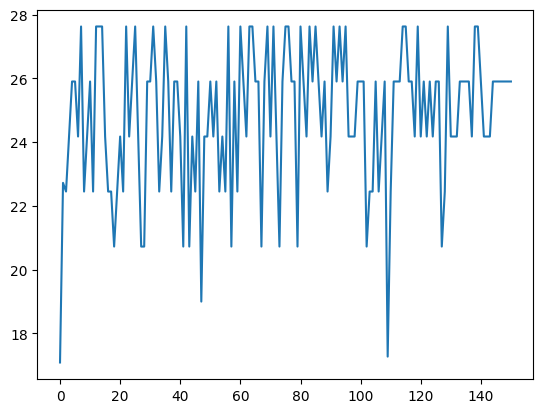

In [27]:

# -----------------------------------------------------------------------------------------------
#Parameters
n_hidden = 16
hid_layers = 3
activation = "tanh"
init = "Random"
batch_size=16
lossi = []
nepoch = 10
# optimizer = "rmsprop"
# opt = Optimizer(lr=1e-3, optimizer="nag")
loss_fn = "cross_entropy"
Loss = CrossEntropyLoss() if loss_fn=="cross_entropy" else MSE()

# -----------------------------------------------------------------------------------------------

X = train_images.reshape(train_images.shape[0], -1)/ 255.0
Y = train_labels
Y = np.eye(10)[Y]     #one_hot encoding


# -----------------------------------------------------------------------------------------------
#Model

# Define layer sizes
layer_sizes = [128]*hid_layers



if activation == "tanh":
  print("Activation used is Tanh")

  model = Sequential([Linear(784, layer_sizes[1], weight_init=init)])

  # Hidden layers
  for i in range(1, len(layer_sizes)-1):
      model.append(Tanh())
      model.append(Linear(layer_sizes[i], layer_sizes[i+1], weight_init=init))

  # Final output layer
  model.append(Tanh())
  model.append(Linear(layer_sizes[-1], 10, weight_init=init))  # 128->10


elif activation == "relu":
  print("Activation used is ReLu")
  model = Sequential([Linear(784, layer_sizes[1], weight_init=init)])

  # Hidden layers
  for i in range(1, len(layer_sizes)-1):
      model.append(Relu())
      model.append(Linear(layer_sizes[i], layer_sizes[i+1], weight_init=init))

  # Final output layer
  model.append(Relu())
  model.append(Linear(layer_sizes[-1], 10, weight_init=init))  # 128->10


elif activation == "sigmoid":
  print("Activation used is Sigmoid")
  model = Sequential([Linear(784, layer_sizes[1], weight_init=init)])

  # Hidden layers
  for i in range(1, len(layer_sizes)-1):
      model.append(Sigmoid())
      model.append(Linear(layer_sizes[i], layer_sizes[i+1], weight_init=init))

  # Final output layer
  model.append(Sigmoid())
  model.append(Linear(layer_sizes[-1], 10, weight_init=init))  # 128->10


else:
  raise Exception("Invalid activation function")

# -----------------------------------------------------------------------------------------------
#Training Loop
opt = Optimizer(lr=1e-1, optimizer="ndam", param=model.parameters())

for epoch in range(nepoch):
  logits = model(X)
  # train_loss = CrossEntropyLoss()(logits, Y)
  train_accuracy = np.mean(np.argmax(logits, axis=1) == np.argmax(Y, axis=1))

  val_logits = model(val_images.reshape(val_images.shape[0], -1)/ 255.0)
  Yv = np.eye(10)[val_labels]
  # val_loss = CrossEntropyLoss()(val_logits, Yv)
  val_accuracy = np.mean(np.argmax(val_logits, axis=1) == np.argmax(Yv, axis=1))

  print(f"Begining of Epoch: {epoch+1} Train Accuracy: {train_accuracy:.4f} Validation Accuracy: {val_accuracy:.4f}")
  print("-------x-------")
  #Shuffling
  indices = np.random.permutation(X.shape[0])
  X = X[indices]
  Y = Y[indices]
  for i in range(0, train_images.shape[0], batch_size):
    Xb = X[i:i + batch_size]
    Yb = Y[i:i + batch_size]

    # Forward Pass
    logits = model(Xb)
    loss = Loss(logits, Yb)

    #Backward Pass
    dout = Loss.grad(logits, Yb)
    dout = model.backward(dout)

    batch_num = i//batch_size
    total_batch = train_images.shape[0]//batch_size

    #parameter update
    if batch_num%200 == 0: # print every once in a while
      print(f'Epoch({epoch+1}/{nepoch})\t Batch({batch_num:2d}/{total_batch:2d}): \tTrain Loss  {loss:.4f}')

    opt(model.parameters(), dout[1])
    lossi.append(loss)

  opt.t += 1

logits = model(X)
train_accuracy = np.mean(np.argmax(logits, axis=1) == np.argmax(Y, axis=1))

val_logits = model(val_images.reshape(val_images.shape[0], -1)/ 255.0)
Yv = np.eye(10)[val_labels]
val_accuracy = np.mean(np.argmax(val_logits, axis=1) == np.argmax(Yv, axis=1))

print(f"End of Training: {epoch+1/nepoch} Train Accuracy: {train_accuracy:.4f} Validation Accuracy: {val_accuracy:.4f}")
# -----------------------------------------------------------------------------------------------
# Test Accuracy
x = test_images
x = x.reshape(x.shape[0], -1)
y = test_labels

#Forward Pass
logits = model(x)
accuracy_formula = np.mean(np.argmax(logits, axis=1) == y)
print(f"Test Accuracy: {accuracy_formula}")

plt.plot(lossi)
plt.show()





[]

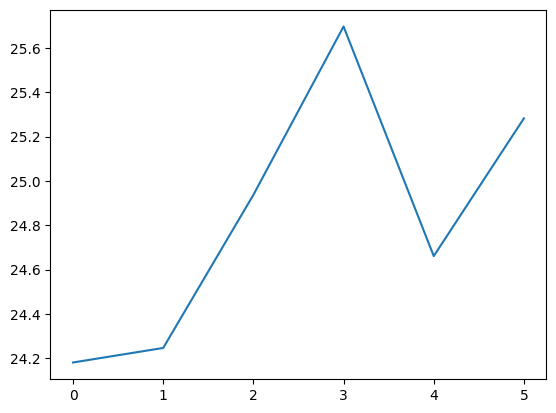

In [28]:
plt.plot(np.array(lossi).reshape(-1, 25).mean(1))
plt.plot()

In [ ]:
    # Learning Rate Scheduling
    # lr = 1e-4
    # if epoch < 3:
    #   lr = 1e-1
    # else:
    #   lr = 1e-3 if (batch_num*1.25) < total_batch else 1e-5
    # lr = max(lr * 0.5, 1e-5)



In [ ]:
    # clip_value=1e-3
    # velocity = [np.zeros_like(param) for param in model.parameters()]
    # for i, (u, param, grad) in enumerate(zip(velocity, model.parameters(), dout[1])):
    #     #momentum
    #     clipped_dparam = np.clip(grad, -clip_value, clip_value)
    #     u = 0.9 * u + 0.1 * clipped_dparam
    #     param -= lr * u + clipped_dparam #grad

    # RMS Prop
    #     clipped_dparam = np.clip(grad, -clip_value, clip_value)
    #     u = 0.9 * u + (1 - 0.9) * (clipped_dparam**2)
    #     param -= ((lr * clipped_dparam)/ (np.sqrt(u + 1e-8)))

In [ ]:
x.shape

(10000, 784)

In [ ]:
# class Dropout:
#     """Dropout layer which randomly sets activations to zero.

#     Parameters
#     ----------
#     p : float
#         The probability of zeroing any activation. Must be smaller than 1 and larger than 0
#     """
#     def __init__(self, p=0.5):
#         super(Dropout, self).__init__()
#         self.p = p
#         self.cache = dict(a=None)

#     def __call__(self, x):
#         return self.forward(x)

#     def forward(self, x):
#         if self.training:
#             mask = np.random.random(x.shape) > self.p
#             scale = 1.0 / (1-self.p)
#             a = x * mask * scale
#             self.cache = dict(a=a)
#             return a
#         return x

#     def backward(self, delta_in):
#         delta_out = delta_in * self.cache['a']
#         return delta_out

#     def parameters(self):
#       return []




In [ ]:
test_images.shape

(10000, 28, 28)

In [ ]:
ix = np.random.randint(0, test_images.shape[0], (1024))
x = test_images[ix]
x = x.reshape(1024, -1)
y = test_labels[ix]
# y = np.eye(10)[y]

#Forward Pass
logits = model(x)
exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
probs = exp_logits / np.sum(exp_logits + 1e-12, axis=1, keepdims=True)
#accuracy
accuracy_formula = np.mean(np.argmax(probs, axis=1) == test_labels[ix])
accuracy_formula




0.810546875

In [ ]:
y

array([2, 1, 8, ..., 7, 1, 8], dtype=uint8)

In [ ]:
probs;

In [ ]:
[i.shape for i in model.parameters()]

[(784, 1024), (1024,), (1024, 512), (512,), (512, 10), (10,)]

In [ ]:
[i.shape for i in dout[1]]

[(784, 1024), (1024,), (1024, 512), (512,), (512, 10), (10,)]

In [ ]:
#Parameter Update
[i.shape for i in model.parameters()]

[(784, 1024), (1024,), (1024, 512), (512,), (512, 10), (10,)]

In [ ]:
# Assuming you have a learning rate defined (e.g., lr = 0.001)
lr = 0.01

# Parameter Update
for i, param in enumerate(model.parameters()):
    param -= lr * model.parameters()[i]


In [ ]:
probs[0], y[0], np.mean([-np.log(probs[i][y[i].astype(bool)]) for i in range(32)])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (32,) + inhomogeneous part.

In [ ]:
# class Softmax:
#   def __call__(self, x):
#       exp_x = np.exp(x - np.max(x))
#       softmax_output = exp_x / np.sum(exp_x + 1e-12, axis=1, keepdims=True)
#       self.cache = {"x": softmax_output}
#       return softmax_output

#   def grad(self, d_out):
#       x = self.cache["x"]
#       # Softmax gradient using Jacobian matrix simplification
#       return x * (d_out - np.sum((d_out * x), axis=1, keepdim=True))

#   def parameters(self):
#       return []

class Softmax:
    def forward(self, x):
        self.cache['x'] = x
        exp_x = np.exp(x - np.max(x))
        softmax_output = exp_x / np.sum(exp_x + 1e-12, axis=1, keepdims=True)
        self.cache['y'] = softmax_output
        return softmax_output

    def __call__(self, x):
        return self.forward(x)

    # def grad(self, grad):
    #    pass

    def backward(self, grad):
        softmax_output = self.cache['y']
        jacobian_matrix = np.zeros((softmax_output.shape[0], softmax_output.shape[1], softmax_output.shape[1]))
        for i in range(softmax_output.shape[0]):
            for j in range(softmax_output.shape[1]):
                for k in range(softmax_output.shape[1]):
                    if j == k:
                        jacobian_matrix[i, j, k] = softmax_output[i, j] * (1 - softmax_output[i, k])
                    else:
                        jacobian_matrix[i, j, k] = -softmax_output[i, j] * softmax_output[i, k]
        grad_input = np.matmul(grad.reshape(grad.shape[0], 1, grad.shape[1]), jacobian_matrix).squeeze()
        return grad_input

    def parameters(self):
        return []

In [ ]:
exp_x

array([1.21812830e+08, 5.00494765e+00, 2.88747793e+16, 8.19706125e+00,
       2.18774776e+51, 5.76565793e-04, 7.93381879e-15, 5.07658567e+17,
       7.54881469e-04, 1.05752289e-15])

In [ ]:
exp_x = np.exp(model(x)[0])
exp_x / np.sum(exp_x + 1e-12,keepdims=True)

array([5.56795589e-44, 2.28771696e-51, 1.31984042e-35, 3.74680363e-51,
       1.00000000e+00, 2.63543084e-55, 3.62647784e-66, 2.32046205e-34,
       3.45049590e-55, 4.83384285e-67])

In [ ]:
-np.log(softmax()(model(x))[10])

array([134.17359438, 235.51615363, 225.55801352, 189.03856156,
       227.79684358, 416.92455184, 512.01980769, 321.44690602,
       258.26047933, 423.34805362])

In [ ]:
logits.shape, np.max(logits, axis=1, keepdims=True).shape

((32, 10), (32, 1))

In [ ]:
[np.max(logits[i]) for i in range(len(logits))]

[425.50188237519126,
 185.9094704847457,
 290.1206641997822,
 265.02186817180507,
 340.9891968659556,
 440.00742015485577,
 272.2057741111338,
 296.72707107667895,
 344.4222659414061,
 357.0928708290836,
 212.5657694618118,
 232.1679842541356,
 224.62922170386668,
 307.3223774692562,
 486.0651473556204,
 499.24873340385466,
 317.013440900536,
 315.2569022635988,
 229.15654673802587,
 309.7206506396219,
 633.4780787632286,
 414.4626196034568,
 472.40680273895975,
 395.5300074701161,
 277.6063515598283,
 172.51061125268632,
 155.2245678627663,
 406.95842297515213,
 363.629894835442,
 302.3364751552298,
 342.0113187046049,
 401.26389149417207]

In [ ]:
n = logits - np.max(logits, axis=1, keepdims=True)


array([[2.62207366e-141, 9.71711789e-220, 7.59852842e-021,
        1.73433708e-147, 3.36217896e-103, 1.00000000e+000,
        9.85886044e-100, 2.78856416e-167, 3.46430731e-161,
        2.28072253e-169],
       [7.54880441e-120, 1.00000000e+000, 1.29041877e-083,
        8.28147332e-161, 3.95743976e-151, 1.00761721e-006,
        1.17152787e-048, 5.61877276e-116, 1.00083379e-215,
        1.25502041e-161],
       [8.17594826e-119, 4.07263077e-173, 4.24410091e-092,
        1.49471482e-032, 4.22706790e-042, 1.28874399e-041,
        1.00000000e+000, 5.26623207e-195, 2.22357302e-087,
        5.61196663e-153],
       [9.18517675e-041, 0.00000000e+000, 4.23747693e-180,
        9.19149290e-162, 1.01909733e-258, 1.00000000e+000,
        1.86940819e-183, 9.25278142e-210, 1.93209702e-277,
        3.75415743e-117],
       [1.50586616e-206, 9.72607346e-114, 7.66796067e-168,
        6.76548592e-177, 1.31326308e-172, 1.00000000e+000,
        3.27365893e-207, 6.14033865e-219, 0.00000000e+000,
        5.7

In [ ]:
#Forward Pass
softmax_obj = softmax()
logits = model(x)
probs = softmax_obj(logits)
loss = CrossEntropyLoss()(logits, y)

#Backward Pass

dout = CrossEntropyLoss().grad(logits, y)
dout = softmax_obj.grad(dout)
dout = model.backward(dout)

# z = model.backward(y)


<ipython-input-5-19d7e426f8ab>:24: RuntimeWarning: invalid value encountered in log
  loss = -np.log(y[t.astype(bool)] + self.eps)


In [ ]:
[i.shape for i in z]

In [ ]:
[i.shape for i in model.parameters()]

In [ ]:
# prompt: define targets using torch.randn

targets = np.random.randn(32, 10) # Example: 32 samples, 10 classes


In [ ]:
np.max(model(x), axis=1)

In [ ]:
# Training Setup

model = Sequential([Linear(784, n_hidden, weight_init="Xavier")])
model.append(Sigmoid())
for _ in range(hid_layers-1):
    model.append(Linear(n_hidden, n_hidden))
    model.append(Sigmoid())
model.append(Linear(n_hidden, 10))

# Initialize parameters
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
learning_rate = 0.1
batch_size = 32

# Example training loop
def train_step(x_batch, y_batch):

    # Forward pass
    logits = model(x_batch)

    # Compute loss (cross-entropy)
    # probs = softmax(logits)
    # loss = -np.log(probs[range(batch_size), y_batch]).mean()

    # cross entropy loss (same as F.cross_entropy(logits, Yb))
    logit_maxes = np.max(logits, axis = 1, keepdims=True).values
    norm_logits = logits - logit_maxes # subtract max for numerical stability
    counts = np.exp(norm_logits)
    counts_sum = np.sum(counts, axis = 1, keepdims=True)
    counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
    probs = counts * counts_sum_inv
    logprobs = np.log(probs)
    loss = -logprobs[range(batch_size), y_batch].mean()


    dlogprobs = torch.zeros_like(logprobs)
    dlogprobs[range(batch_size), y_batch] = -1.0/len(y_batch)
    dprobs = (1.0 / probs) * dlogprobs
    dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
    dcounts = counts_sum_inv * dprobs
    dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
    dcounts += torch.ones_like(counts) * dcounts_sum
    dnorm_logits = counts * dcounts
    dlogits = dnorm_logits.clone()

    # Backward pass preparation
    d_out = np.clone(probs)
    d_out[range(batch_size), y_batch] -= 1
    d_out /= batch_size

    # Backward pass
    model.grad(d_out)

    # # Parameter update
    # with torch.no_grad():
    #     for p in parameters:
    #         p -= learning_rate * p.grad

    # return loss.item()

# Usage example with dummy data
x_dummy = torch.randn(batch_size, 784)
y_dummy = torch.randint(0, 10, (batch_size,))

for epoch in range(10):
    loss = train_step(x_dummy, y_dummy)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")


In [ ]:
import yaml
yaml.__version__

'6.0.2'